### This code uses 3 ML models to predict galaxy sizes using 33 (features) galaxy and halo properties.

### The aim of the experiment is 1. To predict galaxy sizes, 2. To learn if the prediction is model independent (RF vs SVR), 3. To extract the first few most important features (from RF built-in functions) that can predict galaxy sizes
#### The different ML models used are: 
####  <font color='violet'> 1. Size, Mass and Halo Spin plot
####  <font color='darkblue'> 2. Normalization of Dataset
####  <font color='darkblue'> 3. Correlations Matrix of Normalized Dataset
####  <font color='darkblue'> 1. Linear Regression
#### <font color='darkblue'> 2. Random Forest Regressor
#### <font color='blue'> 2.a. Random Forest using all available features
#### <font color='red'>  2.b. Random Forest Feature Importance MDI & Permutation
#### <font color='blue'> 2.c. Random Forest using only halo properties as features
#### <font color='darkblue'> 3. Support Vector Regressor
#### <font color='blue'> 3.a. Support Vector Regressor using all available features
#### <font color='blue'> 3.b. Support Vector Regressor using only halo properties as features
#### The different different datasets used are: 
#### 1. 33-feature set
#### 2. 10-feature set



In [1]:
import time
import numpy as np
import pandas as pd

import galsim #install with conda install -c conda_forge galsim

import matplotlib.pyplot as plt
from matplotlib import pyplot
import matplotlib.cm as cm
import matplotlib.colors as norm
from matplotlib.gridspec import SubplotSpec
import seaborn as sns

from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn import svm
from sklearn.svm import SVR

from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import cross_validate, KFold, StratifiedKFold
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score
from sklearn.inspection import permutation_importance
from sklearn.pipeline import make_pipeline #This allows one to build different steps together
from sklearn.preprocessing import StandardScaler, RobustScaler



#### <font color='violet'> ML modelling with 33 galaxy and halo features; df from v5 used here



In [2]:
# df here read from the data filtered file from notebook v5
df_log_mass_filtered_v5 = pd.read_csv ('df_log_mass_filtered_v5.csv') 

In [3]:
df_log_mass_filtered_v5['GalpropLogMbulge'].value_counts()

0.000000    5
8.021355    4
8.297069    3
8.243385    3
7.482021    3
           ..
8.388302    1
7.645015    1
8.262624    1
9.488336    1
8.235018    1
Name: GalpropLogMbulge, Length: 34980, dtype: int64

In [4]:
df_log_mass_filtered_v5['GalpropLogMbulge'].max()

11.926815581581586

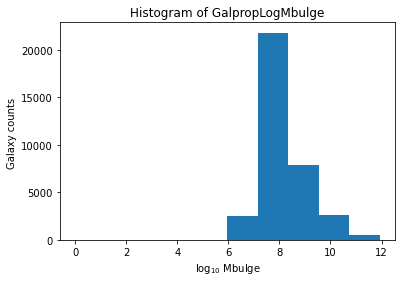

In [5]:

plt.hist(df_log_mass_filtered_v5['GalpropLogMbulge'])

plt.title('Histogram of GalpropLogMbulge')
plt.xlabel('$\log_{10} $ Mbulge')
plt.ylabel('Galaxy counts ')
# plt.savefig('Histogram of GalpropLogMbulge.jpg', dpi=500)

plt.show()

### <font color='violet'> 1. Size, Mass and Halo Spin plot




##### For this part of the code, I need log of GalpropMstar and log of GalpropHalfRadius in order to make the plot. However, since I drop GalpropMstar from the df immediately after normalization, I should plot it first thing here. For a reference to this plot, see notebook v5 with the same title.

In [6]:
mass_size_corr = round(stats.spearmanr(df_log_mass_filtered_v5['GalpropLogMstar'], 
                                               df_log_mass_filtered_v5['GalpropLogHalfRadius'])[0], 2)
SFR_size_corr = round(stats.spearmanr(df_log_mass_filtered_v5['GalpropLogSfr'], 
                                              df_log_mass_filtered_v5['GalpropLogHalfRadius'] )[0], 2)
SFR_mass_corr = round(stats.spearmanr(df_log_mass_filtered_v5['GalpropLogSfr'], 
                                              df_log_mass_filtered_v5['GalpropLogMstar'] )[0], 2)
mom_size_corr = round(stats.spearmanr(df_log_mass_filtered_v5['HalopropSpin'], 
                                              df_log_mass_filtered_v5['GalpropLogHalfRadius'])[0], 2)



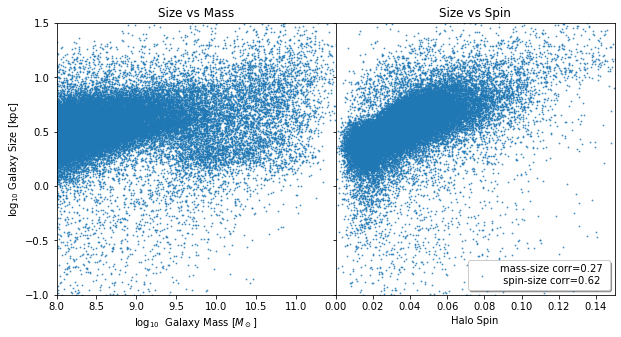

In [7]:
fig,[ax1, ax2]=plt.subplots(nrows=1,ncols=2, sharey=True, figsize=(10,5))
# fig.suptitle('TNG-SAM Central Galaxies: Size, Mass and Halo Angular Momentum  ', fontsize=16, fontweight='bold')
plt.subplots_adjust(hspace=0.0,wspace=0.0)

im1 = ax1.scatter(df_log_mass_filtered_v5['GalpropLogMstar'], df_log_mass_filtered_v5['GalpropLogHalfRadius'], 
                    s=3, marker='.', alpha=0.7 , vmin=-2, vmax=1.0)
#                   c = (df_log_mass_filtered['GalpropLogSfr']),  s=3, marker='.', alpha=0.7 , vmin=-2, vmax=1.0)#, label=label)

ax1.set_xlim([8.0, 11.5])
ax1.set_xticks([8.0, 8.5, 9.0, 9.5, 10.0, 10.5, 11.0])
ax1.set_ylim([-1.0,1.5])
ax1.set_title('Size vs Mass')
ax1.set_xlabel('$\log_{10} $  Galaxy Mass $[M_\odot] $')
ax1.set_ylabel('$\log_{10} $ Galaxy Size [kpc] ')
# ax1.legend(loc='lower right', shadow=True)


label = 'mass-size corr={} \n spin-size corr={}'.format(mass_size_corr, mom_size_corr )
im2 = ax2.scatter(df_log_mass_filtered_v5['HalopropSpin'], df_log_mass_filtered_v5['GalpropLogHalfRadius'], 
                     s=3, marker='.', alpha=0.7,label= label, vmin=-2, vmax=1.0)
#                   c = (df_log_mass_filtered['GalpropLogSfr']),  s=3, marker='.', alpha=0.7,label= label, vmin=-2, vmax=1.0)

ax2.set_xlim([0.0,0.15])
# ax2.set_xticks([ 0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3])
# ax2.set_ylim([-3.0, 1.1])
ax2.set_title('Size vs Spin')
ax2.set_xlabel('Halo Spin')
# ax2.set_ylabel('$\log_{10} \, \, Galaxy Size [kpc]($ Log_{10} $)')
ax2.legend(loc='lower right' , shadow=True)

# fig.subplots_adjust(right=0.8)
# cbar_ax = fig.add_axes([0.85, 0.15, 0.01, 0.7])
# fig.colorbar(im2, cax=cbar_ax)

# plt.savefig("TNG-SAM_centrals_Mass_Size_AngMom_v5_log.jpeg", dpi=500)
plt.show()

### Drop the columns not needed (see explanations in related doc 'TNG-SAM 33-feature analysis')

In [8]:
df_log_mass_filtered=df_log_mass_filtered_v5.drop(columns =['GalpropRedshift', 
                                               'GalpropRfric', 'HalopropMaccdot_metal', 'HalopropMaccdot_pristine',
                                               'HalopropMaccdot_reaccreate_metal', 'HalopropMcooldot',
                                               'HalopropMdot_eject', 'HalopropMdot_eject_metal',
                                               'GalpropX', 'GalpropVx','GalpropY', 'GalpropVy',
                                               'GalpropZ', 'GalpropVz', 'GalpropTsat',
                                               'GalpropLogMstar', 'GalpropLogHalfRadius', 'GalpropLogMvir',
                                               'HalopropLogMhot', 'GalpropLogMbulge', 'GalpropLogSfr',
                                               'GalpropLogSfrave100myr', 'GalpropLogSfrave1gyr', 
                                               'GalpropLogSfrave20myr', 'Galprop_neutral_H_mass',
                                               'Galprop_baryon_mass', 'Galprop_gas_fraction',
                                               'GalpropRbulge',  'GalpropRdisk', 'GalpropMvir', 'GalpropMstrip'])

## 2. Normalization of dataset

### Normalize SigmaBulge and Vdisk by Vvir


In [9]:
from astropy.cosmology import FlatLambdaCDM
from astropy import units as u
from astropy import constants as cons


def Delta(z,Om0=0.279,Ob0=0.046,h=0.7):
    #Bryan & Norman 99
    cosmo = FlatLambdaCDM(H0=100*h, Om0=Om0, Ob0=Ob0)
    x=cosmo.Om(z)-1
    return 18*np.pi**2+82*x-39*x**2

def rho_crit(z,Om0=0.279,Ob0=0.046,h=0.7):
    cosmo = FlatLambdaCDM(H0=100*h, Om0=Om0, Ob0=Ob0)
    return cosmo.critical_density(z).to(u.Msun/u.kpc**3).value

def rho_vir(z,Om0=0.279,Ob0=0.046,h=0.7):
    D=Delta(z,Om0=Om0,Ob0=Ob0,h=h)
    cosmo = FlatLambdaCDM(H0=100*h, Om0=Om0, Ob0=Ob0)
    rho_c = cosmo.critical_density(z).to(u.Msun/u.kpc**3).value
    return D*rho_c

def Rvir_to_Mvir(Rvir,z,Om0=0.279,Ob0=0.046,h=0.7):
    rho_v = rho_vir(z,Om0=Om0,Ob0=Ob0,h=h)
    return rho_v*4./3.*np.pi*Rvir**3   #Msun

def Mvir_to_Rvir(Mvir,z,Om0=0.279,Ob0=0.046,h=0.7):
    rho_v = rho_vir(z,Om0=Om0,Ob0=Ob0,h=h)
    return  (Mvir/(rho_v*4./3.*np.pi))**(1./3.)  #kpc

def Mvir_to_Vvir(Mvir,z,Om0=0.279,Ob0=0.046,h=0.7):
    Rvir = Mvir_to_Rvir(Mvir,z,Om0=Om0,Ob0=Ob0,h=h)
    return (np.sqrt(cons.G*Mvir*u.Msun/(Rvir*u.kpc))).to(u.km/u.s)

In [10]:
# Define Halo property Vvir (as it does not exist in the dataset above)
v= Mvir_to_Vvir (np.array(df_log_mass_filtered.loc[:,'HalopropMvir']),0) # has units

In [11]:
# add Halo property Vvir
df_log_mass_filtered.loc[:, 'HalopropVvir']=v.value # shape of df at this point: df_log_mass_filtered.shape (35390, 36)

### Normalize the dataset by dividing masses by Mhalo and size by Rhalo

In [12]:
def normalization_func(df):
    '''
    Normalizes the dataset by dividing all masses by halo mass, and galaxy size by halo size

    '''
#     could also use the method below
#     df_log_mass_filtered.loc[:,'GalpropNormMstar']=df_log_mass_filtered.loc[:,'GalpropMstar'].div(df_log_mass_filtered.HalopropMvir, axis=0)
    
    halomass=df.loc[:,'HalopropMvir']
    halorad= df.loc[:,'GalpropRhalo']
    
    df.loc[:,'GalpropNormHalfRadius']=df.loc[:,'GalpropHalfRadius']/halorad
    df.loc[:,'GalpropNormRhalo']=df.loc[:,'GalpropRhalo']/halorad

    df.loc[:,'GalpropNormMstar']=df.loc[:,'GalpropMstar']/halomass
#     df.loc[:,'GalpropNormMvir']=df.loc[:,'GalpropMvir']/halomass
    df.loc[:,'HalopropNormMhot']=df.loc[:,'HalopropMhot']/halomass
    df.loc[:,'GalpropNormMbulge']=df.loc[:,'GalpropMbulge']/halomass
    
    df.loc[:,'GalpropNormMBH']=df.loc[:,'GalpropMBH']/halomass
    df.loc[:,'GalpropNormMH2']=df.loc[:,'GalpropMH2']/halomass
    df.loc[:,'GalpropNormMHI']=df.loc[:,'GalpropMHI']/halomass
    df.loc[:,'GalpropNormMHII']=df.loc[:,'GalpropMHII']/halomass
    df.loc[:,'GalpropNormMcold']=df.loc[:,'GalpropMcold']/halomass
    df.loc[:,'GalpropNormMstar_merge']=df.loc[:,'GalpropMstar_merge']/halomass
#     df.loc[:,'GalpropNormMstrip']=df.loc[:,'GalpropMstrip']/halomass
    
    df.loc[:,'HalopropNormMass_ejected']=df.loc[:,'HalopropMass_ejected']/halomass
    df.loc[:,'HalopropNormMstar_diffuse']=df.loc[:,'HalopropMstar_diffuse']/halomass
    df.loc[:,'HalopropNormMvir']=df.loc[:,'HalopropMvir']/halomass
    
    df.loc[:,'GalpropNormSigmaBulge']=df.loc[:,'GalpropSigmaBulge']/df.loc[:,'HalopropVvir']
    df.loc[:,'GalpropNormVdisk']=df.loc[:,'GalpropVdisk']/df.loc[:,'HalopropVvir']
    
    return df

In [13]:
df_normalized=normalization_func(df_log_mass_filtered) # where shape is: df_normalized.shape=(35390, 52)

In [14]:
# drop the original columns of normalized features + columns used for normalization
df_normalized=df_normalized.drop(columns=['GalpropHalfRadius',  'GalpropMstar',
 'HalopropMhot','GalpropMbulge','GalpropMBH','GalpropMH2','GalpropMHI','GalpropMHII',
 'GalpropMcold','GalpropMstar_merge','HalopropMass_ejected',
 'HalopropMstar_diffuse','HalopropMvir', 'HalopropNormMvir', 'GalpropRhalo','GalpropNormRhalo', 'HalopropVvir',
                                        'GalpropSigmaBulge', 'GalpropVdisk' ])
# df shape now is: df_normalized.shape =(35390, 33)

## 3. Correlations matrix of Normalized dataset

In [15]:
df_pairplot=df_normalized.loc[:,['GalpropMaccdot', 'GalpropMaccdot_radio', 'GalpropMu_merger',
       'GalpropOutflowRate_Mass', 'GalpropOutflowRate_Metal', 'GalpropSfr',
       'GalpropSfrave100myr', 'GalpropSfrave1gyr', 'GalpropSfrave20myr',
       'GalpropTmerger', 'GalpropTmerger_major', 'GalpropZcold',
       'GalpropZstar', 'HalopropC_nfw', 'HalopropMaccdot_radio',
       'HalopropMaccdot_reaccreate', 'HalopropMetal_ejected', 'HalopropSpin',
       'HalopropZhot', 'GalpropNormMstar',
       'HalopropNormMhot', 'GalpropNormMbulge', 'GalpropNormMBH',
       'GalpropNormMH2', 'GalpropNormMHI', 'GalpropNormMHII',
       'GalpropNormMcold', 'GalpropNormMstar_merge',
       'HalopropNormMass_ejected', 'HalopropNormMstar_diffuse',
       'GalpropNormSigmaBulge', 'GalpropNormVdisk', 'GalpropNormHalfRadius']]

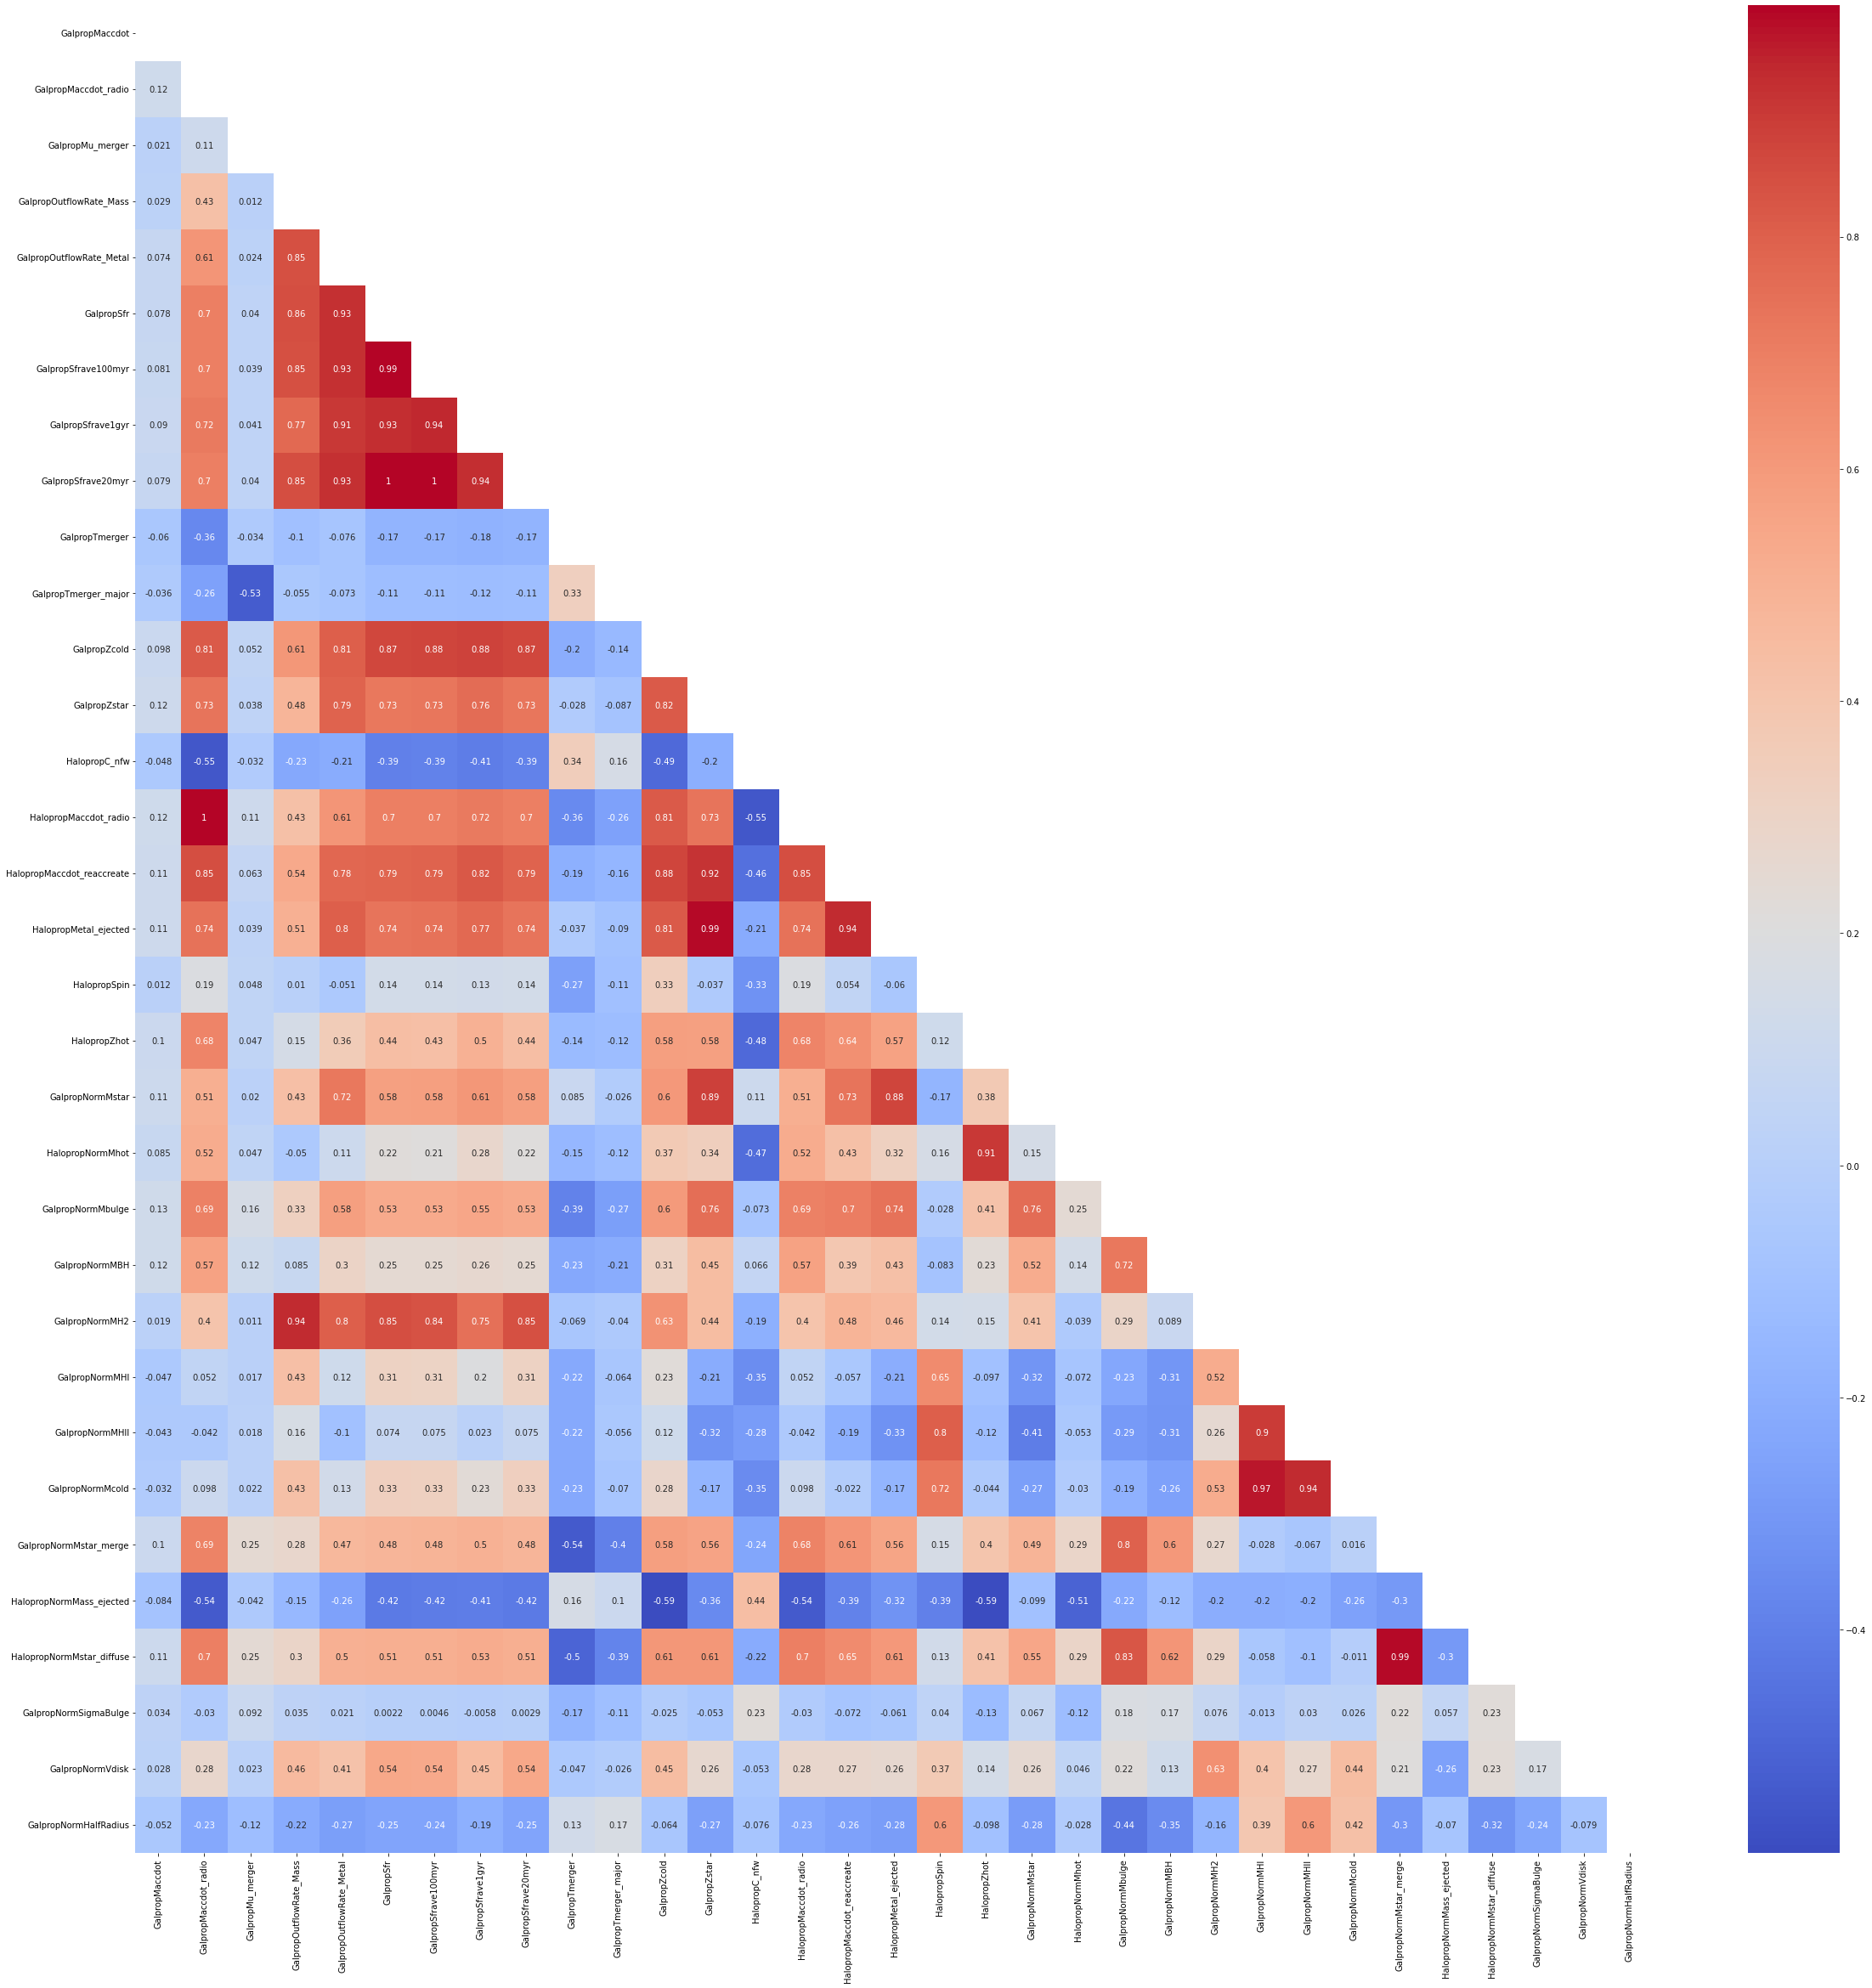

In [16]:
corr_df = df_pairplot.corr('spearman')
# corr_df = corr_df.sort_values('GalpropHalfRradius') # this is not a matrix where diagonal is 1 anymore; it only arranges half rad values from smallest to biggest
plt.figure(figsize=(40,40))
matrix = np.triu(corr_df) # take upper correlation matrix
sns.heatmap(corr_df, cmap="coolwarm",annot=True, mask=matrix)
# plt.title("Spearman Correlation of TNG-SAM ", fontsize = 20)
# plt.xlabel("Features", fontsize = 20)
# plt.savefig('TNG-SAM_morefeatures_Spearman_Normalized_correlation_matrix.jpeg', dpi=500)
plt.show()

# ML modelling

## 4. 33-feature Dataset: Define labels and target (X,y)

In [17]:
X = df_normalized.drop(columns=['GalpropNormHalfRadius'])


y = df_normalized.loc[:,'GalpropNormHalfRadius']

## <font color='blue'> 1. Linear Regression (LR) - all features


In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [18]:
reg = LinearRegression() # choose the model: Linear Regression

In [19]:
reg.fit(X_train, y_train) # fit the data to the chosen model

LinearRegression()

In [20]:
# predict y (galaxy sizes) by using 5-fold cross-validation
y_pred_LR = cross_val_predict(reg, X, y, cv = KFold(n_splits=5, shuffle=True, random_state=10))

In [21]:
# find prediction scores of each of the cross validation fold
scores_reg = cross_val_score(reg, X, y, cv = KFold(n_splits=5, shuffle=True, random_state=10))

In [22]:
print("Accuracy: %0.2f (+/- %0.2f)" % (scores_reg.mean(), scores_reg.std() * 2))

Accuracy: 0.55 (+/- 0.14)


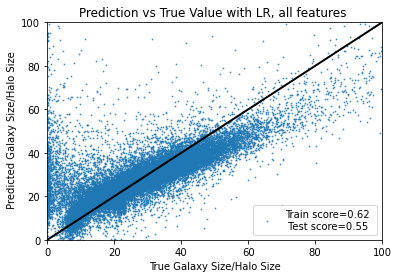

In [31]:
label = 'Train score={} \n Test score={}'.format(round(reg.score(X_train, y_train), 2),round(scores_reg.mean(), 2) )
# label='Cross_val mean test score={}'.format(round(scores_reg.mean(),2))

plt.scatter(y, y_pred_LR, s=3, marker='.', alpha=0.7, label=label)
plt.axis([0.0,100, 0.0,100])
plt.plot([0.0, 170], [0.0, 170], color = 'black', linewidth = 2)
# xpoints = ypoints = plt.xlim()
# plt.plot(xpoints, ypoints, linestyle='-', color='k', lw=3, scalex=False, scaley=False)
plt.title('Prediction vs True Value with LR, all features ')
plt.xlabel('True Galaxy Size/Halo Size')
plt.ylabel(' Predicted Galaxy Size/Halo Size')
plt.legend(loc='lower right')

plt.show()

## <font color='blue'> 2.a. Random Forest (RF) - all features

In [24]:
regr_RF = RandomForestRegressor( random_state=0)

# number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 50, num = 3)]
# number of features at every split
# max_features = ['auto', 'sqrt']


# create random grid
grid = {'bootstrap': [True],
               'max_depth': [5, 10, None],
#                'max_features': ['auto', 'sqrt'],
               'min_samples_leaf': [1, 2, 4],
#                'min_samples_split': [2, 5, 10],
               'n_estimators': n_estimators}
# Grid search of parameters
rfr_grid = GridSearchCV(estimator = regr_RF, param_grid = grid, cv = KFold(n_splits=5, shuffle=True), \
                     verbose = 1, n_jobs = -1, return_train_score=True)

rfr_grid.fit(X, y)

print('Best params, best score:', "{:.4f}".format(rfr_grid.best_score_), \
    rfr_grid.best_params_)



Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best params, best score: 0.9138 {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 2, 'n_estimators': 50}


In [25]:
best_RF=rfr_grid.best_estimator_ # The index (of the cv_results_ arrays) which corresponds to the best candidate parameter setting.

In [26]:
best_RF_trainscore=rfr_grid.cv_results_['mean_train_score'][rfr_grid.best_index_]

In [27]:
# predict y (galaxy sizes) by using 5-fold cross-validation
y_pred_RF = cross_val_predict(best_RF, X, y, cv = KFold(n_splits=5, shuffle=True, random_state=10))

In [28]:
# find prediction scores of each of the cross validation fold
scores_RF = cross_val_score(best_RF, X, y, cv = KFold(n_splits=5, shuffle=True, random_state=10))

In [29]:
print("Accuracy: %0.2f (+/- %0.2f)" % (scores_RF.mean(), scores_RF.std() * 2))

Accuracy: 0.92 (+/- 0.02)


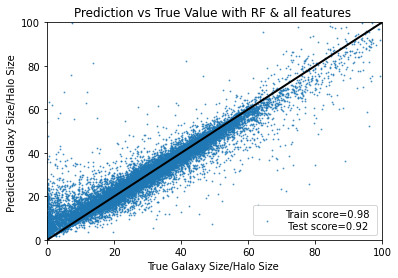

In [30]:
label = 'Train score={} \n Test score={}'.format(round(best_RF_trainscore, 2),round(scores_RF.mean(), 2) )
# label='Cross_val mean test score={}'.format(round(scores_RF.mean(),2))

plt.scatter(y, y_pred_RF, s=3, marker='.', alpha=0.7, label=label)
plt.axis([0.0,100, 0.0,100])
plt.plot([0.0, 170], [0.0, 170], color = 'black', linewidth = 2)
plt.title('Prediction vs True Value with RF & all features ')
plt.xlabel('True Galaxy Size/Halo Size ')
plt.ylabel(' Predicted Galaxy Size/Halo Size  ')
plt.legend(loc='lower right')
# plt.savefig('Prediction_vs_True.jpeg', dpi=500)
# xpoints = ypoints = plt.xlim()
# plt.plot(xpoints, ypoints, linestyle='--', color='k', lw=3, scalex=False, scaley=False)
plt.show()

## <font color='red'> 2.b. Random Forest (RF) Feature Importance MDI & Permutation

In [32]:
start_time = time.time()
importances = rfr_grid.best_estimator_.feature_importances_
std = np.std([tree.feature_importances_ for tree in rfr_grid.best_estimator_.estimators_], axis=0)
elapsed_time = time.time() - start_time

print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

Elapsed time to compute the importances: 0.028 seconds


Elapsed time to compute the importances: 33.098 seconds


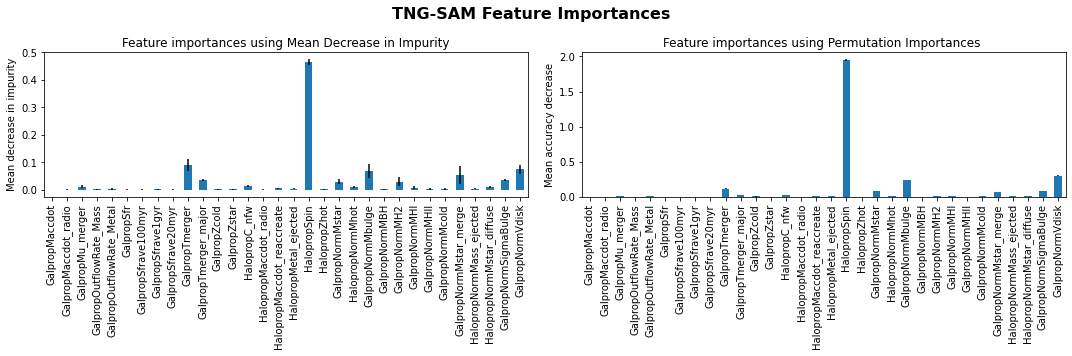

In [33]:

feature_names = X.columns

forest_importances = pd.Series(importances, index=feature_names)

fig, [ax1, ax2] = plt.subplots(1,2, figsize=(15,5))
fig.suptitle('TNG-SAM Feature Importances  ', fontsize=16, fontweight='bold')

forest_importances.plot.bar(yerr=std, ax=ax1)
ax1.set_title("Feature importances using Mean Decrease in Impurity")
ax1.set_ylabel("Mean decrease in impurity")
# plt.savefig("Feature_Importances_MDI.jpeg", dpi=500)

### Feature Importances Permutation


start_time = time.time()
result = permutation_importance(
    rfr_grid.best_estimator_, X, y, n_repeats=10, random_state=0, n_jobs=-1
)
elapsed_time = time.time() - start_time
print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

forest_importances = pd.Series(result.importances_mean, index=feature_names)

forest_importances.plot.bar(yerr=result.importances_std, ax=ax2)
ax2.set_title("Feature importances using Permutation Importances ")
ax2.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
# plt.savefig("Feature_Importances_v2.jpeg", dpi=500)

plt.show()

In [34]:
df_perm_import=pd.DataFrame(forest_importances).sort_values(0, ascending=False)

In [35]:
# 7 most important features that determine galaxy size
df_perm_import.head(7)

,0
HalopropSpin,1.947958
GalpropNormVdisk,0.300745
GalpropNormMbulge,0.236903
GalpropTmerger,0.113986
GalpropNormMstar,0.082063
GalpropNormSigmaBulge,0.078982
GalpropNormMstar_merge,0.069843


## <font color='darkviolet'> 2.c. Random Forest (RF) pipeline that determines min number of important features & their effect on R^2 score

### Add-column Feature Ranking

In [273]:
def run_random_search_pipeline(X, y):
    
    
    n_estimators = [int(x) for x in np.linspace(start = 10, stop = 50, num = 3)]
#     grid = {'bootstrap': [True],
#                    'max_depth': [5, 10, None],
#     #                'max_features': ['auto', 'sqrt'],
#                    'min_samples_leaf': [1, 2, 4],
#     #                'min_samples_split': [2, 5, 10],
#                    'n_estimators': n_estimators}

    n_estimators = [int(x) for x in np.linspace(start = 80, stop = 100, num = 1)]
    grid = {'bootstrap': [True],
                   'max_depth': [None],
    #                'max_features': ['auto', 'sqrt'],
                   'min_samples_leaf': [2],
    #                'min_samples_split': [2, 5, 10],
                   'n_estimators': n_estimators}
    
#     pipeline = make_pipeline(RandomForestRegressor())
    model=RandomForestRegressor()

    reg_RF = GridSearchCV(model, grid, cv = KFold(n_splits=3, shuffle=True), \
                         verbose = 3, n_jobs = -1, return_train_score=True)
    reg_RF.fit(X, y)
#     estimator.get_params().keys()
    scores_lim = pd.DataFrame(reg_RF.cv_results_)

    scores_lim = scores_lim[['params','mean_test_score','std_test_score','mean_train_score', 'mean_fit_time']].sort_values(by = 'mean_test_score', ascending = False)
    
    return scores_lim['mean_test_score']

In [265]:
column_names = X.columns

In [268]:

def calculate_r_score(column_names):
    x_new = X[list(column_names)]
    # print(column_names)
    r_square = run_random_search_pipeline(x_new, y)
    
    return r_square.max()

In [269]:
def print_results(max_col_names, max_col_rscores):
    k= 1
    for i, j in zip(max_col_names, max_col_rscores):
        print("\t", k, i,j)
        k +=1

In [270]:
def calc_ith_iteration(max_col_names, max_col_rscores, orj_column_names, i):
    r_score_dict = {}
    for column_names in tqdm(orj_column_names): # orj_column_names = original column names
        # count += 1
        # print(count, max_col_names , column_names)
        feature_list = max_col_names + [column_names]
        r_score = calculate_r_score(feature_list)
        r_score_dict[column_names] = r_score
    
    max_col_names.append(max(r_score_dict, key=r_score_dict.get))
    max_col_rscores.append(max(r_score_dict.values()))
    # print("asdfasd", max_col_names[len(max_col_names) - 1])
    
    orj_column_names.remove(max_col_names[len(max_col_names) - 1])
    
    return max_col_names, max_col_rscores, orj_column_names, r_score_dict

In [271]:
# init
from tqdm import tqdm 
max_col_names = [] # 
max_col_rscores = []
orj_column_names = list(X.columns)

In [248]:
max_col_rscores

[0.23702288626295742, 0.48903965966816626]

[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=10;, score=(train=0.586, test=0.242) total time=   0.4s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=10;, score=(train=0.376, test=-0.023) total time=   0.3s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.400, test=-0.017) total time=   1.0s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=30;, score=(train=0.852, test=0.481) total time=   1.4s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=10;, score=(train=0.592, test=0.221) total time=   0.3s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.608, test=0.234) total time=   1.0s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=10;, score=(train=0.381, test=-0.030) total time=   0.3s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_le

In [275]:
# main 
for i in range(1, len(orj_column_names)+1):
    max_col_names, max_col_rscores, orj_column_names, r_score_dict = \
        calc_ith_iteration(max_col_names, max_col_rscores, orj_column_names, i)
        
    print(f"{i}. iteration: ")
    print_results(max_col_names, max_col_rscores)
    if i==17: break

  0%|                                                    | 0/32 [00:00<?, ?it/s]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


  3%|█▍                                          | 1/32 [00:00<00:25,  1.19it/s]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


  6%|██▊                                         | 2/32 [00:02<00:31,  1.04s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


  9%|████▏                                       | 3/32 [00:08<01:39,  3.44s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 12%|█████▌                                      | 4/32 [00:13<01:53,  4.04s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 16%|██████▉                                     | 5/32 [00:18<02:00,  4.46s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 19%|████████▎                                   | 6/32 [00:23<01:59,  4.58s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 22%|█████████▋                                  | 7/32 [00:28<01:57,  4.70s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 25%|███████████                                 | 8/32 [00:33<01:59,  4.97s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 28%|████████████▍                               | 9/32 [00:38<01:54,  4.99s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 31%|█████████████▍                             | 10/32 [00:42<01:38,  4.47s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 34%|██████████████▊                            | 11/32 [00:44<01:18,  3.75s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 38%|████████████████▏                          | 12/32 [00:49<01:21,  4.10s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 41%|█████████████████▍                         | 13/32 [00:54<01:27,  4.59s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 44%|██████████████████▊                        | 14/32 [01:01<01:33,  5.20s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 47%|████████████████████▏                      | 15/32 [01:02<01:06,  3.92s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 50%|█████████████████████▌                     | 16/32 [01:08<01:11,  4.45s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 53%|██████████████████████▊                    | 17/32 [01:13<01:12,  4.84s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 56%|████████████████████████▏                  | 18/32 [01:17<01:03,  4.51s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 59%|█████████████████████████▌                 | 19/32 [01:22<01:01,  4.70s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 62%|██████████████████████████▉                | 20/32 [01:28<00:58,  4.90s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 66%|████████████████████████████▏              | 21/32 [01:31<00:49,  4.50s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 69%|█████████████████████████████▌             | 22/32 [01:35<00:42,  4.22s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 72%|██████████████████████████████▉            | 23/32 [01:35<00:28,  3.18s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 75%|████████████████████████████████▎          | 24/32 [01:39<00:26,  3.35s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 78%|█████████████████████████████████▌         | 25/32 [01:43<00:24,  3.56s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 81%|██████████████████████████████████▉        | 26/32 [01:47<00:21,  3.66s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 84%|████████████████████████████████████▎      | 27/32 [01:51<00:18,  3.78s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 88%|█████████████████████████████████████▋     | 28/32 [01:54<00:13,  3.43s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 91%|██████████████████████████████████████▉    | 29/32 [01:59<00:11,  3.83s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 94%|████████████████████████████████████████▎  | 30/32 [02:00<00:06,  3.22s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 97%|█████████████████████████████████████████▋ | 31/32 [02:05<00:03,  3.67s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


100%|███████████████████████████████████████████| 32/32 [02:08<00:00,  4.01s/it]


1. iteration: 
	 1 HalopropSpin 0.24174854754862443


  0%|                                                    | 0/31 [00:00<?, ?it/s]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


  3%|█▍                                          | 1/31 [00:03<01:51,  3.71s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


  6%|██▊                                         | 2/31 [00:11<02:51,  5.90s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 10%|████▎                                       | 3/31 [00:18<03:04,  6.58s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 13%|█████▋                                      | 4/31 [00:25<03:03,  6.81s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 16%|███████                                     | 5/31 [00:32<03:01,  6.98s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 19%|████████▌                                   | 6/31 [00:39<02:54,  6.99s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 23%|█████████▉                                  | 7/31 [00:47<02:47,  7.00s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 26%|███████████▎                                | 8/31 [00:54<02:41,  7.02s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 29%|████████████▊                               | 9/31 [01:01<02:34,  7.02s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 32%|█████████████▊                             | 10/31 [01:07<02:22,  6.78s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 35%|███████████████▎                           | 11/31 [01:12<02:07,  6.35s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 39%|████████████████▋                          | 12/31 [01:19<02:05,  6.62s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 42%|██████████████████                         | 13/31 [01:27<02:03,  6.85s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 45%|███████████████████▍                       | 14/31 [01:34<01:57,  6.92s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 48%|████████████████████▊                      | 15/31 [01:41<01:53,  7.07s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 52%|██████████████████████▏                    | 16/31 [01:49<01:47,  7.15s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 55%|███████████████████████▌                   | 17/31 [01:56<01:41,  7.23s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 58%|████████████████████████▉                  | 18/31 [02:03<01:32,  7.13s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 61%|██████████████████████████▎                | 19/31 [02:10<01:25,  7.16s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 65%|███████████████████████████▋               | 20/31 [02:17<01:17,  7.03s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 68%|█████████████████████████████▏             | 21/31 [02:24<01:09,  6.90s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 71%|██████████████████████████████▌            | 22/31 [02:31<01:04,  7.14s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 74%|███████████████████████████████▉           | 23/31 [02:38<00:57,  7.14s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 77%|█████████████████████████████████▎         | 24/31 [02:46<00:50,  7.21s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 81%|██████████████████████████████████▋        | 25/31 [02:53<00:43,  7.22s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 84%|████████████████████████████████████       | 26/31 [03:00<00:35,  7.18s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 87%|█████████████████████████████████████▍     | 27/31 [03:07<00:27,  6.95s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 90%|██████████████████████████████████████▊    | 28/31 [03:14<00:21,  7.05s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 94%|████████████████████████████████████████▏  | 29/31 [03:20<00:13,  6.91s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 97%|█████████████████████████████████████████▌ | 30/31 [03:27<00:06,  6.93s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


100%|███████████████████████████████████████████| 31/31 [03:34<00:00,  6.92s/it]


2. iteration: 
	 1 HalopropSpin 0.24174854754862443
	 2 GalpropNormMstar_merge 0.5196900658536073


  0%|                                                    | 0/30 [00:00<?, ?it/s]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


  3%|█▍                                          | 1/30 [00:06<03:10,  6.56s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


  7%|██▉                                         | 2/30 [00:15<03:46,  8.09s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 10%|████▍                                       | 3/30 [00:25<03:58,  8.82s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 13%|█████▊                                      | 4/30 [00:34<03:56,  9.08s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 17%|███████▎                                    | 5/30 [00:44<03:50,  9.22s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 20%|████████▊                                   | 6/30 [00:53<03:43,  9.31s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 23%|██████████▎                                 | 7/30 [01:03<03:36,  9.43s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 27%|███████████▋                                | 8/30 [01:12<03:26,  9.38s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 30%|█████████████▏                              | 9/30 [01:21<03:15,  9.29s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 33%|██████████████▎                            | 10/30 [01:30<03:02,  9.15s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 37%|███████████████▊                           | 11/30 [01:39<02:49,  8.90s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 40%|█████████████████▏                         | 12/30 [01:48<02:42,  9.04s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 43%|██████████████████▋                        | 13/30 [01:57<02:34,  9.08s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 47%|████████████████████                       | 14/30 [02:06<02:26,  9.13s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 50%|█████████████████████▌                     | 15/30 [02:15<02:16,  9.13s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 53%|██████████████████████▉                    | 16/30 [02:25<02:08,  9.21s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 57%|████████████████████████▎                  | 17/30 [02:34<01:59,  9.21s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 60%|█████████████████████████▊                 | 18/30 [02:43<01:49,  9.12s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 63%|███████████████████████████▏               | 19/30 [02:52<01:40,  9.13s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 67%|████████████████████████████▋              | 20/30 [03:01<01:30,  9.07s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 70%|██████████████████████████████             | 21/30 [03:10<01:21,  9.09s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 73%|███████████████████████████████▌           | 22/30 [03:20<01:13,  9.17s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 77%|████████████████████████████████▉          | 23/30 [03:29<01:04,  9.15s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 80%|██████████████████████████████████▍        | 24/30 [03:38<00:55,  9.22s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 83%|███████████████████████████████████▊       | 25/30 [03:47<00:46,  9.24s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 87%|█████████████████████████████████████▎     | 26/30 [03:57<00:36,  9.23s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 90%|██████████████████████████████████████▋    | 27/30 [04:06<00:28,  9.34s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 93%|████████████████████████████████████████▏  | 28/30 [04:15<00:18,  9.26s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 97%|█████████████████████████████████████████▌ | 29/30 [04:24<00:09,  9.16s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


100%|███████████████████████████████████████████| 30/30 [04:33<00:00,  9.10s/it]


3. iteration: 
	 1 HalopropSpin 0.24174854754862443
	 2 GalpropNormMstar_merge 0.5196900658536073
	 3 GalpropNormMstar 0.690816840778195


  0%|                                                    | 0/29 [00:00<?, ?it/s]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


  3%|█▌                                          | 1/29 [00:09<04:22,  9.36s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


  7%|███                                         | 2/29 [00:21<04:49, 10.72s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 10%|████▌                                       | 3/29 [00:33<04:54, 11.33s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 14%|██████                                      | 4/29 [00:44<04:47, 11.50s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 17%|███████▌                                    | 5/29 [00:56<04:38, 11.61s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 21%|█████████                                   | 6/29 [01:08<04:29, 11.72s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 24%|██████████▌                                 | 7/29 [01:20<04:18, 11.75s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 28%|████████████▏                               | 8/29 [01:32<04:07, 11.77s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 31%|█████████████▋                              | 9/29 [01:44<03:55, 11.79s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 34%|██████████████▊                            | 10/29 [01:55<03:43, 11.77s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 38%|████████████████▎                          | 11/29 [02:07<03:30, 11.70s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 41%|█████████████████▊                         | 12/29 [02:19<03:20, 11.78s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 45%|███████████████████▎                       | 13/29 [02:31<03:09, 11.83s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 48%|████████████████████▊                      | 14/29 [02:43<02:58, 11.87s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 52%|██████████████████████▏                    | 15/29 [02:54<02:45, 11.82s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 55%|███████████████████████▋                   | 16/29 [03:06<02:34, 11.88s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 59%|█████████████████████████▏                 | 17/29 [03:19<02:23, 11.96s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 62%|██████████████████████████▋                | 18/29 [03:30<02:11, 11.91s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 66%|████████████████████████████▏              | 19/29 [03:42<01:58, 11.88s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 69%|█████████████████████████████▋             | 20/29 [03:54<01:46, 11.84s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 72%|███████████████████████████████▏           | 21/29 [04:06<01:35, 11.88s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 76%|████████████████████████████████▌          | 22/29 [04:18<01:23, 11.86s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 79%|██████████████████████████████████         | 23/29 [04:30<01:11, 11.88s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 83%|███████████████████████████████████▌       | 24/29 [04:42<00:59, 11.97s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 86%|█████████████████████████████████████      | 25/29 [04:54<00:47, 11.98s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 90%|██████████████████████████████████████▌    | 26/29 [05:06<00:36, 12.02s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 93%|████████████████████████████████████████   | 27/29 [05:18<00:23, 11.98s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 97%|█████████████████████████████████████████▌ | 28/29 [05:30<00:11, 11.98s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


100%|███████████████████████████████████████████| 29/29 [05:41<00:00, 11.76s/it]


4. iteration: 
	 1 HalopropSpin 0.24174854754862443
	 2 GalpropNormMstar_merge 0.5196900658536073
	 3 GalpropNormMstar 0.690816840778195
	 4 GalpropNormVdisk 0.8140150975366893


  0%|                                                    | 0/28 [00:00<?, ?it/s]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


  4%|█▌                                          | 1/28 [00:10<04:56, 10.97s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


  7%|███▏                                        | 2/28 [00:23<05:15, 12.15s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 11%|████▋                                       | 3/28 [00:37<05:17, 12.71s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 14%|██████▎                                     | 4/28 [00:50<05:11, 12.97s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 18%|███████▊                                    | 5/28 [01:04<05:01, 13.11s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 21%|█████████▍                                  | 6/28 [01:17<04:50, 13.19s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 25%|███████████                                 | 7/28 [01:30<04:38, 13.24s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 29%|████████████▌                               | 8/28 [01:44<04:25, 13.28s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 32%|██████████████▏                             | 9/28 [01:57<04:13, 13.34s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 36%|███████████████▎                           | 10/28 [02:10<03:58, 13.25s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 39%|████████████████▉                          | 11/28 [02:23<03:42, 13.08s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 43%|██████████████████▍                        | 12/28 [02:36<03:30, 13.18s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 46%|███████████████████▉                       | 13/28 [02:50<03:18, 13.23s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 50%|█████████████████████▌                     | 14/28 [03:03<03:05, 13.26s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 54%|███████████████████████                    | 15/28 [03:16<02:51, 13.17s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 57%|████████████████████████▌                  | 16/28 [03:29<02:38, 13.24s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 61%|██████████████████████████                 | 17/28 [03:43<02:26, 13.29s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 64%|███████████████████████████▋               | 18/28 [03:56<02:13, 13.33s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 68%|█████████████████████████████▏             | 19/28 [04:09<02:00, 13.34s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 71%|██████████████████████████████▋            | 20/28 [04:22<01:45, 13.22s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 75%|████████████████████████████████▎          | 21/28 [04:36<01:32, 13.22s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 79%|█████████████████████████████████▊         | 22/28 [04:49<01:20, 13.34s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 82%|███████████████████████████████████▎       | 23/28 [05:03<01:06, 13.39s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 86%|████████████████████████████████████▊      | 24/28 [05:16<00:53, 13.43s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 89%|██████████████████████████████████████▍    | 25/28 [05:30<00:40, 13.46s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 93%|███████████████████████████████████████▉   | 26/28 [05:43<00:26, 13.48s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 96%|█████████████████████████████████████████▍ | 27/28 [05:56<00:13, 13.39s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


100%|███████████████████████████████████████████| 28/28 [06:10<00:00, 13.22s/it]


5. iteration: 
	 1 HalopropSpin 0.24174854754862443
	 2 GalpropNormMstar_merge 0.5196900658536073
	 3 GalpropNormMstar 0.690816840778195
	 4 GalpropNormVdisk 0.8140150975366893
	 5 GalpropNormMbulge 0.9150249382216695


  0%|                                                    | 0/27 [00:00<?, ?it/s]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


  4%|█▋                                          | 1/27 [00:13<05:38, 13.02s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


  7%|███▎                                        | 2/27 [00:28<05:54, 14.20s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 11%|████▉                                       | 3/27 [00:43<05:55, 14.82s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 15%|██████▌                                     | 4/27 [00:58<05:46, 15.05s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 19%|████████▏                                   | 5/27 [01:14<05:33, 15.17s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 22%|█████████▊                                  | 6/27 [01:29<05:20, 15.27s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 26%|███████████▍                                | 7/27 [01:45<05:06, 15.33s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 30%|█████████████                               | 8/27 [02:00<04:51, 15.35s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 33%|██████████████▋                             | 9/27 [02:16<04:36, 15.37s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 37%|███████████████▉                           | 10/27 [02:31<04:21, 15.37s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 41%|█████████████████▌                         | 11/27 [02:46<04:03, 15.23s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 44%|███████████████████                        | 12/27 [03:01<03:49, 15.28s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 48%|████████████████████▋                      | 13/27 [03:17<03:34, 15.29s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 52%|██████████████████████▎                    | 14/27 [03:32<03:19, 15.31s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 56%|███████████████████████▉                   | 15/27 [03:47<03:02, 15.22s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 59%|█████████████████████████▍                 | 16/27 [04:02<02:47, 15.27s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 63%|███████████████████████████                | 17/27 [04:18<02:32, 15.30s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 67%|████████████████████████████▋              | 18/27 [04:33<02:18, 15.38s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 70%|██████████████████████████████▎            | 19/27 [04:49<02:03, 15.41s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 74%|███████████████████████████████▊           | 20/27 [05:04<01:47, 15.35s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 78%|█████████████████████████████████▍         | 21/27 [05:19<01:32, 15.38s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 81%|███████████████████████████████████        | 22/27 [05:35<01:17, 15.41s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 85%|████████████████████████████████████▋      | 23/27 [05:50<01:01, 15.44s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 89%|██████████████████████████████████████▏    | 24/27 [06:06<00:46, 15.44s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 93%|███████████████████████████████████████▊   | 25/27 [06:21<00:30, 15.44s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 96%|█████████████████████████████████████████▍ | 26/27 [06:37<00:15, 15.41s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


100%|███████████████████████████████████████████| 27/27 [06:52<00:00, 15.28s/it]


6. iteration: 
	 1 HalopropSpin 0.24174854754862443
	 2 GalpropNormMstar_merge 0.5196900658536073
	 3 GalpropNormMstar 0.690816840778195
	 4 GalpropNormVdisk 0.8140150975366893
	 5 GalpropNormMbulge 0.9150249382216695
	 6 GalpropNormSigmaBulge 0.9288901480642253


  0%|                                                    | 0/26 [00:00<?, ?it/s]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


  4%|█▋                                          | 1/26 [00:15<06:24, 15.38s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


  8%|███▍                                        | 2/26 [00:32<06:37, 16.56s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 12%|█████                                       | 3/26 [00:50<06:33, 17.10s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 15%|██████▊                                     | 4/26 [01:08<06:21, 17.36s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 19%|████████▍                                   | 5/26 [01:25<06:07, 17.49s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 23%|██████████▏                                 | 6/26 [01:43<05:52, 17.61s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 27%|███████████▊                                | 7/26 [02:01<05:36, 17.70s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 31%|█████████████▌                              | 8/26 [02:19<05:19, 17.74s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 35%|███████████████▏                            | 9/26 [02:37<05:02, 17.77s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 38%|████████████████▌                          | 10/26 [02:55<04:44, 17.76s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 42%|██████████████████▏                        | 11/26 [03:12<04:23, 17.59s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 46%|███████████████████▊                       | 12/26 [03:30<04:07, 17.71s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 50%|█████████████████████▌                     | 13/26 [03:48<03:50, 17.74s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 54%|███████████████████████▏                   | 14/26 [04:06<03:34, 17.85s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 58%|████████████████████████▊                  | 15/26 [04:23<03:14, 17.71s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 62%|██████████████████████████▍                | 16/26 [04:41<02:58, 17.84s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 65%|████████████████████████████               | 17/26 [04:59<02:40, 17.81s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 69%|█████████████████████████████▊             | 18/26 [05:17<02:23, 17.94s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 73%|███████████████████████████████▍           | 19/26 [05:35<02:05, 17.89s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 77%|█████████████████████████████████          | 20/26 [05:53<01:46, 17.82s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 81%|██████████████████████████████████▋        | 21/26 [06:11<01:29, 18.00s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 85%|████████████████████████████████████▍      | 22/26 [06:29<01:11, 17.92s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 88%|██████████████████████████████████████     | 23/26 [06:47<00:53, 17.89s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 92%|███████████████████████████████████████▋   | 24/26 [07:05<00:36, 18.05s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 96%|█████████████████████████████████████████▎ | 25/26 [07:23<00:17, 17.95s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


100%|███████████████████████████████████████████| 26/26 [07:40<00:00, 17.73s/it]


7. iteration: 
	 1 HalopropSpin 0.24174854754862443
	 2 GalpropNormMstar_merge 0.5196900658536073
	 3 GalpropNormMstar 0.690816840778195
	 4 GalpropNormVdisk 0.8140150975366893
	 5 GalpropNormMbulge 0.9150249382216695
	 6 GalpropNormSigmaBulge 0.9288901480642253
	 7 HalopropMaccdot_reaccreate 0.9305932670570808


  0%|                                                    | 0/25 [00:00<?, ?it/s]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


  4%|█▊                                          | 1/25 [00:17<07:10, 17.92s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


  8%|███▌                                        | 2/25 [00:37<07:18, 19.06s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 12%|█████▎                                      | 3/25 [00:58<07:11, 19.61s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 16%|███████                                     | 4/25 [01:18<06:57, 19.88s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 20%|████████▊                                   | 5/25 [01:38<06:40, 20.01s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 24%|██████████▌                                 | 6/25 [01:58<06:21, 20.08s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 28%|████████████▎                               | 7/25 [02:19<06:03, 20.19s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 32%|██████████████                              | 8/25 [02:40<05:47, 20.45s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 36%|███████████████▊                            | 9/25 [03:01<05:31, 20.70s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 40%|█████████████████▏                         | 10/25 [03:22<05:13, 20.90s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 44%|██████████████████▉                        | 11/25 [03:43<04:52, 20.90s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 48%|████████████████████▋                      | 12/25 [04:05<04:33, 21.05s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 52%|██████████████████████▎                    | 13/25 [04:26<04:13, 21.16s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 56%|████████████████████████                   | 14/25 [04:47<03:53, 21.25s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 60%|█████████████████████████▊                 | 15/25 [05:08<03:31, 21.13s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 64%|███████████████████████████▌               | 16/25 [05:30<03:10, 21.15s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 68%|█████████████████████████████▏             | 17/25 [05:51<02:49, 21.23s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 72%|██████████████████████████████▉            | 18/25 [06:12<02:29, 21.29s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 76%|████████████████████████████████▋          | 19/25 [06:34<02:08, 21.35s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 80%|██████████████████████████████████▍        | 20/25 [06:55<01:47, 21.42s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 84%|████████████████████████████████████       | 21/25 [07:17<01:25, 21.44s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 88%|█████████████████████████████████████▊     | 22/25 [07:38<01:04, 21.47s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 92%|███████████████████████████████████████▌   | 23/25 [08:00<00:43, 21.53s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 96%|█████████████████████████████████████████▎ | 24/25 [08:22<00:21, 21.67s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


100%|███████████████████████████████████████████| 25/25 [08:44<00:00, 20.97s/it]


8. iteration: 
	 1 HalopropSpin 0.24174854754862443
	 2 GalpropNormMstar_merge 0.5196900658536073
	 3 GalpropNormMstar 0.690816840778195
	 4 GalpropNormVdisk 0.8140150975366893
	 5 GalpropNormMbulge 0.9150249382216695
	 6 GalpropNormSigmaBulge 0.9288901480642253
	 7 HalopropMaccdot_reaccreate 0.9305932670570808
	 8 GalpropNormMcold 0.9302975365157599


  0%|                                                    | 0/24 [00:00<?, ?it/s]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


  4%|█▊                                          | 1/24 [00:21<08:21, 21.79s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


  8%|███▋                                        | 2/24 [00:45<08:27, 23.08s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 12%|█████▌                                      | 3/24 [01:10<08:16, 23.63s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 17%|███████▎                                    | 4/24 [01:34<07:59, 23.99s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 21%|█████████▏                                  | 5/24 [01:59<07:41, 24.30s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 25%|███████████                                 | 6/24 [02:23<07:18, 24.36s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 29%|████████████▊                               | 7/24 [02:48<06:55, 24.42s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 33%|██████████████▋                             | 8/24 [03:12<06:31, 24.45s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 38%|████████████████▌                           | 9/24 [03:37<06:06, 24.46s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 42%|█████████████████▉                         | 10/24 [04:02<05:43, 24.52s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 46%|███████████████████▋                       | 11/24 [04:25<05:15, 24.30s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 50%|█████████████████████▌                     | 12/24 [04:50<04:50, 24.25s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 54%|███████████████████████▎                   | 13/24 [05:14<04:26, 24.20s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 58%|█████████████████████████                  | 14/24 [05:38<04:02, 24.21s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 62%|██████████████████████████▉                | 15/24 [06:02<03:36, 24.09s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 67%|████████████████████████████▋              | 16/24 [06:26<03:12, 24.10s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 71%|██████████████████████████████▍            | 17/24 [06:50<02:48, 24.10s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 75%|████████████████████████████████▎          | 18/24 [07:14<02:24, 24.12s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 79%|██████████████████████████████████         | 19/24 [07:38<02:00, 24.13s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 83%|███████████████████████████████████▊       | 20/24 [08:02<01:36, 24.18s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 88%|█████████████████████████████████████▋     | 21/24 [08:26<01:12, 24.09s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 92%|███████████████████████████████████████▍   | 22/24 [08:50<00:48, 24.03s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 96%|█████████████████████████████████████████▏ | 23/24 [09:14<00:23, 23.99s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


100%|███████████████████████████████████████████| 24/24 [09:38<00:00, 24.10s/it]


9. iteration: 
	 1 HalopropSpin 0.24174854754862443
	 2 GalpropNormMstar_merge 0.5196900658536073
	 3 GalpropNormMstar 0.690816840778195
	 4 GalpropNormVdisk 0.8140150975366893
	 5 GalpropNormMbulge 0.9150249382216695
	 6 GalpropNormSigmaBulge 0.9288901480642253
	 7 HalopropMaccdot_reaccreate 0.9305932670570808
	 8 GalpropNormMcold 0.9302975365157599
	 9 GalpropZcold 0.9309567227184948


  0%|                                                    | 0/23 [00:00<?, ?it/s]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


  4%|█▉                                          | 1/23 [00:24<08:52, 24.20s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


  9%|███▊                                        | 2/23 [00:50<08:51, 25.31s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 13%|█████▋                                      | 3/23 [01:16<08:35, 25.79s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 17%|███████▋                                    | 4/23 [01:43<08:15, 26.06s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 22%|█████████▌                                  | 5/23 [02:09<07:52, 26.26s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 26%|███████████▍                                | 6/23 [02:36<07:27, 26.35s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 30%|█████████████▍                              | 7/23 [03:02<07:01, 26.34s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 35%|███████████████▎                            | 8/23 [03:28<06:34, 26.33s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 39%|█████████████████▏                          | 9/23 [03:55<06:08, 26.34s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 43%|██████████████████▋                        | 10/23 [04:21<05:43, 26.44s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 48%|████████████████████▌                      | 11/23 [04:48<05:16, 26.34s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 52%|██████████████████████▍                    | 12/23 [05:14<04:49, 26.32s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 57%|████████████████████████▎                  | 13/23 [05:40<04:24, 26.41s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 61%|██████████████████████████▏                | 14/23 [06:07<03:57, 26.38s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 65%|████████████████████████████               | 15/23 [06:33<03:31, 26.38s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 70%|█████████████████████████████▉             | 16/23 [07:00<03:04, 26.41s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 74%|███████████████████████████████▊           | 17/23 [07:26<02:38, 26.42s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 78%|█████████████████████████████████▋         | 18/23 [07:52<02:12, 26.42s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 83%|███████████████████████████████████▌       | 19/23 [08:19<01:45, 26.48s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 87%|█████████████████████████████████████▍     | 20/23 [08:45<01:19, 26.44s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 91%|███████████████████████████████████████▎   | 21/23 [09:12<00:52, 26.39s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 96%|█████████████████████████████████████████▏ | 22/23 [09:38<00:26, 26.42s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


100%|███████████████████████████████████████████| 23/23 [10:05<00:00, 26.32s/it]


10. iteration: 
	 1 HalopropSpin 0.24174854754862443
	 2 GalpropNormMstar_merge 0.5196900658536073
	 3 GalpropNormMstar 0.690816840778195
	 4 GalpropNormVdisk 0.8140150975366893
	 5 GalpropNormMbulge 0.9150249382216695
	 6 GalpropNormSigmaBulge 0.9288901480642253
	 7 HalopropMaccdot_reaccreate 0.9305932670570808
	 8 GalpropNormMcold 0.9302975365157599
	 9 GalpropZcold 0.9309567227184948
	 10 GalpropMaccdot 0.9315000991218478


  0%|                                                    | 0/22 [00:00<?, ?it/s]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


  5%|██                                          | 1/22 [00:26<09:08, 26.10s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


  9%|████                                        | 2/22 [00:52<08:46, 26.30s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 14%|██████                                      | 3/22 [01:19<08:21, 26.38s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 18%|████████                                    | 4/22 [01:45<07:56, 26.46s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 23%|██████████                                  | 5/22 [02:12<07:30, 26.48s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 27%|████████████                                | 6/22 [02:38<07:03, 26.47s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 32%|██████████████                              | 7/22 [03:04<06:35, 26.40s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 36%|████████████████                            | 8/22 [03:31<06:09, 26.42s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 41%|██████████████████                          | 9/22 [03:58<05:45, 26.54s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 45%|███████████████████▌                       | 10/22 [04:24<05:16, 26.40s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 50%|█████████████████████▌                     | 11/22 [04:50<04:49, 26.36s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 55%|███████████████████████▍                   | 12/22 [05:16<04:23, 26.34s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 59%|█████████████████████████▍                 | 13/22 [05:42<03:56, 26.30s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 64%|███████████████████████████▎               | 14/22 [06:09<03:30, 26.33s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 68%|█████████████████████████████▎             | 15/22 [06:35<03:04, 26.34s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 73%|███████████████████████████████▎           | 16/22 [07:02<02:38, 26.33s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 77%|█████████████████████████████████▏         | 17/22 [07:28<02:11, 26.31s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 82%|███████████████████████████████████▏       | 18/22 [07:54<01:45, 26.43s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 86%|█████████████████████████████████████▏     | 19/22 [08:21<01:19, 26.38s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 91%|███████████████████████████████████████    | 20/22 [08:47<00:52, 26.36s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 95%|█████████████████████████████████████████  | 21/22 [09:13<00:26, 26.37s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


100%|███████████████████████████████████████████| 22/22 [09:40<00:00, 26.38s/it]


11. iteration: 
	 1 HalopropSpin 0.24174854754862443
	 2 GalpropNormMstar_merge 0.5196900658536073
	 3 GalpropNormMstar 0.690816840778195
	 4 GalpropNormVdisk 0.8140150975366893
	 5 GalpropNormMbulge 0.9150249382216695
	 6 GalpropNormSigmaBulge 0.9288901480642253
	 7 HalopropMaccdot_reaccreate 0.9305932670570808
	 8 GalpropNormMcold 0.9302975365157599
	 9 GalpropZcold 0.9309567227184948
	 10 GalpropMaccdot 0.9315000991218478
	 11 GalpropSfr 0.9303442081264311


  0%|                                                    | 0/21 [00:00<?, ?it/s]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


  5%|██                                          | 1/21 [00:28<09:35, 28.76s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 10%|████▏                                       | 2/21 [00:57<09:07, 28.83s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 14%|██████▎                                     | 3/21 [01:26<08:39, 28.85s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 19%|████████▍                                   | 4/21 [01:55<08:09, 28.82s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 24%|██████████▍                                 | 5/21 [02:24<07:41, 28.87s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 29%|████████████▌                               | 6/21 [02:53<07:12, 28.83s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 33%|██████████████▋                             | 7/21 [03:21<06:42, 28.79s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 38%|████████████████▊                           | 8/21 [03:50<06:15, 28.87s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 43%|██████████████████▊                         | 9/21 [04:19<05:45, 28.81s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 48%|████████████████████▍                      | 10/21 [04:48<05:16, 28.80s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 52%|██████████████████████▌                    | 11/21 [05:16<04:47, 28.77s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 57%|████████████████████████▌                  | 12/21 [05:45<04:17, 28.58s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 62%|██████████████████████████▌                | 13/21 [06:13<03:49, 28.65s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 67%|████████████████████████████▋              | 14/21 [06:42<03:20, 28.71s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 71%|██████████████████████████████▋            | 15/21 [07:11<02:52, 28.70s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.007, test=-0.002) total time=   0.1s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.060, test=-0.004) total time=   0.4s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.522, test=-0.175) total time=   1.9s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.510, test=-0.201) total time=   2.1s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.505, test=-0.183) total time=   2.0s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.077, test=-0.023) total time=   1.3s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.515, test=-0.193) total time=   2

 76%|████████████████████████████████▊          | 16/21 [07:39<02:23, 28.63s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 81%|██████████████████████████████████▊        | 17/21 [08:08<01:54, 28.72s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 86%|████████████████████████████████████▊      | 18/21 [08:37<01:26, 28.76s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 90%|██████████████████████████████████████▉    | 19/21 [09:06<00:57, 28.75s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 95%|████████████████████████████████████████▉  | 20/21 [09:34<00:28, 28.71s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


100%|███████████████████████████████████████████| 21/21 [10:03<00:00, 28.76s/it]


12. iteration: 
	 1 HalopropSpin 0.24174854754862443
	 2 GalpropNormMstar_merge 0.5196900658536073
	 3 GalpropNormMstar 0.690816840778195
	 4 GalpropNormVdisk 0.8140150975366893
	 5 GalpropNormMbulge 0.9150249382216695
	 6 GalpropNormSigmaBulge 0.9288901480642253
	 7 HalopropMaccdot_reaccreate 0.9305932670570808
	 8 GalpropNormMcold 0.9302975365157599
	 9 GalpropZcold 0.9309567227184948
	 10 GalpropMaccdot 0.9315000991218478
	 11 GalpropSfr 0.9303442081264311
	 12 GalpropNormMHI 0.9307282639457354


  0%|                                                    | 0/20 [00:00<?, ?it/s]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


  5%|██▏                                         | 1/20 [00:30<09:46, 30.87s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 10%|████▍                                       | 2/20 [01:01<09:17, 31.00s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 15%|██████▌                                     | 3/20 [01:32<08:46, 31.00s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 20%|████████▊                                   | 4/20 [02:04<08:16, 31.05s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 25%|███████████                                 | 5/20 [02:35<07:45, 31.06s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 30%|█████████████▏                              | 6/20 [03:06<07:15, 31.10s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 35%|███████████████▍                            | 7/20 [03:37<06:43, 31.07s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 40%|█████████████████▌                          | 8/20 [04:08<06:14, 31.25s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 45%|███████████████████▊                        | 9/20 [04:40<05:43, 31.19s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 50%|█████████████████████▌                     | 10/20 [05:11<05:11, 31.13s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 55%|███████████████████████▋                   | 11/20 [05:42<04:39, 31.09s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 60%|█████████████████████████▊                 | 12/20 [06:12<04:08, 31.05s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 65%|███████████████████████████▉               | 13/20 [06:44<03:37, 31.10s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 70%|██████████████████████████████             | 14/20 [07:15<03:06, 31.13s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 75%|████████████████████████████████▎          | 15/20 [07:46<02:35, 31.13s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 80%|██████████████████████████████████▍        | 16/20 [08:17<02:04, 31.23s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 85%|████████████████████████████████████▌      | 17/20 [08:49<01:34, 31.33s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 90%|██████████████████████████████████████▋    | 18/20 [09:20<01:02, 31.35s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 95%|████████████████████████████████████████▊  | 19/20 [09:52<00:31, 31.38s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


100%|███████████████████████████████████████████| 20/20 [10:24<00:00, 31.20s/it]


13. iteration: 
	 1 HalopropSpin 0.24174854754862443
	 2 GalpropNormMstar_merge 0.5196900658536073
	 3 GalpropNormMstar 0.690816840778195
	 4 GalpropNormVdisk 0.8140150975366893
	 5 GalpropNormMbulge 0.9150249382216695
	 6 GalpropNormSigmaBulge 0.9288901480642253
	 7 HalopropMaccdot_reaccreate 0.9305932670570808
	 8 GalpropNormMcold 0.9302975365157599
	 9 GalpropZcold 0.9309567227184948
	 10 GalpropMaccdot 0.9315000991218478
	 11 GalpropSfr 0.9303442081264311
	 12 GalpropNormMHI 0.9307282639457354
	 13 HalopropC_nfw 0.9291917781211678


  0%|                                                    | 0/19 [00:00<?, ?it/s]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


  5%|██▎                                         | 1/19 [00:33<10:05, 33.61s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 11%|████▋                                       | 2/19 [01:07<09:33, 33.76s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 16%|██████▉                                     | 3/19 [01:41<09:02, 33.91s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 21%|█████████▎                                  | 4/19 [02:15<08:28, 33.92s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 26%|███████████▌                                | 5/19 [02:49<07:54, 33.87s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 32%|█████████████▉                              | 6/19 [03:23<07:19, 33.84s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 37%|████████████████▏                           | 7/19 [03:57<06:46, 33.90s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 42%|██████████████████▌                         | 8/19 [04:31<06:14, 34.04s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 47%|████████████████████▊                       | 9/19 [05:05<05:39, 33.97s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 53%|██████████████████████▋                    | 10/19 [05:39<05:05, 33.92s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 58%|████████████████████████▉                  | 11/19 [06:12<04:31, 33.88s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 63%|███████████████████████████▏               | 12/19 [06:46<03:57, 33.92s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 68%|█████████████████████████████▍             | 13/19 [07:20<03:23, 33.92s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 74%|███████████████████████████████▋           | 14/19 [07:54<02:49, 33.99s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 79%|█████████████████████████████████▉         | 15/19 [08:28<02:15, 33.98s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 84%|████████████████████████████████████▏      | 16/19 [09:02<01:41, 33.97s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 89%|██████████████████████████████████████▍    | 17/19 [09:37<01:08, 34.04s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 95%|████████████████████████████████████████▋  | 18/19 [10:11<00:34, 34.12s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


100%|███████████████████████████████████████████| 19/19 [10:45<00:00, 33.96s/it]


14. iteration: 
	 1 HalopropSpin 0.24174854754862443
	 2 GalpropNormMstar_merge 0.5196900658536073
	 3 GalpropNormMstar 0.690816840778195
	 4 GalpropNormVdisk 0.8140150975366893
	 5 GalpropNormMbulge 0.9150249382216695
	 6 GalpropNormSigmaBulge 0.9288901480642253
	 7 HalopropMaccdot_reaccreate 0.9305932670570808
	 8 GalpropNormMcold 0.9302975365157599
	 9 GalpropZcold 0.9309567227184948
	 10 GalpropMaccdot 0.9315000991218478
	 11 GalpropSfr 0.9303442081264311
	 12 GalpropNormMHI 0.9307282639457354
	 13 HalopropC_nfw 0.9291917781211678
	 14 GalpropMaccdot_radio 0.9300046825844696


  0%|                                                    | 0/18 [00:00<?, ?it/s]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


  6%|██▍                                         | 1/18 [00:36<10:15, 36.19s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 11%|████▉                                       | 2/18 [01:12<09:39, 36.25s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 17%|███████▎                                    | 3/18 [01:48<09:04, 36.33s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 22%|█████████▊                                  | 4/18 [02:24<08:26, 36.21s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 28%|████████████▏                               | 5/18 [03:01<07:50, 36.20s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 33%|██████████████▋                             | 6/18 [03:37<07:16, 36.37s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 39%|█████████████████                           | 7/18 [04:14<06:40, 36.43s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 44%|███████████████████▌                        | 8/18 [04:50<06:03, 36.32s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 50%|██████████████████████                      | 9/18 [05:26<05:26, 36.30s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 56%|███████████████████████▉                   | 10/18 [06:02<04:49, 36.18s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 61%|██████████████████████████▎                | 11/18 [06:38<04:13, 36.19s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 67%|████████████████████████████▋              | 12/18 [07:14<03:37, 36.18s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 72%|███████████████████████████████            | 13/18 [07:51<03:01, 36.27s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 78%|█████████████████████████████████▍         | 14/18 [08:27<02:24, 36.20s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 83%|███████████████████████████████████▊       | 15/18 [09:03<01:48, 36.22s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 89%|██████████████████████████████████████▏    | 16/18 [09:40<01:12, 36.33s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 94%|████████████████████████████████████████▌  | 17/18 [10:16<00:36, 36.26s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


100%|███████████████████████████████████████████| 18/18 [10:52<00:00, 36.25s/it]


15. iteration: 
	 1 HalopropSpin 0.24174854754862443
	 2 GalpropNormMstar_merge 0.5196900658536073
	 3 GalpropNormMstar 0.690816840778195
	 4 GalpropNormVdisk 0.8140150975366893
	 5 GalpropNormMbulge 0.9150249382216695
	 6 GalpropNormSigmaBulge 0.9288901480642253
	 7 HalopropMaccdot_reaccreate 0.9305932670570808
	 8 GalpropNormMcold 0.9302975365157599
	 9 GalpropZcold 0.9309567227184948
	 10 GalpropMaccdot 0.9315000991218478
	 11 GalpropSfr 0.9303442081264311
	 12 GalpropNormMHI 0.9307282639457354
	 13 HalopropC_nfw 0.9291917781211678
	 14 GalpropMaccdot_radio 0.9300046825844696
	 15 HalopropNormMass_ejected 0.928832827037053


  0%|                                                    | 0/17 [00:00<?, ?it/s]

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.984, test=0.918) total time=  12.3s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.983, test=0.923) total time=  13.3s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.984, test=0.931) total time=  13.4s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.983, test=0.935) total time=  13.1s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.983, test=0.942) total time=  13.0s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.984, test=0.928) total time=  13.2s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.984, test=0.918) total time=  13.1s
[CV

  6%|██▌                                         | 1/17 [00:39<10:28, 39.29s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 12%|█████▏                                      | 2/17 [01:18<09:45, 39.05s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 18%|███████▊                                    | 3/17 [01:56<09:03, 38.84s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 24%|██████████▎                                 | 4/17 [02:35<08:23, 38.77s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 29%|████████████▉                               | 5/17 [03:14<07:45, 38.79s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 35%|███████████████▌                            | 6/17 [03:53<07:07, 38.87s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 41%|██████████████████                          | 7/17 [04:32<06:28, 38.88s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 47%|████████████████████▋                       | 8/17 [05:11<05:50, 38.92s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 53%|███████████████████████▎                    | 9/17 [05:49<05:10, 38.86s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 59%|█████████████████████████▎                 | 10/17 [06:28<04:30, 38.69s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 65%|███████████████████████████▊               | 11/17 [07:06<03:52, 38.71s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 71%|██████████████████████████████▎            | 12/17 [07:45<03:13, 38.71s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.488, test=-0.228) total time=   2.4s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.553, test=-0.104) total time=   1.9s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.513, test=-0.206) total time=   1.9s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.533, test=-0.176) total time=   1.9s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.519, test=-0.205) total time=   2.1s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.058, test=-0.002) total time=   0.4s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.515, test=-0.188) total time=   2

 76%|████████████████████████████████▉          | 13/17 [08:24<02:35, 38.85s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 82%|███████████████████████████████████▍       | 14/17 [09:03<01:56, 38.77s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 88%|█████████████████████████████████████▉     | 15/17 [09:42<01:17, 38.86s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 94%|████████████████████████████████████████▍  | 16/17 [10:21<00:38, 38.88s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


100%|███████████████████████████████████████████| 17/17 [11:00<00:00, 38.83s/it]


16. iteration: 
	 1 HalopropSpin 0.24174854754862443
	 2 GalpropNormMstar_merge 0.5196900658536073
	 3 GalpropNormMstar 0.690816840778195
	 4 GalpropNormVdisk 0.8140150975366893
	 5 GalpropNormMbulge 0.9150249382216695
	 6 GalpropNormSigmaBulge 0.9288901480642253
	 7 HalopropMaccdot_reaccreate 0.9305932670570808
	 8 GalpropNormMcold 0.9302975365157599
	 9 GalpropZcold 0.9309567227184948
	 10 GalpropMaccdot 0.9315000991218478
	 11 GalpropSfr 0.9303442081264311
	 12 GalpropNormMHI 0.9307282639457354
	 13 HalopropC_nfw 0.9291917781211678
	 14 GalpropMaccdot_radio 0.9300046825844696
	 15 HalopropNormMass_ejected 0.928832827037053
	 16 GalpropSfrave1gyr 0.9289532014437741


  0%|                                                    | 0/16 [00:00<?, ?it/s]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


  6%|██▊                                         | 1/16 [00:41<10:18, 41.27s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.528, test=-0.172) total time=   1.8s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.512, test=-0.184) total time=   1.9s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.529, test=-0.165) total time=   1.9s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.518, test=-0.170) total time=   2.2s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.517, test=-0.219) total time=   1.9s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.393, test=-0.000) total time=   1.4s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.229, test=-0.058) total time=   1

 12%|█████▌                                      | 2/16 [01:22<09:41, 41.52s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 19%|████████▎                                   | 3/16 [02:04<08:57, 41.38s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 25%|███████████                                 | 4/16 [02:45<08:15, 41.26s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 31%|█████████████▊                              | 5/16 [03:26<07:35, 41.38s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 38%|████████████████▌                           | 6/16 [04:08<06:54, 41.44s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 44%|███████████████████▎                        | 7/16 [04:49<06:12, 41.43s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 50%|██████████████████████                      | 8/16 [05:31<05:31, 41.42s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 56%|████████████████████████▊                   | 9/16 [06:11<04:48, 41.18s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 62%|██████████████████████████▉                | 10/16 [06:53<04:07, 41.18s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 69%|█████████████████████████████▌             | 11/16 [07:34<03:26, 41.34s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 75%|████████████████████████████████▎          | 12/16 [08:16<02:45, 41.36s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 81%|██████████████████████████████████▉        | 13/16 [08:57<02:03, 41.24s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 88%|█████████████████████████████████████▋     | 14/16 [09:38<01:22, 41.41s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.006, test=-0.002) total time=   0.1s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.060, test=-0.003) total time=   0.4s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.528, test=-0.193) total time=   1.8s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.552, test=-0.129) total time=   1.9s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.515, test=-0.191) total time=   1.8s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.503, test=-0.175) total time=   2.0s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.508, test=-0.189) total time=   2

 94%|████████████████████████████████████████▎  | 15/16 [10:20<00:41, 41.36s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


100%|███████████████████████████████████████████| 16/16 [11:01<00:00, 41.34s/it]

17. iteration: 
	 1 HalopropSpin 0.24174854754862443
	 2 GalpropNormMstar_merge 0.5196900658536073
	 3 GalpropNormMstar 0.690816840778195
	 4 GalpropNormVdisk 0.8140150975366893
	 5 GalpropNormMbulge 0.9150249382216695
	 6 GalpropNormSigmaBulge 0.9288901480642253
	 7 HalopropMaccdot_reaccreate 0.9305932670570808
	 8 GalpropNormMcold 0.9302975365157599
	 9 GalpropZcold 0.9309567227184948
	 10 GalpropMaccdot 0.9315000991218478
	 11 GalpropSfr 0.9303442081264311
	 12 GalpropNormMHI 0.9307282639457354
	 13 HalopropC_nfw 0.9291917781211678
	 14 GalpropMaccdot_radio 0.9300046825844696
	 15 HalopropNormMass_ejected 0.928832827037053
	 16 GalpropSfrave1gyr 0.9289532014437741
	 17 GalpropSfrave100myr 0.9272269585925237


[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.984, test=0.929) total time=  16.7s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.983, test=0.936) total time=  16.9s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.984, test=0.924) total time=  16.8s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.984, test=0.926) total time=  16.7s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.984, test=0.929) total time=  17.2s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.986, test=0.921) total time=  16.7s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.984, test=0.925) total time=  17.7s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=

[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.007, test=-0.001) total time=   0.1s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.484, test=-0.246) total time=   2.5s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.534, test=-0.153) total time=   1.8s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.506, test=-0.172) total time=   1.9s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.512, test=-0.200) total time=   1.9s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.516, test=-0.233) total time=   2.5s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.524, test=-0.230) total time=   2.2s
[CV 2/3] END bootstrap=True, max_depth=None, min_sample

[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.983, test=0.933) total time=  16.6s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.984, test=0.922) total time=  16.8s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.982, test=0.924) total time=  17.8s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.986, test=0.931) total time=  17.7s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.983, test=0.907) total time=  17.8s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.981, test=0.927) total time=  17.9s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.984, test=0.922) total time=  18.0s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=

### Add-column results when GridSearch with hyperparameter tuning is applied

In [19]:
df_normalized['GalpropMaccdot'].count

<bound method Series.count of 0        0.0
1        0.0
2        0.0
3        0.0
4        0.0
        ... 
35385    0.0
35386    0.0
35387    0.0
35388    0.0
35389    0.0
Name: GalpropMaccdot, Length: 35390, dtype: float64>

In [160]:
df_max_r_scores = pd.DataFrame({
    'feature_number' : range(1,18),
    'features':max_col_names,
    'r_sq_score': max_col_rscores  })

In [282]:
df_max_r_scores

,feature_number,features,r_sq_score
0,1,HalopropSpin,0.383211
1,2,GalpropNormMstar_merge,0.569557
2,3,GalpropNormMstar,0.705899
3,4,GalpropNormVdisk,0.809368
4,5,GalpropNormMbulge,0.915333
5,6,GalpropNormSigmaBulge,0.927868
6,7,HalopropNormMstar_diffuse,0.932271
7,8,GalpropMaccdot_radio,0.932349
8,9,HalopropMetal_ejected,0.932192
9,10,GalpropZstar,0.931228


In [167]:
# Save the important feature ranking obtained by add-column method
#df_max_r_scores.to_csv('Max r scores by add column method.csv', index=False)

In [21]:
df_max_r_scores

,feature_number,features,r_sq_score
0,1,HalopropSpin,0.383211
1,2,GalpropNormMstar_merge,0.569557
2,3,GalpropNormMstar,0.705899
3,4,GalpropNormVdisk,0.809368
4,5,GalpropNormMbulge,0.915333
5,6,GalpropNormSigmaBulge,0.927868
6,7,HalopropNormMstar_diffuse,0.932271
7,8,GalpropMaccdot_radio,0.932349
8,9,HalopropMetal_ejected,0.932192
9,10,GalpropZstar,0.931228


In [19]:
# df_max_r_scores=pd.read_csv('Max r scores by add column method.csv')

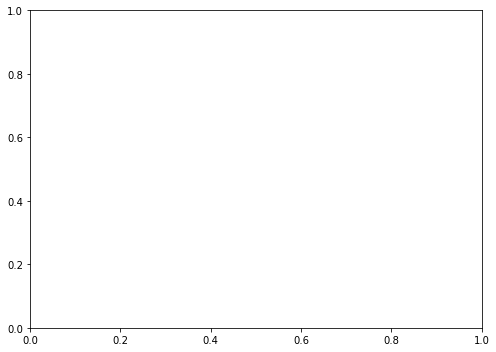

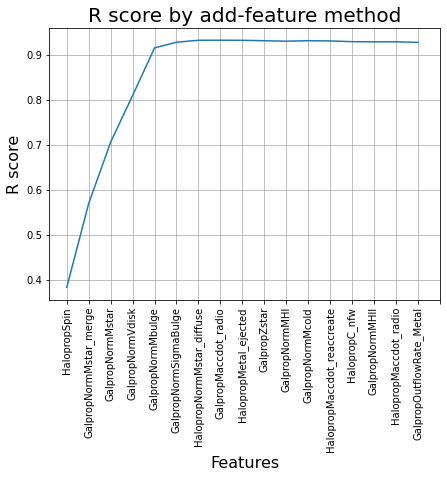

In [23]:
fig, ax = plt.subplots(figsize=(7, 5))

ax = df_max_r_scores.plot(x='features', y='r_sq_score', rot=90, figsize=(7,5), use_index=True,
                   legend=False, grid=True,
                    
                    xticks=range(0,18))

ax.set_title('R score by add-feature method', fontsize=20)
ax.set_xlabel('Features', fontsize=16)
ax.set_ylabel('R score', fontsize=16)

fig.tight_layout()
# plt.savefig('R scores.pdf', dpi=500)

plt.show()

Text(0, 0.5, 'R score')

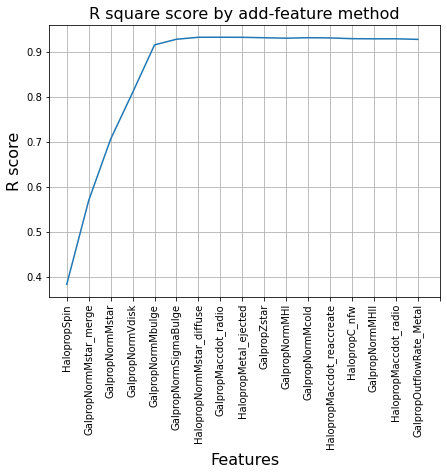

In [34]:
fig_add_feature=df_max_r_scores.plot(x='features', y='r_sq_score', rot=90, figsize=(7,5), use_index=True,
                    legend=False, grid=True,
                    
                    xticks=range(0,18))
fig_add_feature.set_title(label= 'R square score by add-feature method',fontsize=16)
fig_add_feature.set_xlabel('Features',fontsize=16)
fig_add_feature.set_ylabel('R score',fontsize=16)


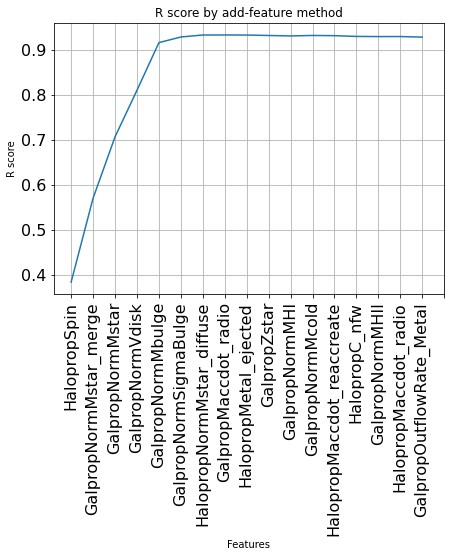

In [30]:
fig_add_feature=df_max_r_scores.plot(x='features', y='r_sq_score', rot=90, figsize=(7,5), use_index=True,
                    title='R score by add-feature method', legend=False, grid=True,
                    xlabel='Features', ylabel = 'R score',
                    xticks=range(0,18), fontsize=16)
# fig_add_feature.set_title(title= 'R square score by add-feature method',pad=20, fontdict={'fontsize':24})
# fig_add_feature.set_ylabel('counts',fontdict={'fontsize':24})

In [35]:
# fig_add_feature.get_figure().savefig('R score by add-feature method.jpg', dpi=500)

### Drop-column Feature Ranking


In [286]:
def run_grid_search_pipeline(X, y, grid, model):
    

    n_estimators = [20,50,100]
    grid = {'bootstrap': [True],
                   'max_depth': [5, 10, None],
    #                'max_features': ['auto', 'sqrt'],
#                    'min_samples_leaf': [1, 2, 4],
    #                'min_samples_split': [2, 5, 10],
                   'n_estimators': n_estimators}
        
#     n_estimators = [int(x) for x in np.linspace(start = 80, stop = 100, num = 1)]
#     grid = {'bootstrap': [True],
#                    'max_depth': [None],
#     #                'max_features': ['auto', 'sqrt'],
#                    'min_samples_leaf': [2],
#     #                'min_samples_split': [2, 5, 10],
#                    'n_estimators': n_estimators}


    model=RandomForestRegressor()

    model = GridSearchCV(model, grid, cv = KFold(n_splits=3, shuffle=True), \
                         verbose = 3, n_jobs = -1, return_train_score=True)
    model.fit(X, y)
#     estimator.get_params().keys()
    scores_lim = pd.DataFrame(reg_RF.cv_results_)

    scores_lim = scores_lim[['params','mean_test_score','std_test_score','mean_train_score', 'mean_fit_time']].sort_values(by = 'mean_test_score', ascending = False)
    
    return scores_lim['mean_test_score']

IndentationError: unexpected indent (3281605974.py, line 5)

In [288]:
X_new_dc=X # X new for drop column

df_grid= pd.DataFrame(columns= X_new_dc.columns)
index = 0
while len(X_new_dc.columns)>=0:
    

    for col_names in tqdm(X_new_dc.columns):
    
        X_changed = X_new_dc.drop(columns=[col_names])
        
        r_square = run_random_search_pipeline(X_changed, y)
        
        df_grid.loc[index,col_names] = r_square.max() # store the corresponding max r_square to the name of the removed column
        
    X_new_dc.drop(columns= [df_grid.iloc[index,:].astype('float64').idxmax()], inplace=True) # drop the column with the highest
    # R^2 value as that means that removing the feature of that coulmn doesn't decrease the performance of the
    # model; hence the features is 'not important'
    
    index+=1
        
    




  0%|                                                    | 0/32 [00:00<?, ?it/s]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


  3%|█▍                                          | 1/32 [01:17<39:52, 77.18s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


  6%|██▊                                         | 2/32 [02:31<37:43, 75.46s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


  9%|████▏                                       | 3/32 [03:44<35:58, 74.44s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 12%|█████▌                                      | 4/32 [04:58<34:38, 74.22s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.984, test=0.904) total time=  30.8s


 16%|██████▉                                     | 5/32 [06:12<33:18, 74.01s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 19%|████████▎                                   | 6/32 [07:25<31:54, 73.64s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 22%|█████████▋                                  | 7/32 [08:38<30:39, 73.58s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 25%|███████████                                 | 8/32 [09:51<29:22, 73.42s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 28%|████████████▍                               | 9/32 [11:04<28:05, 73.26s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.984, test=0.902) total time=  28.6s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.983, test=0.904) total time=  28.9s


 31%|█████████████▍                             | 10/32 [12:17<26:46, 73.01s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 34%|██████████████▊                            | 11/32 [13:29<25:29, 72.82s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.985, test=0.905) total time=  28.8s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.981, test=0.916) total time=  28.8s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.981, test=0.921) total time=  28.9s


 38%|████████████████▏                          | 12/32 [14:42<24:17, 72.85s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 41%|█████████████████▍                         | 13/32 [15:55<23:04, 72.88s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 44%|██████████████████▊                        | 14/32 [17:08<21:52, 72.91s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 47%|████████████████████▏                      | 15/32 [18:21<20:42, 73.11s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 50%|█████████████████████▌                     | 16/32 [19:34<19:28, 73.04s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.984, test=0.911) total time=  28.6s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.982, test=0.915) total time=  29.0s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.982, test=0.913) total time=  28.8s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.982, test=0.905) total time=  28.7s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.983, test=0.914) total time=  28.8s


 53%|██████████████████████▊                    | 17/32 [20:48<18:17, 73.16s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.981, test=0.913) total time=  28.6s


 56%|████████████████████████▏                  | 18/32 [22:10<17:42, 75.92s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.982, test=0.923) total time=  28.6s


 59%|█████████████████████████▌                 | 19/32 [23:23<16:17, 75.16s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 62%|██████████████████████████▉                | 20/32 [24:37<14:55, 74.62s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 66%|████████████████████████████▏              | 21/32 [25:50<13:36, 74.23s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.982, test=0.911) total time=  29.1s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.981, test=0.917) total time=  29.0s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.982, test=0.905) total time=  29.6s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.983, test=0.915) total time=  28.6s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.983, test=0.903) total time=  28.6s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.981, test=0.911) total time=  28.5s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.981, test=0.913) total time=  28.5s
[CV

 69%|█████████████████████████████▌             | 22/32 [27:05<12:24, 74.42s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 72%|██████████████████████████████▉            | 23/32 [28:18<11:06, 74.04s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 75%|████████████████████████████████▎          | 24/32 [29:32<09:51, 73.95s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 78%|█████████████████████████████████▌         | 25/32 [30:45<08:37, 73.86s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 81%|██████████████████████████████████▉        | 26/32 [31:59<07:21, 73.63s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.982, test=0.909) total time=  28.8s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.979, test=0.891) total time=  29.0s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.985, test=0.896) total time=  28.9s


 84%|████████████████████████████████████▎      | 27/32 [33:12<06:07, 73.51s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.978, test=0.907) total time=  29.5s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.984, test=0.906) total time=  29.4s


 88%|█████████████████████████████████████▋     | 28/32 [34:26<04:54, 73.67s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 91%|██████████████████████████████████████▉    | 29/32 [35:42<03:43, 74.53s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 94%|████████████████████████████████████████▎  | 30/32 [36:56<02:28, 74.31s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 97%|█████████████████████████████████████████▋ | 31/32 [38:10<01:14, 74.16s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


  0%|                                                    | 0/31 [00:00<?, ?it/s]

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.982, test=0.907) total time=  28.8s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.982, test=0.915) total time=  29.4s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.981, test=0.914) total time=  29.1s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.984, test=0.900) total time=  29.7s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.981, test=0.916) total time=  32.2s


  3%|█▍                                          | 1/31 [01:13<36:39, 73.31s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.982, test=0.902) total time=  29.2s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.984, test=0.900) total time=  28.8s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.983, test=0.915) total time=  29.5s


  6%|██▊                                         | 2/31 [02:24<34:52, 72.16s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 10%|████▎                                       | 3/31 [03:36<33:38, 72.10s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 13%|█████▋                                      | 4/31 [04:48<32:18, 71.80s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 16%|███████                                     | 5/31 [05:59<31:06, 71.80s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 19%|████████▌                                   | 6/31 [07:10<29:49, 71.57s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.980, test=0.923) total time=  29.4s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.979, test=0.909) total time=  29.5s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.980, test=0.899) total time=  30.1s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.984, test=0.908) total time=  29.3s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.981, test=0.914) total time=  28.6s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.981, test=0.911) total time=  28.6s


 23%|█████████▉                                  | 7/31 [08:22<28:35, 71.47s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 26%|███████████▎                                | 8/31 [09:33<27:23, 71.44s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.984, test=0.903) total time=  28.9s


 29%|████████████▊                               | 9/31 [10:44<26:11, 71.43s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 32%|█████████████▊                             | 10/31 [11:56<24:59, 71.40s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 35%|███████████████▎                           | 11/31 [13:07<23:49, 71.48s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 39%|████████████████▋                          | 12/31 [14:19<22:40, 71.59s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 42%|██████████████████                         | 13/31 [15:32<21:32, 71.81s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.984, test=0.915) total time=  28.2s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.983, test=0.910) total time=  28.3s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.983, test=0.898) total time=  28.6s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.982, test=0.917) total time=  28.8s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.983, test=0.918) total time=  28.3s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.982, test=0.919) total time=  28.4s


 45%|███████████████████▍                       | 14/31 [16:43<20:17, 71.59s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.984, test=0.903) total time=  28.8s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.985, test=0.909) total time=  28.5s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.984, test=0.905) total time=  28.3s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.981, test=0.917) total time=  28.6s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.984, test=0.904) total time=  28.9s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.982, test=0.912) total time=  28.7s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.966, test=0.861) total time=  34.1s
[CV

 48%|████████████████████▊                      | 15/31 [17:55<19:06, 71.66s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 52%|██████████████████████▏                    | 16/31 [19:06<17:53, 71.55s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.981, test=0.895) total time=  29.5s


 55%|███████████████████████▌                   | 17/31 [20:23<17:05, 73.29s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.985, test=0.903) total time=  28.7s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.984, test=0.893) total time=  28.5s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.982, test=0.915) total time=  28.9s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.982, test=0.918) total time=  28.4s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.980, test=0.920) total time=  28.6s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.984, test=0.919) total time=  28.9s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.984, test=0.907) total time=  28.3s


 58%|████████████████████████▉                  | 18/31 [21:34<15:42, 72.54s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 61%|██████████████████████████▎                | 19/31 [22:45<14:26, 72.19s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 65%|███████████████████████████▋               | 20/31 [23:56<13:09, 71.80s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 68%|█████████████████████████████▏             | 21/31 [25:09<12:01, 72.11s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 71%|██████████████████████████████▌            | 22/31 [26:20<10:46, 71.83s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 74%|███████████████████████████████▉           | 23/31 [27:31<09:32, 71.57s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.981, test=0.925) total time=  28.1s


 77%|█████████████████████████████████▎         | 24/31 [28:42<08:19, 71.41s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 81%|██████████████████████████████████▋        | 25/31 [29:53<07:07, 71.27s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.980, test=0.885) total time=  29.1s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.981, test=0.918) total time=  28.4s


 84%|████████████████████████████████████       | 26/31 [31:04<05:56, 71.24s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.982, test=0.906) total time=  31.1s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.983, test=0.908) total time=  28.6s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.981, test=0.921) total time=  28.6s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.981, test=0.915) total time=  28.7s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.983, test=0.915) total time=  28.7s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.984, test=0.902) total time=  28.6s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.985, test=0.903) total time=  28.8s
[CV

 87%|█████████████████████████████████████▍     | 27/31 [32:15<04:44, 71.18s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 90%|██████████████████████████████████████▊    | 28/31 [33:27<03:33, 71.25s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 94%|████████████████████████████████████████▏  | 29/31 [34:38<02:22, 71.28s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.981, test=0.923) total time=  28.1s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.982, test=0.920) total time=  31.0s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.981, test=0.920) total time=  28.6s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.983, test=0.912) total time=  29.3s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.982, test=0.914) total time=  28.7s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.982, test=0.924) total time=  28.5s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.981, test=0.927) total time=  28.6s
[CV

 97%|█████████████████████████████████████████▌ | 30/31 [35:50<01:11, 71.48s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


  0%|                                                    | 0/30 [00:00<?, ?it/s]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


  3%|█▍                                          | 1/30 [01:11<34:19, 71.02s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


  7%|██▉                                         | 2/30 [02:19<32:32, 69.74s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 10%|████▍                                       | 3/30 [03:28<31:05, 69.08s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.982, test=0.913) total time=  28.7s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.982, test=0.914) total time=  29.5s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.982, test=0.919) total time=  28.7s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.983, test=0.907) total time=  28.6s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.984, test=0.910) total time=  28.8s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.982, test=0.899) total time=  29.4s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.981, test=0.921) total time=  28.7s
[CV

 13%|█████▊                                      | 4/30 [04:36<29:51, 68.88s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 17%|███████▎                                    | 5/30 [05:45<28:38, 68.74s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 20%|████████▊                                   | 6/30 [06:53<27:29, 68.74s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 23%|██████████▎                                 | 7/30 [08:02<26:20, 68.73s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 27%|███████████▋                                | 8/30 [09:11<25:11, 68.69s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 30%|█████████████▏                              | 9/30 [10:20<24:03, 68.73s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 33%|██████████████▎                            | 10/30 [11:27<22:47, 68.39s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 37%|███████████████▊                           | 11/30 [12:36<21:39, 68.41s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 40%|█████████████████▏                         | 12/30 [13:44<20:31, 68.39s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 43%|██████████████████▋                        | 13/30 [14:53<19:25, 68.54s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.982, test=0.909) total time=  28.5s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.983, test=0.916) total time=  28.4s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.982, test=0.916) total time=  27.6s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.985, test=0.913) total time=  27.5s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.985, test=0.912) total time=  27.5s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.983, test=0.913) total time=  27.5s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.982, test=0.921) total time=  27.4s


 47%|████████████████████                       | 14/30 [16:02<18:20, 68.75s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 50%|█████████████████████▌                     | 15/30 [17:11<17:11, 68.75s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 53%|██████████████████████▉                    | 16/30 [18:26<16:30, 70.75s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 57%|████████████████████████▎                  | 17/30 [19:35<15:11, 70.11s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 60%|█████████████████████████▊                 | 18/30 [20:44<13:56, 69.72s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 63%|███████████████████████████▏               | 19/30 [21:52<12:41, 69.27s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 67%|████████████████████████████▋              | 20/30 [23:03<11:38, 69.90s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 70%|██████████████████████████████             | 21/30 [24:12<10:24, 69.43s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.969, test=0.849) total time=  30.3s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.981, test=0.891) total time=  27.6s


 73%|███████████████████████████████▌           | 22/30 [25:20<09:12, 69.11s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 77%|████████████████████████████████▉          | 23/30 [26:28<08:02, 68.92s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.980, test=0.920) total time=  28.4s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.981, test=0.907) total time=  28.2s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.978, test=0.902) total time=  28.5s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.982, test=0.919) total time=  28.4s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.981, test=0.928) total time=  28.4s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.984, test=0.885) total time=  28.2s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.983, test=0.910) total time=  28.4s
[CV

 80%|██████████████████████████████████▍        | 24/30 [27:37<06:52, 68.73s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 83%|███████████████████████████████████▊       | 25/30 [28:45<05:43, 68.71s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 87%|█████████████████████████████████████▎     | 26/30 [29:54<04:34, 68.59s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 90%|██████████████████████████████████████▋    | 27/30 [31:02<03:25, 68.51s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 93%|████████████████████████████████████████▏  | 28/30 [32:11<02:17, 68.53s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 97%|█████████████████████████████████████████▌ | 29/30 [33:20<01:08, 68.68s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.967, test=0.857) total time=  30.9s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.983, test=0.918) total time=  28.2s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.984, test=0.904) total time=  28.3s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.983, test=0.913) total time=  28.5s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.983, test=0.902) total time=  28.5s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.982, test=0.912) total time=  28.4s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.982, test=0.909) total time=  28.6s
[CV

  0%|                                                    | 0/29 [00:00<?, ?it/s]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


  3%|█▌                                          | 1/29 [01:08<31:48, 68.18s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


  7%|███                                         | 2/29 [02:14<30:10, 67.07s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 10%|████▌                                       | 3/29 [03:20<28:53, 66.66s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 14%|██████                                      | 4/29 [04:26<27:39, 66.37s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.982, test=0.926) total time=  27.5s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.985, test=0.919) total time=  26.7s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.984, test=0.917) total time=  27.4s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.985, test=0.909) total time=  27.5s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.984, test=0.918) total time=  27.8s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.983, test=0.923) total time=  27.4s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.982, test=0.916) total time=  27.5s
[CV

 17%|███████▌                                    | 5/29 [05:32<26:28, 66.19s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.984, test=0.919) total time=  27.3s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.986, test=0.909) total time=  27.5s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.983, test=0.921) total time=  27.3s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.982, test=0.918) total time=  27.7s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.980, test=0.886) total time=  27.5s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.983, test=0.921) total time=  27.4s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.985, test=0.907) total time=  27.5s
[CV

 21%|█████████                                   | 6/29 [06:39<25:26, 66.37s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 24%|██████████▌                                 | 7/29 [07:46<24:28, 66.76s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.981, test=0.898) total time=  28.7s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.983, test=0.915) total time=  28.7s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.983, test=0.925) total time=  27.6s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.981, test=0.923) total time=  27.5s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.984, test=0.919) total time=  27.5s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.981, test=0.918) total time=  27.7s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.982, test=0.914) total time=  27.7s
[CV

 28%|████████████▏                               | 8/29 [08:53<23:19, 66.63s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 31%|█████████████▋                              | 9/29 [09:58<22:07, 66.37s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 34%|██████████████▊                            | 10/29 [11:03<20:50, 65.82s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.984, test=0.908) total time=  26.3s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.983, test=0.926) total time=  26.4s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.982, test=0.927) total time=  26.4s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.982, test=0.916) total time=  28.1s


 38%|████████████████▎                          | 11/29 [12:09<19:44, 65.79s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 41%|█████████████████▊                         | 12/29 [13:15<18:38, 65.80s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 45%|███████████████████▎                       | 13/29 [14:20<17:33, 65.82s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.981, test=0.923) total time=  26.6s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.984, test=0.920) total time=  26.3s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.985, test=0.911) total time=  26.5s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.985, test=0.913) total time=  26.6s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.984, test=0.924) total time=  25.8s


 48%|████████████████████▊                      | 14/29 [15:26<16:28, 65.89s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 52%|██████████████████████▏                    | 15/29 [16:32<15:22, 65.92s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.984, test=0.913) total time=  26.1s


 55%|███████████████████████▋                   | 16/29 [17:45<14:43, 67.94s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.983, test=0.917) total time=  26.7s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.984, test=0.919) total time=  26.2s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.986, test=0.909) total time=  25.8s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.982, test=0.918) total time=  26.3s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.984, test=0.917) total time=  26.4s


 59%|█████████████████████████▏                 | 17/29 [18:51<13:27, 67.29s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 62%|██████████████████████████▋                | 18/29 [19:57<12:16, 67.00s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 66%|████████████████████████████▏              | 19/29 [21:03<11:05, 66.57s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 69%|█████████████████████████████▋             | 20/29 [22:11<10:04, 67.16s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 72%|███████████████████████████████▏           | 21/29 [23:17<08:54, 66.77s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 76%|████████████████████████████████▌          | 22/29 [24:23<07:45, 66.43s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 79%|██████████████████████████████████         | 23/29 [25:28<06:37, 66.20s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.983, test=0.920) total time=  25.9s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.976, test=0.886) total time=  27.1s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.976, test=0.900) total time=  27.3s


 83%|███████████████████████████████████▌       | 24/29 [26:34<05:30, 66.06s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 86%|█████████████████████████████████████      | 25/29 [27:40<04:23, 65.86s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 90%|██████████████████████████████████████▌    | 26/29 [28:45<03:17, 65.87s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.982, test=0.878) total time=  26.4s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.984, test=0.921) total time=  26.1s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.983, test=0.923) total time=  26.3s


 93%|████████████████████████████████████████   | 27/29 [29:51<02:11, 65.86s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 97%|█████████████████████████████████████████▌ | 28/29 [30:58<01:06, 66.04s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


  0%|                                                    | 0/28 [00:00<?, ?it/s]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


  4%|█▌                                          | 1/28 [01:05<29:38, 65.87s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.983, test=0.918) total time=  27.5s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.986, test=0.908) total time=  27.2s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.983, test=0.921) total time=  27.4s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.983, test=0.915) total time=  27.5s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.984, test=0.914) total time=  27.6s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.982, test=0.928) total time=  27.5s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.983, test=0.904) total time=  27.4s
[CV

  7%|███▏                                        | 2/28 [02:09<27:54, 64.39s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 11%|████▋                                       | 3/28 [03:12<26:33, 63.74s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 14%|██████▎                                     | 4/28 [04:15<25:21, 63.38s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 18%|███████▊                                    | 5/28 [05:18<24:17, 63.36s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 21%|█████████▍                                  | 6/28 [06:21<23:14, 63.40s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 25%|███████████                                 | 7/28 [07:24<22:09, 63.29s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 29%|████████████▌                               | 8/28 [08:28<21:05, 63.27s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.984, test=0.918) total time=  26.3s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.984, test=0.926) total time=  25.4s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.983, test=0.908) total time=  25.0s


 32%|██████████████▏                             | 9/28 [09:31<20:02, 63.27s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 36%|███████████████▎                           | 10/28 [10:33<18:54, 63.03s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 39%|████████████████▉                          | 11/28 [11:37<17:52, 63.07s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 43%|██████████████████▍                        | 12/28 [12:40<16:52, 63.25s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.984, test=0.911) total time=  27.7s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.983, test=0.912) total time=  27.5s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.984, test=0.906) total time=  27.4s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.983, test=0.922) total time=  27.6s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.983, test=0.920) total time=  27.4s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.982, test=0.923) total time=  27.4s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.982, test=0.930) total time=  27.8s
[CV

 46%|███████████████████▉                       | 13/28 [13:43<15:48, 63.21s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 50%|█████████████████████▌                     | 14/28 [14:47<14:48, 63.45s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 54%|███████████████████████                    | 15/28 [15:50<13:43, 63.33s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 57%|████████████████████████▌                  | 16/28 [17:01<13:04, 65.38s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 61%|██████████████████████████                 | 17/28 [18:04<11:52, 64.79s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.982, test=0.920) total time=  26.2s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.980, test=0.907) total time=  27.5s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.986, test=0.914) total time=  25.0s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.983, test=0.927) total time=  25.1s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.982, test=0.913) total time=  25.5s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.985, test=0.912) total time=  25.5s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.984, test=0.917) total time=  25.3s
[CV

 64%|███████████████████████████▋               | 18/28 [19:07<10:44, 64.41s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 68%|█████████████████████████████▏             | 19/28 [20:10<09:35, 63.99s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 71%|██████████████████████████████▋            | 20/28 [21:17<08:37, 64.70s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 75%|████████████████████████████████▎          | 21/28 [22:20<07:29, 64.24s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 79%|█████████████████████████████████▊         | 22/28 [23:23<06:23, 63.91s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.967, test=0.837) total time=  28.9s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.985, test=0.917) total time=  25.9s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.983, test=0.916) total time=  26.1s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.986, test=0.905) total time=  26.3s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.983, test=0.918) total time=  26.5s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.983, test=0.921) total time=  26.0s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.984, test=0.928) total time=  24.8s
[CV

 82%|███████████████████████████████████▎       | 23/28 [24:26<05:18, 63.62s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 86%|████████████████████████████████████▊      | 24/28 [25:29<04:13, 63.42s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.984, test=0.921) total time=  25.8s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.981, test=0.923) total time=  26.1s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.983, test=0.915) total time=  26.2s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.984, test=0.911) total time=  26.4s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.983, test=0.924) total time=  26.2s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.982, test=0.922) total time=  26.2s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.983, test=0.933) total time=  26.0s
[CV

 89%|██████████████████████████████████████▍    | 25/28 [26:32<03:10, 63.36s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.982, test=0.929) total time=  25.5s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.985, test=0.921) total time=  25.6s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.985, test=0.907) total time=  25.0s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.983, test=0.918) total time=  25.2s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.983, test=0.922) total time=  25.3s


 93%|███████████████████████████████████████▉   | 26/28 [27:35<02:06, 63.27s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 96%|█████████████████████████████████████████▍ | 27/28 [28:39<01:03, 63.44s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


  0%|                                                    | 0/27 [00:00<?, ?it/s]

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.983, test=0.912) total time=  25.3s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.985, test=0.915) total time=  25.4s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.983, test=0.934) total time=  24.8s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.983, test=0.932) total time=  25.2s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.983, test=0.920) total time=  25.9s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.968, test=0.832) total time=  27.9s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.985, test=0.920) total time=  25.1s
[CV

  4%|█▋                                          | 1/27 [01:03<27:21, 63.13s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


  7%|███▎                                        | 2/27 [02:04<25:46, 61.85s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 11%|████▉                                       | 3/27 [03:04<24:31, 61.32s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.984, test=0.922) total time=  27.4s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.980, test=0.897) total time=  27.9s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.983, test=0.922) total time=  27.2s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.983, test=0.918) total time=  26.6s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.982, test=0.922) total time=  26.7s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.983, test=0.925) total time=  26.9s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.982, test=0.921) total time=  26.1s
[CV

 15%|██████▌                                     | 4/27 [04:05<23:24, 61.07s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 19%|████████▏                                   | 5/27 [05:06<22:22, 61.02s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 22%|█████████▊                                  | 6/27 [06:07<21:19, 60.94s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 26%|███████████▍                                | 7/27 [07:08<20:18, 60.93s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 30%|█████████████                               | 8/27 [08:08<19:16, 60.89s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.978, test=0.874) total time=  26.4s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.983, test=0.919) total time=  25.3s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.984, test=0.919) total time=  25.2s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.982, test=0.920) total time=  25.4s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.980, test=0.913) total time=  25.4s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.984, test=0.914) total time=  24.5s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.984, test=0.925) total time=  24.3s


 33%|██████████████▋                             | 9/27 [09:08<18:11, 60.62s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 37%|███████████████▉                           | 10/27 [10:09<17:11, 60.66s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 41%|█████████████████▌                         | 11/27 [11:10<16:09, 60.58s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 44%|███████████████████                        | 12/27 [12:10<15:09, 60.62s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.985, test=0.912) total time=  25.2s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.983, test=0.901) total time=  25.2s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.980, test=0.910) total time=  26.2s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.983, test=0.928) total time=  24.5s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.985, test=0.919) total time=  24.4s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.983, test=0.925) total time=  24.2s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.983, test=0.911) total time=  24.6s
[CV

 48%|████████████████████▋                      | 13/27 [13:11<14:09, 60.69s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 52%|██████████████████████▎                    | 14/27 [14:12<13:09, 60.76s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.983, test=0.916) total time=  24.1s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.984, test=0.915) total time=  24.3s


 56%|███████████████████████▉                   | 15/27 [15:19<12:32, 62.71s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 59%|█████████████████████████▍                 | 16/27 [16:20<11:22, 62.04s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 63%|███████████████████████████                | 17/27 [17:21<10:18, 61.89s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 67%|████████████████████████████▋              | 18/27 [18:22<09:13, 61.54s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 70%|██████████████████████████████▎            | 19/27 [19:25<08:16, 62.05s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 74%|███████████████████████████████▊           | 20/27 [20:26<07:10, 61.54s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 78%|█████████████████████████████████▍         | 21/27 [21:26<06:07, 61.17s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 81%|███████████████████████████████████        | 22/27 [22:26<05:03, 60.79s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 85%|████████████████████████████████████▋      | 23/27 [23:26<04:02, 60.75s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.984, test=0.928) total time=  25.1s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.985, test=0.921) total time=  24.4s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.983, test=0.914) total time=  24.5s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.984, test=0.920) total time=  24.1s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.985, test=0.924) total time=  24.1s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.985, test=0.915) total time=  23.9s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.983, test=0.920) total time=  24.4s
[CV

 89%|██████████████████████████████████████▏    | 24/27 [24:27<03:02, 60.69s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 93%|███████████████████████████████████████▊   | 25/27 [25:27<02:01, 60.62s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 96%|█████████████████████████████████████████▍ | 26/27 [26:28<01:00, 60.65s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


  0%|                                                    | 0/26 [00:00<?, ?it/s]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


  4%|█▋                                          | 1/26 [01:01<25:37, 61.52s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


  8%|███▍                                        | 2/26 [02:00<23:54, 59.78s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.981, test=0.914) total time=  26.7s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.981, test=0.907) total time=  27.4s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.986, test=0.908) total time=  24.9s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.984, test=0.926) total time=  24.8s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.982, test=0.929) total time=  25.5s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.982, test=0.931) total time=  25.3s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.978, test=0.899) total time=  25.6s
[CV

 12%|█████                                       | 3/26 [02:57<22:34, 58.90s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 15%|██████▊                                     | 4/26 [03:57<21:42, 59.20s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 19%|████████▍                                   | 5/26 [04:57<20:47, 59.39s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.968, test=0.857) total time=  28.2s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.983, test=0.923) total time=  25.5s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.983, test=0.932) total time=  25.0s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.983, test=0.924) total time=  25.2s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.982, test=0.923) total time=  25.5s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.984, test=0.915) total time=  25.2s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.983, test=0.925) total time=  25.1s
[CV

 23%|██████████▏                                 | 6/26 [05:55<19:41, 59.10s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 27%|███████████▊                                | 7/26 [06:54<18:42, 59.07s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 31%|█████████████▌                              | 8/26 [07:56<17:55, 59.75s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 35%|███████████████▏                            | 9/26 [08:54<16:47, 59.27s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 38%|████████████████▌                          | 10/26 [09:53<15:46, 59.13s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 42%|██████████████████▏                        | 11/26 [10:51<14:43, 58.88s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 46%|███████████████████▊                       | 12/26 [11:49<13:40, 58.61s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 50%|█████████████████████▌                     | 13/26 [12:47<12:39, 58.40s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 54%|███████████████████████▏                   | 14/26 [13:45<11:41, 58.43s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.985, test=0.909) total time=  25.2s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.983, test=0.910) total time=  24.2s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.985, test=0.920) total time=  24.3s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.984, test=0.913) total time=  24.4s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.984, test=0.926) total time=  24.2s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.984, test=0.930) total time=  24.1s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.983, test=0.920) total time=  24.3s
[CV

 58%|████████████████████████▊                  | 15/26 [14:49<11:01, 60.12s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 62%|██████████████████████████▍                | 16/26 [15:47<09:54, 59.41s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 65%|████████████████████████████               | 17/26 [16:45<08:50, 58.98s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 69%|█████████████████████████████▊             | 18/26 [17:45<07:54, 59.32s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 73%|███████████████████████████████▍           | 19/26 [18:43<06:52, 58.86s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 77%|█████████████████████████████████          | 20/26 [19:41<05:51, 58.53s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.983, test=0.922) total time=  24.0s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.982, test=0.915) total time=  24.3s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.985, test=0.918) total time=  23.4s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.983, test=0.921) total time=  24.3s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.984, test=0.920) total time=  23.3s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.983, test=0.919) total time=  23.5s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.984, test=0.925) total time=  23.0s
[CV

 81%|██████████████████████████████████▋        | 21/26 [20:39<04:51, 58.35s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 85%|████████████████████████████████████▍      | 22/26 [21:37<03:52, 58.21s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 88%|██████████████████████████████████████     | 23/26 [22:34<02:54, 58.07s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 92%|███████████████████████████████████████▋   | 24/26 [23:32<01:55, 57.95s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 96%|█████████████████████████████████████████▎ | 25/26 [24:30<00:57, 57.98s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


  0%|                                                    | 0/25 [00:00<?, ?it/s]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


  4%|█▊                                          | 1/25 [00:57<23:06, 57.77s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.983, test=0.920) total time=  24.1s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.984, test=0.916) total time=  24.1s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.969, test=0.841) total time=  27.1s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.980, test=0.901) total time=  24.5s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.974, test=0.899) total time=  25.2s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.984, test=0.926) total time=  24.0s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.981, test=0.909) total time=  24.0s
[CV

  8%|███▌                                        | 2/25 [01:53<21:41, 56.58s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.984, test=0.915) total time=  22.7s


 12%|█████▎                                      | 3/25 [02:49<20:33, 56.09s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 16%|███████                                     | 4/25 [03:44<19:34, 55.92s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 20%|████████▊                                   | 5/25 [04:40<18:36, 55.81s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 24%|██████████▌                                 | 6/25 [05:35<17:39, 55.77s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 28%|████████████▎                               | 7/25 [06:31<16:40, 55.59s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.984, test=0.918) total time=  24.3s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.977, test=0.872) total time=  24.9s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.983, test=0.928) total time=  24.2s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.983, test=0.933) total time=  24.3s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.984, test=0.913) total time=  25.1s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.984, test=0.913) total time=  23.6s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.985, test=0.910) total time=  23.9s
[CV

 32%|██████████████                              | 8/25 [07:26<15:45, 55.60s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 36%|███████████████▊                            | 9/25 [08:21<14:44, 55.29s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.985, test=0.924) total time=  22.9s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.969, test=0.843) total time=  25.5s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.979, test=0.900) total time=  23.0s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.979, test=0.872) total time=  23.8s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.984, test=0.916) total time=  22.7s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.984, test=0.923) total time=  22.6s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.981, test=0.920) total time=  23.6s
[CV

 40%|█████████████████▏                         | 10/25 [09:16<13:50, 55.37s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 44%|██████████████████▉                        | 11/25 [10:12<12:54, 55.30s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 48%|████████████████████▋                      | 12/25 [11:08<12:01, 55.51s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 52%|██████████████████████▎                    | 13/25 [12:03<11:05, 55.43s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 56%|████████████████████████                   | 14/25 [13:04<10:28, 57.18s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.985, test=0.913) total time=  23.4s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.984, test=0.923) total time=  23.8s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.984, test=0.918) total time=  23.0s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.985, test=0.916) total time=  23.0s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.967, test=0.845) total time=  25.7s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.975, test=0.886) total time=  23.6s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.984, test=0.919) total time=  22.8s
[CV

 60%|█████████████████████████▊                 | 15/25 [13:59<09:26, 56.63s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 64%|███████████████████████████▌               | 16/25 [14:55<08:26, 56.30s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 68%|█████████████████████████████▏             | 17/25 [15:53<07:33, 56.70s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 72%|██████████████████████████████▉            | 18/25 [16:48<06:33, 56.26s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 76%|████████████████████████████████▋          | 19/25 [17:43<05:35, 55.96s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 80%|██████████████████████████████████▍        | 20/25 [18:38<04:38, 55.76s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 84%|████████████████████████████████████       | 21/25 [19:34<03:42, 55.64s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 88%|█████████████████████████████████████▊     | 22/25 [20:29<02:46, 55.53s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 92%|███████████████████████████████████████▌   | 23/25 [21:24<01:50, 55.48s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 96%|█████████████████████████████████████████▎ | 24/25 [22:20<00:55, 55.55s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


  0%|                                                    | 0/24 [00:00<?, ?it/s]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


  4%|█▊                                          | 1/24 [00:54<20:54, 54.55s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


  8%|███▋                                        | 2/24 [01:47<19:37, 53.54s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.982, test=0.932) total time=  23.0s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.980, test=0.911) total time=  23.0s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.983, test=0.921) total time=  22.9s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.985, test=0.908) total time=  22.4s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.986, test=0.905) total time=  22.2s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.984, test=0.915) total time=  21.9s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.983, test=0.930) total time=  22.1s
[CV

 12%|█████▌                                      | 3/24 [02:39<18:31, 52.92s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 17%|███████▎                                    | 4/24 [03:31<17:34, 52.72s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 21%|█████████▏                                  | 5/24 [04:24<16:41, 52.70s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 25%|███████████                                 | 6/24 [05:17<15:47, 52.62s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 29%|████████████▊                               | 7/24 [06:09<14:52, 52.49s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 33%|██████████████▋                             | 8/24 [07:01<13:59, 52.50s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 38%|████████████████▌                           | 9/24 [07:54<13:06, 52.42s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 42%|█████████████████▉                         | 10/24 [08:46<12:13, 52.38s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.985, test=0.919) total time=  22.1s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.969, test=0.847) total time=  24.4s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.986, test=0.915) total time=  21.9s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.980, test=0.890) total time=  22.1s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.983, test=0.922) total time=  22.0s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.981, test=0.910) total time=  22.0s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.984, test=0.924) total time=  20.9s
[CV

 46%|███████████████████▋                       | 11/24 [09:39<11:23, 52.60s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 50%|█████████████████████▌                     | 12/24 [10:31<10:30, 52.51s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.984, test=0.925) total time=  21.9s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.984, test=0.930) total time=  21.5s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.983, test=0.925) total time=  21.9s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.982, test=0.920) total time=  21.8s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.983, test=0.931) total time=  21.7s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.966, test=0.848) total time=  24.3s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.983, test=0.929) total time=  21.8s
[CV

 54%|███████████████████████▎                   | 13/24 [11:29<09:54, 54.07s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 58%|█████████████████████████                  | 14/24 [12:21<08:55, 53.54s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 62%|██████████████████████████▉                | 15/24 [13:14<07:59, 53.28s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.982, test=0.910) total time=  25.4s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.984, test=0.930) total time=  23.3s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.985, test=0.919) total time=  22.9s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.984, test=0.926) total time=  23.2s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.984, test=0.919) total time=  25.3s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.984, test=0.927) total time=  23.9s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.983, test=0.920) total time=  23.4s
[CV

 67%|████████████████████████████▋              | 16/24 [14:09<07:10, 53.79s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.986, test=0.922) total time=  20.7s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.983, test=0.931) total time=  20.7s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.986, test=0.925) total time=  20.7s


 71%|██████████████████████████████▍            | 17/24 [15:01<06:13, 53.39s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 75%|████████████████████████████████▎          | 18/24 [15:54<05:18, 53.12s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 79%|██████████████████████████████████         | 19/24 [16:46<04:24, 52.89s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 83%|███████████████████████████████████▊       | 20/24 [17:39<03:31, 52.77s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 88%|█████████████████████████████████████▋     | 21/24 [18:31<02:37, 52.65s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.969, test=0.879) total time=  21.6s


 92%|███████████████████████████████████████▍   | 22/24 [19:24<01:45, 52.63s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 96%|█████████████████████████████████████████▏ | 23/24 [20:16<00:52, 52.58s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


  0%|                                                    | 0/23 [00:00<?, ?it/s]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


  4%|█▉                                          | 1/23 [00:52<19:18, 52.65s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


  9%|███▊                                        | 2/23 [01:43<17:57, 51.31s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 13%|█████▋                                      | 3/23 [02:33<16:55, 50.76s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 17%|███████▋                                    | 4/23 [03:23<15:59, 50.48s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 22%|█████████▌                                  | 5/23 [04:13<15:07, 50.41s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 26%|███████████▍                                | 6/23 [05:03<14:15, 50.35s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 30%|█████████████▍                              | 7/23 [05:53<13:24, 50.28s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 35%|███████████████▎                            | 8/23 [06:44<12:34, 50.27s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 39%|█████████████████▏                          | 9/23 [07:34<11:42, 50.17s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 43%|██████████████████▋                        | 10/23 [08:24<10:52, 50.17s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 48%|████████████████████▌                      | 11/23 [09:14<10:02, 50.19s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 52%|██████████████████████▍                    | 12/23 [10:09<09:28, 51.70s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 57%|████████████████████████▎                  | 13/23 [10:59<08:31, 51.19s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 61%|██████████████████████████▏                | 14/23 [11:49<07:38, 50.92s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 65%|████████████████████████████               | 15/23 [12:42<06:50, 51.35s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 70%|█████████████████████████████▉             | 16/23 [13:32<05:56, 50.96s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 74%|███████████████████████████████▊           | 17/23 [14:22<05:04, 50.70s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 78%|█████████████████████████████████▋         | 18/23 [15:12<04:12, 50.48s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 83%|███████████████████████████████████▌       | 19/23 [16:02<03:21, 50.38s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 87%|█████████████████████████████████████▍     | 20/23 [16:52<02:30, 50.28s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 91%|███████████████████████████████████████▎   | 21/23 [17:42<01:40, 50.22s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 96%|█████████████████████████████████████████▏ | 22/23 [18:33<00:50, 50.27s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


  0%|                                                    | 0/22 [00:00<?, ?it/s]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


  5%|██                                          | 1/22 [00:49<17:26, 49.82s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


  9%|████                                        | 2/22 [01:37<16:15, 48.76s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 14%|██████                                      | 3/22 [02:25<15:15, 48.20s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 18%|████████                                    | 4/22 [03:12<14:23, 47.97s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 23%|██████████                                  | 5/22 [04:00<13:34, 47.93s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 27%|████████████                                | 6/22 [04:48<12:46, 47.88s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 32%|██████████████                              | 7/22 [05:36<11:56, 47.78s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 36%|████████████████                            | 8/22 [06:23<11:08, 47.75s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.982, test=0.931) total time=  22.1s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.983, test=0.927) total time=  21.8s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.983, test=0.920) total time=  21.6s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.984, test=0.925) total time=  21.7s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.978, test=0.913) total time=  22.1s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.983, test=0.929) total time=  21.9s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.983, test=0.932) total time=  21.9s
[CV

 41%|██████████████████                          | 9/22 [07:11<10:20, 47.73s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.983, test=0.926) total time=  21.8s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.975, test=0.880) total time=  22.8s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.982, test=0.930) total time=  22.0s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.981, test=0.916) total time=  21.9s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.986, test=0.917) total time=  20.8s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.984, test=0.936) total time=  20.9s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.984, test=0.921) total time=  20.8s
[CV

 45%|███████████████████▌                       | 10/22 [07:59<09:31, 47.65s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 50%|█████████████████████▌                     | 11/22 [08:47<08:45, 47.77s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 55%|███████████████████████▍                   | 12/22 [09:39<08:13, 49.33s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 59%|█████████████████████████▍                 | 13/22 [10:27<07:19, 48.80s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 64%|███████████████████████████▎               | 14/22 [11:15<06:28, 48.52s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 68%|█████████████████████████████▎             | 15/22 [12:05<05:42, 48.90s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 73%|███████████████████████████████▎           | 16/22 [12:53<04:51, 48.65s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 77%|█████████████████████████████████▏         | 17/22 [13:41<04:02, 48.42s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.985, test=0.914) total time=  21.6s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.985, test=0.916) total time=  21.9s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.980, test=0.912) total time=  22.8s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.986, test=0.925) total time=  20.7s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.984, test=0.922) total time=  20.9s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.984, test=0.932) total time=  20.6s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.985, test=0.924) total time=  21.0s
[CV

 82%|███████████████████████████████████▏       | 18/22 [14:28<03:12, 48.20s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 86%|█████████████████████████████████████▏     | 19/22 [15:16<02:23, 47.98s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 91%|███████████████████████████████████████    | 20/22 [16:03<01:35, 47.88s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.985, test=0.927) total time=  20.7s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.983, test=0.925) total time=  21.0s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.983, test=0.934) total time=  19.8s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.984, test=0.925) total time=  20.1s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.967, test=0.858) total time=  22.2s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.980, test=0.881) total time=  20.0s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.984, test=0.929) total time=  20.0s
[CV

 95%|█████████████████████████████████████████  | 21/22 [16:51<00:47, 47.83s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


  0%|                                                    | 0/21 [00:00<?, ?it/s]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


  5%|██                                          | 1/21 [00:47<15:47, 47.39s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 10%|████▏                                       | 2/21 [01:33<14:40, 46.35s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 14%|██████▎                                     | 3/21 [02:18<13:44, 45.78s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 19%|████████▍                                   | 4/21 [03:03<12:56, 45.69s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 24%|██████████▍                                 | 5/21 [03:48<12:08, 45.53s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 29%|████████████▌                               | 6/21 [04:34<11:22, 45.47s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 33%|██████████████▋                             | 7/21 [05:19<10:35, 45.40s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 38%|████████████████▊                           | 8/21 [06:04<09:49, 45.36s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 43%|██████████████████▊                         | 9/21 [06:50<09:03, 45.32s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.981, test=0.927) total time=  19.8s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.986, test=0.928) total time=  18.7s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.984, test=0.927) total time=  17.9s


 48%|████████████████████▍                      | 10/21 [07:35<08:18, 45.28s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 52%|██████████████████████▌                    | 11/21 [08:20<07:33, 45.39s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 57%|████████████████████████▌                  | 12/21 [09:11<07:02, 46.89s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 62%|██████████████████████████▌                | 13/21 [09:56<06:11, 46.49s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 67%|████████████████████████████▋              | 14/21 [10:44<05:27, 46.77s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 71%|██████████████████████████████▋            | 15/21 [11:29<04:37, 46.32s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 76%|████████████████████████████████▊          | 16/21 [12:14<03:49, 45.96s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 81%|██████████████████████████████████▊        | 17/21 [12:59<03:02, 45.70s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 86%|████████████████████████████████████▊      | 18/21 [13:44<02:16, 45.53s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 90%|██████████████████████████████████████▉    | 19/21 [14:29<01:30, 45.38s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 95%|████████████████████████████████████████▉  | 20/21 [15:15<00:45, 45.47s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


  0%|                                                    | 0/20 [00:00<?, ?it/s]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


  5%|██▏                                         | 1/20 [00:44<14:14, 44.99s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 10%|████▍                                       | 2/20 [01:28<13:09, 43.85s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 15%|██████▌                                     | 3/20 [02:10<12:14, 43.22s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 20%|████████▊                                   | 4/20 [02:53<11:29, 43.07s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 25%|███████████                                 | 5/20 [03:36<10:45, 43.00s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 30%|█████████████▏                              | 6/20 [04:19<10:01, 42.95s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 35%|███████████████▍                            | 7/20 [05:01<09:17, 42.90s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.985, test=0.933) total time=  18.9s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.986, test=0.922) total time=  18.7s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.983, test=0.928) total time=  18.8s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.980, test=0.922) total time=  19.8s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.984, test=0.913) total time=  18.9s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.986, test=0.907) total time=  18.2s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.985, test=0.927) total time=  17.9s
[CV

 40%|█████████████████▌                          | 8/20 [05:44<08:34, 42.86s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 45%|███████████████████▊                        | 9/20 [06:27<07:51, 42.84s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 50%|█████████████████████▌                     | 10/20 [07:10<07:08, 42.80s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 55%|███████████████████████▋                   | 11/20 [07:53<06:26, 42.90s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 60%|█████████████████████████▊                 | 12/20 [08:41<05:54, 44.37s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 65%|███████████████████████████▉               | 13/20 [09:24<05:07, 43.98s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 70%|██████████████████████████████             | 14/20 [10:08<04:25, 44.18s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 75%|████████████████████████████████▎          | 15/20 [10:51<03:38, 43.75s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 80%|██████████████████████████████████▍        | 16/20 [11:34<02:53, 43.44s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 85%|████████████████████████████████████▌      | 17/20 [12:16<02:09, 43.20s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 90%|██████████████████████████████████████▋    | 18/20 [12:59<01:26, 43.08s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 95%|████████████████████████████████████████▊  | 19/20 [13:42<00:43, 43.05s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.986, test=0.920) total time=  20.7s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.984, test=0.932) total time=  19.9s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.985, test=0.929) total time=  19.9s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.986, test=0.921) total time=  19.9s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.986, test=0.919) total time=  19.8s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.977, test=0.902) total time=  19.9s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.984, test=0.919) total time=  19.9s
[CV

  0%|                                                    | 0/19 [00:00<?, ?it/s]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


  5%|██▎                                         | 1/19 [00:42<12:48, 42.68s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 11%|████▋                                       | 2/19 [01:23<11:45, 41.48s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 16%|██████▉                                     | 3/19 [02:03<10:56, 41.01s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 21%|█████████▎                                  | 4/19 [02:44<10:12, 40.80s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 26%|███████████▌                                | 5/19 [03:24<09:29, 40.67s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 32%|█████████████▉                              | 6/19 [04:05<08:47, 40.57s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 37%|████████████████▏                           | 7/19 [04:45<08:06, 40.54s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 42%|██████████████████▌                         | 8/19 [05:25<07:25, 40.51s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 47%|████████████████████▊                       | 9/19 [06:06<06:44, 40.45s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 53%|██████████████████████▋                    | 10/19 [06:46<06:03, 40.39s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 58%|████████████████████████▉                  | 11/19 [07:27<05:23, 40.47s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 63%|███████████████████████████▏               | 12/19 [08:11<04:51, 41.59s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 68%|█████████████████████████████▍             | 13/19 [08:52<04:07, 41.31s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 74%|███████████████████████████████▋           | 14/19 [09:37<03:32, 42.50s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 79%|█████████████████████████████████▉         | 15/19 [10:17<02:47, 41.88s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 84%|████████████████████████████████████▏      | 16/19 [10:57<02:04, 41.39s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 89%|██████████████████████████████████████▍    | 17/19 [11:38<01:22, 41.04s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.984, test=0.923) total time=  24.2s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.983, test=0.910) total time=  24.0s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.985, test=0.908) total time=  23.8s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.983, test=0.909) total time=  24.0s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.981, test=0.907) total time=  25.5s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.983, test=0.923) total time=  23.1s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.985, test=0.909) total time=  23.6s
[CV

 95%|████████████████████████████████████████▋  | 18/19 [12:18<00:40, 40.73s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


  0%|                                                    | 0/18 [00:00<?, ?it/s]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


  6%|██▍                                         | 1/18 [00:40<11:26, 40.41s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.983, test=0.919) total time=  18.0s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.985, test=0.927) total time=  16.8s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.985, test=0.932) total time=  17.0s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.973, test=0.848) total time=  17.6s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.986, test=0.926) total time=  16.9s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.981, test=0.910) total time=  17.7s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.985, test=0.936) total time=  16.1s
[CV

 11%|████▉                                       | 2/18 [01:19<10:32, 39.53s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 17%|███████▎                                    | 3/18 [01:57<09:42, 38.85s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 22%|█████████▊                                  | 4/18 [02:35<09:00, 38.62s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 28%|████████████▏                               | 5/18 [03:14<08:20, 38.53s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 33%|██████████████▋                             | 6/18 [03:52<07:41, 38.43s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 39%|█████████████████                           | 7/18 [04:30<07:02, 38.39s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 44%|███████████████████▌                        | 8/18 [05:08<06:22, 38.30s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 50%|██████████████████████                      | 9/18 [05:46<05:44, 38.23s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 56%|███████████████████████▉                   | 10/18 [06:25<05:06, 38.32s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 61%|██████████████████████████▎                | 11/18 [07:06<04:35, 39.35s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 67%|████████████████████████████▋              | 12/18 [07:45<03:54, 39.06s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 72%|███████████████████████████████            | 13/18 [08:28<03:20, 40.17s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 78%|█████████████████████████████████▍         | 14/18 [09:06<02:38, 39.56s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 83%|███████████████████████████████████▊       | 15/18 [09:44<01:57, 39.14s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 89%|██████████████████████████████████████▏    | 16/18 [10:22<01:17, 38.84s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 94%|████████████████████████████████████████▌  | 17/18 [11:00<00:38, 38.52s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


  0%|                                                    | 0/17 [00:00<?, ?it/s]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


  6%|██▌                                         | 1/17 [00:38<10:09, 38.09s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 12%|█████▏                                      | 2/17 [01:14<09:13, 36.89s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 18%|███████▊                                    | 3/17 [01:50<08:29, 36.42s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 24%|██████████▎                                 | 4/17 [02:25<07:50, 36.18s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.964, test=0.837) total time=  18.7s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.984, test=0.938) total time=  16.9s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.980, test=0.923) total time=  17.8s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.986, test=0.921) total time=  16.0s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.985, test=0.943) total time=  16.0s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.984, test=0.925) total time=  16.1s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.984, test=0.933) total time=  16.1s
[CV

 29%|████████████▉                               | 5/17 [03:01<07:12, 36.07s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 35%|███████████████▌                            | 6/17 [03:37<06:36, 36.04s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 41%|██████████████████                          | 7/17 [04:13<06:00, 36.01s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 47%|████████████████████▋                       | 8/17 [04:49<05:23, 35.96s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 53%|███████████████████████▎                    | 9/17 [05:25<04:47, 35.89s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 59%|█████████████████████████▎                 | 10/17 [06:01<04:12, 36.11s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 65%|███████████████████████████▊               | 11/17 [06:41<03:42, 37.11s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 71%|██████████████████████████████▎            | 12/17 [07:17<03:04, 36.83s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 76%|████████████████████████████████▉          | 13/17 [07:57<02:31, 37.89s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 82%|███████████████████████████████████▍       | 14/17 [08:33<01:51, 37.26s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 88%|█████████████████████████████████████▉     | 15/17 [09:09<01:13, 36.81s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 94%|████████████████████████████████████████▍  | 16/17 [09:44<00:36, 36.46s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


  0%|                                                    | 0/16 [00:00<?, ?it/s]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


  6%|██▊                                         | 1/16 [00:35<08:55, 35.70s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 12%|█████▌                                      | 2/16 [01:09<08:03, 34.54s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 19%|████████▎                                   | 3/16 [01:42<07:22, 34.02s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 25%|███████████                                 | 4/16 [02:16<06:45, 33.80s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 31%|█████████████▊                              | 5/16 [02:49<06:10, 33.68s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 38%|████████████████▌                           | 6/16 [03:23<05:35, 33.56s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 44%|███████████████████▎                        | 7/16 [03:56<05:01, 33.50s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 50%|██████████████████████                      | 8/16 [04:29<04:27, 33.44s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 56%|████████████████████████▊                   | 9/16 [05:03<03:54, 33.55s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 62%|██████████████████████████▉                | 10/16 [05:41<03:29, 34.98s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 69%|█████████████████████████████▌             | 11/16 [06:15<02:53, 34.60s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.985, test=0.926) total time=  15.9s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.983, test=0.925) total time=  16.1s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.962, test=0.856) total time=  17.6s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.984, test=0.933) total time=  16.1s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.985, test=0.932) total time=  16.0s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.983, test=0.932) total time=  16.0s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.981, test=0.905) total time=  16.8s
[CV

 75%|████████████████████████████████▎          | 12/16 [06:53<02:22, 35.52s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 81%|██████████████████████████████████▉        | 13/16 [07:26<01:44, 34.88s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 88%|█████████████████████████████████████▋     | 14/16 [07:59<01:08, 34.45s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 94%|████████████████████████████████████████▎  | 15/16 [08:33<00:34, 34.03s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


  0%|                                                    | 0/15 [00:00<?, ?it/s]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


  7%|██▉                                         | 1/15 [00:33<07:47, 33.37s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 13%|█████▊                                      | 2/15 [01:04<06:59, 32.26s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 20%|████████▊                                   | 3/15 [01:36<06:22, 31.87s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 27%|███████████▋                                | 4/15 [02:07<05:47, 31.61s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 33%|██████████████▋                             | 5/15 [02:38<05:14, 31.43s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 40%|█████████████████▌                          | 6/15 [03:09<04:41, 31.28s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 47%|████████████████████▌                       | 7/15 [03:40<04:09, 31.17s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 53%|███████████████████████▍                    | 8/15 [04:12<03:39, 31.30s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 60%|██████████████████████████▍                 | 9/15 [04:46<03:14, 32.34s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 67%|████████████████████████████▋              | 10/15 [05:18<02:40, 32.01s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 73%|███████████████████████████████▌           | 11/15 [05:53<02:11, 32.93s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 80%|██████████████████████████████████▍        | 12/15 [06:24<01:37, 32.39s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 87%|█████████████████████████████████████▎     | 13/15 [06:55<01:03, 31.99s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 93%|████████████████████████████████████████▏  | 14/15 [07:26<00:31, 31.62s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


  0%|                                                    | 0/14 [00:00<?, ?it/s]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


  7%|███▏                                        | 1/14 [00:31<06:44, 31.13s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 14%|██████▎                                     | 2/14 [01:00<06:00, 30.03s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 21%|█████████▍                                  | 3/14 [01:29<05:23, 29.43s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 29%|████████████▌                               | 4/14 [01:57<04:51, 29.18s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.987, test=0.929) total time=  12.3s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.984, test=0.928) total time=  12.3s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.974, test=0.885) total time=  12.4s


 36%|███████████████▋                            | 5/14 [02:26<04:21, 29.03s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 43%|██████████████████▊                         | 6/14 [02:55<03:51, 28.99s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 50%|██████████████████████                      | 7/14 [03:25<03:24, 29.20s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 57%|█████████████████████████▏                  | 8/14 [03:57<03:00, 30.08s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 64%|████████████████████████████▎               | 9/14 [04:26<02:28, 29.74s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 71%|██████████████████████████████▋            | 10/14 [04:58<02:02, 30.54s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 79%|█████████████████████████████████▊         | 11/14 [05:27<01:30, 30.02s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 86%|████████████████████████████████████▊      | 12/14 [05:56<00:59, 29.66s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 93%|███████████████████████████████████████▉   | 13/14 [06:24<00:29, 29.34s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


  0%|                                                    | 0/13 [00:00<?, ?it/s]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


  8%|███▍                                        | 1/13 [00:28<05:43, 28.67s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 15%|██████▊                                     | 2/13 [00:55<05:03, 27.55s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 23%|██████████▏                                 | 3/13 [01:21<04:30, 27.02s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 31%|█████████████▌                              | 4/13 [01:48<04:00, 26.75s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 38%|████████████████▉                           | 5/13 [02:14<03:33, 26.63s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 46%|████████████████████▎                       | 6/13 [02:41<03:06, 26.69s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 54%|███████████████████████▋                    | 7/13 [03:11<02:46, 27.80s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 62%|███████████████████████████                 | 8/13 [03:38<02:17, 27.41s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 69%|██████████████████████████████▍             | 9/13 [04:07<01:52, 28.04s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 77%|█████████████████████████████████          | 10/13 [04:33<01:22, 27.53s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 85%|████████████████████████████████████▍      | 11/13 [05:00<00:54, 27.18s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 92%|███████████████████████████████████████▋   | 12/13 [05:26<00:26, 26.91s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


  0%|                                                    | 0/12 [00:00<?, ?it/s]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


  8%|███▋                                        | 1/12 [00:26<04:51, 26.46s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 17%|███████▎                                    | 2/12 [00:50<04:12, 25.30s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 25%|███████████                                 | 3/12 [01:14<03:42, 24.68s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 33%|██████████████▋                             | 4/12 [01:38<03:15, 24.44s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 42%|██████████████████▎                         | 5/12 [02:02<02:49, 24.26s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 50%|██████████████████████                      | 6/12 [02:27<02:25, 24.33s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.986, test=0.927) total time=  15.3s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.987, test=0.930) total time=  15.0s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.984, test=0.923) total time=  15.1s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.985, test=0.919) total time=  15.2s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.966, test=0.834) total time=  16.6s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.956, test=0.790) total time=  16.9s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.984, test=0.940) total time=  15.1s
[CV

 58%|█████████████████████████▋                  | 7/12 [02:57<02:11, 26.20s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 67%|█████████████████████████████▎              | 8/12 [03:21<01:42, 25.58s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 75%|█████████████████████████████████           | 9/12 [03:48<01:17, 25.95s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 83%|███████████████████████████████████▊       | 10/12 [04:12<00:50, 25.33s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 92%|███████████████████████████████████████▍   | 11/12 [04:36<00:24, 24.88s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


  0%|                                                    | 0/11 [00:00<?, ?it/s]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


  9%|████                                        | 1/11 [00:24<04:02, 24.23s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 18%|████████                                    | 2/11 [00:46<03:26, 22.94s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 27%|████████████                                | 3/11 [01:07<02:58, 22.33s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 36%|████████████████                            | 4/11 [01:29<02:34, 22.01s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 45%|████████████████████                        | 5/11 [01:51<02:12, 22.03s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 55%|████████████████████████                    | 6/11 [02:18<01:57, 23.59s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 64%|████████████████████████████                | 7/11 [02:39<01:31, 23.00s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 73%|████████████████████████████████            | 8/11 [03:03<01:09, 23.28s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 82%|████████████████████████████████████        | 9/11 [03:25<00:45, 22.73s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 91%|███████████████████████████████████████    | 10/11 [03:46<00:22, 22.33s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


  0%|                                                    | 0/10 [00:00<?, ?it/s]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 10%|████▍                                       | 1/10 [00:21<03:13, 21.45s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 20%|████████▊                                   | 2/10 [00:41<02:43, 20.41s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 30%|█████████████▏                              | 3/10 [01:00<02:18, 19.81s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 40%|█████████████████▌                          | 4/10 [01:19<01:57, 19.54s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 50%|██████████████████████                      | 5/10 [01:39<01:37, 19.58s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 60%|██████████████████████████▍                 | 6/10 [02:03<01:24, 21.21s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 70%|██████████████████████████████▊             | 7/10 [02:22<01:01, 20.58s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 80%|███████████████████████████████████▏        | 8/10 [02:43<00:41, 20.69s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 90%|███████████████████████████████████████▌    | 9/10 [03:02<00:20, 20.19s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


  0%|                                                     | 0/9 [00:00<?, ?it/s]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 11%|█████                                        | 1/9 [00:19<02:32, 19.07s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 22%|██████████                                   | 2/9 [00:36<02:06, 18.01s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 33%|███████████████                              | 3/9 [00:53<01:44, 17.42s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 44%|████████████████████                         | 4/9 [01:10<01:26, 17.36s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 56%|█████████████████████████                    | 5/9 [01:31<01:15, 18.81s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 67%|██████████████████████████████               | 6/9 [01:49<00:54, 18.32s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 78%|███████████████████████████████████          | 7/9 [02:07<00:36, 18.35s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 89%|████████████████████████████████████████     | 8/9 [02:24<00:17, 17.81s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


  0%|                                                     | 0/8 [00:00<?, ?it/s]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 12%|█████▋                                       | 1/8 [00:17<02:00, 17.25s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 25%|███████████▎                                 | 2/8 [00:32<01:35, 15.99s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 38%|████████████████▉                            | 3/8 [00:47<01:17, 15.50s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 50%|██████████████████████▌                      | 4/8 [01:06<01:07, 16.87s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 62%|████████████████████████████▏                | 5/8 [01:21<00:49, 16.34s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 75%|█████████████████████████████████▊           | 6/8 [01:37<00:32, 16.33s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 88%|███████████████████████████████████████▍     | 7/8 [01:52<00:15, 15.83s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


  0%|                                                     | 0/7 [00:00<?, ?it/s]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 14%|██████▍                                      | 1/7 [00:15<01:30, 15.08s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 29%|████████████▊                                | 2/7 [00:27<01:08, 13.72s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 43%|███████████████████▎                         | 3/7 [00:43<00:58, 14.73s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 57%|█████████████████████████▋                   | 4/7 [00:57<00:42, 14.15s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 71%|████████████████████████████████▏            | 5/7 [01:11<00:28, 14.10s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 86%|██████████████████████████████████████▌      | 6/7 [01:23<00:13, 13.65s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


  0%|                                                     | 0/6 [00:00<?, ?it/s]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 17%|███████▌                                     | 1/6 [00:12<01:04, 12.80s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 33%|███████████████                              | 2/6 [00:25<00:51, 12.85s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 50%|██████████████████████▌                      | 3/6 [00:36<00:35, 11.99s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 67%|██████████████████████████████               | 4/6 [00:48<00:24, 12.09s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 83%|█████████████████████████████████████▌       | 5/6 [00:59<00:11, 11.47s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


  0%|                                                     | 0/5 [00:00<?, ?it/s]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 20%|█████████                                    | 1/5 [00:12<00:51, 12.80s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 40%|██████████████████                           | 2/5 [00:23<00:35, 11.68s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 60%|███████████████████████████                  | 3/5 [00:35<00:23, 11.88s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 80%|████████████████████████████████████         | 4/5 [00:46<00:11, 11.28s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 25%|███████████▎                                 | 1/4 [00:09<00:28,  9.56s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 50%|██████████████████████▌                      | 2/4 [00:17<00:17,  8.89s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 75%|█████████████████████████████████▊           | 3/4 [00:27<00:09,  9.33s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


  0%|                                                     | 0/3 [00:00<?, ?it/s]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 33%|███████████████                              | 1/3 [00:07<00:15,  7.72s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 67%|██████████████████████████████               | 2/3 [00:14<00:07,  7.02s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


  0%|                                                     | 0/2 [00:00<?, ?it/s]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 50%|██████████████████████▌                      | 1/2 [00:03<00:03,  3.68s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


  0%|                                                     | 0/1 [00:00<?, ?it/s]/Users/festabu/miniforge3/envs/native/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
3 fits failed out of a total of 3.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/festabu/miniforge3/envs/native/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/festabu/miniforge3/envs/native/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 327, in fit
    X, y = self._validate_data(
  File "/Users/festabu/miniforge3/

Fitting 3 folds for each of 1 candidates, totalling 3 fits


ValueError: at least one array or dtype is required

[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.987, test=0.914) total time=  19.0s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.984, test=0.929) total time=  18.9s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.984, test=0.929) total time=  19.0s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.984, test=0.932) total time=  18.6s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.986, test=0.923) total time=  17.9s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.986, test=0.921) total time=  18.0s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.985, test=0.924) total time=  18.1s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=

[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.986, test=0.921) total time=  18.0s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.985, test=0.922) total time=  18.1s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.984, test=0.931) total time=  18.0s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.984, test=0.935) total time=  18.1s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.984, test=0.928) total time=  18.2s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.985, test=0.922) total time=  17.9s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.984, test=0.928) total time=  17.8s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=

[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.985, test=0.937) total time=   9.4s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.985, test=0.927) total time=   8.5s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.986, test=0.928) total time=   8.4s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.983, test=0.911) total time=   9.1s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.986, test=0.941) total time=   7.8s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.985, test=0.940) total time=   7.7s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.860, test=0.403) total time=   9.6s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=

[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.984, test=0.934) total time=  14.4s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.963, test=0.845) total time=  15.5s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.985, test=0.935) total time=  14.1s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.984, test=0.931) total time=  14.1s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.984, test=0.936) total time=  14.1s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.984, test=0.929) total time=  13.2s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.985, test=0.932) total time=  13.2s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=

In [289]:
df_grid

,GalpropMaccdot,GalpropMaccdot_radio,GalpropMu_merger,GalpropOutflowRate_Mass,GalpropOutflowRate_Metal,GalpropSfr,GalpropSfrave100myr,GalpropSfrave1gyr,GalpropSfrave20myr,GalpropTmerger,...,GalpropNormMBH,GalpropNormMH2,GalpropNormMHI,GalpropNormMHII,GalpropNormMcold,GalpropNormMstar_merge,HalopropNormMass_ejected,HalopropNormMstar_diffuse,GalpropNormSigmaBulge,GalpropNormVdisk
0,0.910083,0.911599,0.909864,0.912451,0.910351,0.911849,0.914001,0.91229,0.912136,0.91591,...,0.907818,0.911314,0.910265,0.911986,0.913372,0.910099,0.911091,0.912435,0.901968,0.899082
1,0.910278,0.911581,0.911843,0.913862,0.911592,0.910449,0.910781,0.913858,0.913697,0.917443,...,0.914682,0.91696,0.908407,0.911544,0.911285,0.909054,0.90948,0.912213,0.9016,0.900202
2,0.917223,0.917216,0.919193,0.917774,0.914588,0.914546,0.913639,0.91665,0.914997,NaN,...,0.916807,0.921532,0.919994,0.916428,0.918468,0.915528,0.917978,0.916598,0.904545,0.908451
3,0.914814,0.916615,0.9164,0.917433,0.917409,0.916208,0.918536,0.918331,0.919163,NaN,...,0.915226,NaN,0.920144,0.919722,0.917508,0.920727,0.918799,0.914507,0.906116,0.905351
4,0.918457,0.918429,0.922524,0.919207,0.918806,0.918533,0.917372,0.918917,0.917847,NaN,...,0.919726,NaN,0.919387,0.918362,0.916874,NaN,0.91658,0.911748,0.907408,0.907695
5,0.920957,0.921529,NaN,0.918042,0.920075,0.918437,0.91909,0.919057,0.922383,NaN,...,0.921864,NaN,0.918108,0.920638,0.918633,NaN,0.918957,0.916127,0.90928,0.90793
6,0.920073,0.920731,NaN,0.922487,0.91818,0.918435,0.919199,0.921651,0.919088,NaN,...,0.922969,NaN,0.921476,0.92154,0.919306,NaN,0.921221,0.914945,0.90708,0.912338
7,0.921497,0.921303,NaN,0.921613,0.915787,0.92305,0.920336,0.920207,0.921927,NaN,...,0.923131,NaN,0.91948,0.921919,0.920019,NaN,0.921865,0.916164,0.911179,0.911059
8,0.923947,0.924515,NaN,0.926789,0.925173,0.923396,0.926489,0.923806,0.92621,NaN,...,0.926268,NaN,0.924905,0.924902,0.926022,NaN,0.925372,0.925228,0.914633,0.910052
9,0.925131,0.923388,NaN,0.925439,0.9256,0.924169,0.924426,0.925358,0.92665,NaN,...,0.925055,NaN,0.923973,0.9276,0.924032,NaN,0.924965,0.926167,0.912137,0.912215


In [313]:
df_grid[df_grid.iloc[index,:].astype('float64').idxmax()]

0     0.91597
1         NaN
2         NaN
3         NaN
4         NaN
5         NaN
6         NaN
7         NaN
8         NaN
9         NaN
10        NaN
11        NaN
12        NaN
13        NaN
14        NaN
15        NaN
16        NaN
17        NaN
18        NaN
19        NaN
20        NaN
21        NaN
22        NaN
23        NaN
24        NaN
25        NaN
26        NaN
27        NaN
28        NaN
29        NaN
30        NaN
Name: HalopropMaccdot_reaccreate, dtype: object

In [295]:
df_grid.iloc[1,:].astype('float64').idxmax()

'GalpropTmerger'

In [298]:
df_grid_ranking= pd.DataFrame(columns= df_grid.columns)
index = 0

for column_names in df_grid.columns:
    df_grid_ranking.loc[index,column_names] = df_grid.iloc[index,:].astype('float64').idxmax()     

    

In [299]:
df_grid_ranking

,GalpropMaccdot,GalpropMaccdot_radio,GalpropMu_merger,GalpropOutflowRate_Mass,GalpropOutflowRate_Metal,GalpropSfr,GalpropSfrave100myr,GalpropSfrave1gyr,GalpropSfrave20myr,GalpropTmerger,...,GalpropNormMBH,GalpropNormMH2,GalpropNormMHI,GalpropNormMHII,GalpropNormMcold,GalpropNormMstar_merge,HalopropNormMass_ejected,HalopropNormMstar_diffuse,GalpropNormSigmaBulge,GalpropNormVdisk
0,HalopropMaccdot_reaccreate,HalopropMaccdot_reaccreate,HalopropMaccdot_reaccreate,HalopropMaccdot_reaccreate,HalopropMaccdot_reaccreate,HalopropMaccdot_reaccreate,HalopropMaccdot_reaccreate,HalopropMaccdot_reaccreate,HalopropMaccdot_reaccreate,HalopropMaccdot_reaccreate,...,HalopropMaccdot_reaccreate,HalopropMaccdot_reaccreate,HalopropMaccdot_reaccreate,HalopropMaccdot_reaccreate,HalopropMaccdot_reaccreate,HalopropMaccdot_reaccreate,HalopropMaccdot_reaccreate,HalopropMaccdot_reaccreate,HalopropMaccdot_reaccreate,HalopropMaccdot_reaccreate


In [309]:
df_grid.loc[1, 'GalpropMaccdot']

0.9102784264413332

In [290]:
# df_grid.to_csv('R scores by DROP column and GRIDSearchCV feature elimination method.csv', index=False)

## <font color='blue'> 2.c. Random Forest (RF) - Halo features only


In [45]:
# El for features after elimination
X_el = df_normalized.loc[:, ['HalopropC_nfw', 'HalopropSpin']]

y_el = df_normalized.loc[:,'GalpropNormHalfRadius']

In [50]:
# X_train_el, X_test_el, y_train_el, y_test_el = train_test_split(X_el, y_el, test_size=0.33, random_state=42)

regr_el = RandomForestRegressor(random_state=0)

# number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 100, num = 3)]
# number of features at every split
# max_features = ['auto', 'sqrt']


# create random grid
grid = {'bootstrap': [True],
               'max_depth': [5, 10, None],
#                'max_features': ['auto', 'sqrt'],
               'min_samples_leaf': [1, 2, 4],
#                'min_samples_split': [2, 5, 10],
               'n_estimators': n_estimators}
# Random search of parameters
rfr_grid_el = GridSearchCV(estimator = regr_el, param_grid = grid, cv = 3, verbose=1, n_jobs = -1,
                           return_train_score=True)
# Fit the model
rfr_grid_el.fit(X_el, y_el)
# print results
print(rfr_grid_el.best_params_)

Fitting 3 folds for each of 27 candidates, totalling 81 fits
{'bootstrap': True, 'max_depth': 5, 'min_samples_leaf': 1, 'n_estimators': 100}


In [51]:
best_RF_el=rfr_grid_el.best_estimator_ # The index (of the cv_results_ arrays) which corresponds to the best candidate parameter setting.

In [53]:
rfr_grid_el.cv_results_['mean_train_score'][rfr_grid_el.best_index_]

0.4340086124151437

In [54]:
best_RF_trainscore_el=rfr_grid_el.cv_results_['mean_train_score'][rfr_grid_el.best_index_]

In [55]:
#  y_pred = rfr_grid.best_estimator_.predict(X_test)
y_pred_RF_el = cross_val_predict(rfr_grid_el.best_estimator_, X_el, y_el, cv = KFold(n_splits=5, shuffle=True, random_state=10))

In [56]:
scores_RF_el = cross_val_score(best_RF_el, X_el, y_el, cv = KFold(n_splits=5, shuffle=True, random_state=10))

In [115]:
print("Accuracy: %0.2f (+/- %0.2f)" % (scores_RF_el.mean(), scores_RF_el.std() * 2))

Accuracy: 0.40 (+/- 0.03)


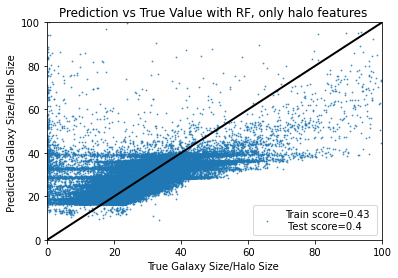

In [58]:
label = 'Train score={} \n Test score={}'.format(round(best_RF_trainscore_el, 2),round(scores_RF_el.mean(), 2) )

# label = 'Train score={} \n Test score={}'.format(round(rfr_grid_el.best_estimator_.score(X_train_el, y_train_el), 2),round(rfr_grid_el.score(X_test_el, y_test_el), 2) )
plt.scatter(y_el, y_pred_RF_el, s=3, marker='.', alpha=0.7, label=label)
plt.axis([0.0,100, 0.0,100])
plt.plot([0.0, 170], [0.0, 170], color = 'black', linewidth = 2)
plt.title('Prediction vs True Value with RF, only halo features ')
plt.xlabel('True Galaxy Size/Halo Size ')
plt.ylabel(' Predicted Galaxy Size/Halo Size  ')
plt.legend(loc='lower right')
# plt.savefig('TNG-SAM_Prediction_vs_True_with_halo_features.jpeg', dpi=500)
plt.show()

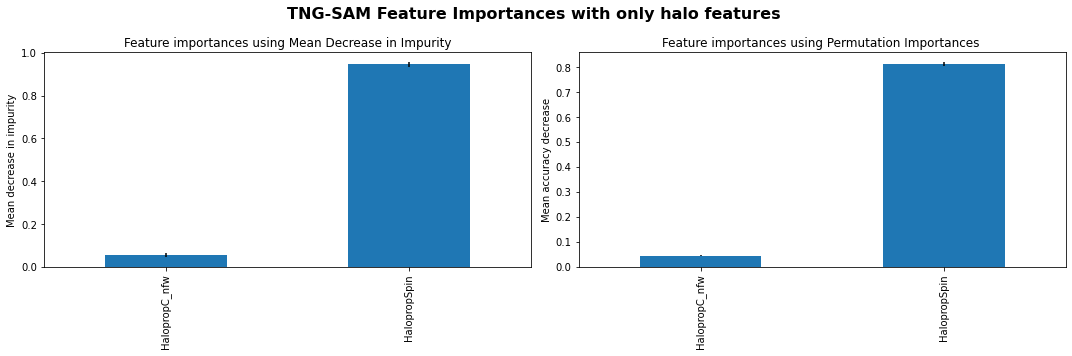

In [61]:
start_time = time.time()
importances_el = rfr_grid_el.best_estimator_.feature_importances_
std_el = np.std([tree.feature_importances_ for tree in rfr_grid_el.best_estimator_.estimators_], axis=0)
elapsed_time = time.time() - start_time

feature_names_el = X_el.columns

forest_importances_el = pd.Series(importances_el, index=feature_names_el)

fig, [ax1, ax2] = plt.subplots(1,2, figsize=(15,5))
fig.suptitle('TNG-SAM Feature Importances with only halo features ', fontsize=16, fontweight='bold')

forest_importances_el.plot.bar(yerr=std_el, ax=ax1)
ax1.set_title("Feature importances using Mean Decrease in Impurity")
ax1.set_ylabel("Mean decrease in impurity")
# plt.savefig("Feature_Importances_MDI.jpeg", dpi=500)

### Feature Importances Permutation

start_time = time.time()
result_el = permutation_importance(
    rfr_grid_el.best_estimator_, X_el, y_el, n_repeats=10, random_state=0, n_jobs=-1
)
elapsed_time = time.time() - start_time
# print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

forest_importances_el = pd.Series(result_el.importances_mean, index=feature_names_el)

forest_importances_el.plot.bar(yerr=result_el.importances_std, ax=ax2)
ax2.set_title("Feature importances using Permutation Importances ")
ax2.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
# plt.savefig("TNG-SAM_Feature_Importances_Permutation_halo_features.jpeg", dpi=500)

plt.show()

In [62]:
df_perm_import_el=pd.DataFrame(forest_importances_el)

In [63]:
df_perm_import_el.sort_values(0, ascending=False)

,0
HalopropSpin,0.810800
HalopropC_nfw,0.045557


## <font color='blue'> 3.a. Support Vector Machine (SVM) - all features

In [ ]:
start_time = time.time()

piped_model = make_pipeline(StandardScaler(), SVR()) #non linear so I can change the kernel

piped_model.get_params() #this shows how we can access parameters both for the scaler and the classifier

#optimizing SVR

parameters = {'svr__kernel':['poly', 'rbf'], \
              'svr__gamma':['scale', 0.01, 0.1], 'svr__C':[1.0, 10, 100, 1000], \
              'svr__degree': [2, 3]}

# parameters = {'svr__kernel':['rbf'], \
#               'svr__gamma':['scale'], 'svr__C':[100], \
#               'svr__degree': [2]}

model = GridSearchCV(piped_model, parameters, cv = KFold(n_splits=3, shuffle=True), \
                     verbose = 3, n_jobs = -1, return_train_score=True)

model.fit(X, y)

print('Best params, best score:', "{:.4f}".format(model.best_score_), \
      model.best_params_)

elapsed_time = time.time() - start_time
print(f"Elapsed time to compute the GridSearchCV for SVR: {elapsed_time:.3f} seconds")

#### From the SVR Gridsearch in the line above (125 fits (87%) out of 144), the best parameters are: C=1000, gamma=scale, kernel=rbf (gaussian), train score=0.954, test score=0.926



In [64]:
start_time = time.time()

piped_model = make_pipeline(StandardScaler(), SVR()) #non linear so I can change the kernel

piped_model.get_params() #this shows how we can access parameters both for the scaler and the classifier

#optimizing SVR

parameters = {'svr__kernel':['rbf'], \
              'svr__gamma':['scale'], 'svr__C':[1000], \
              }


model = GridSearchCV(piped_model, parameters, cv = KFold(n_splits=3, shuffle=True), \
                     verbose = 3, n_jobs = -1, return_train_score=True)

model.fit(X, y)

print('Best params, best score:', "{:.4f}".format(model.best_score_), \
      model.best_params_)

elapsed_time = time.time() - start_time
print(f"Elapsed time to compute the GridSearchCV for SVR: {elapsed_time:.3f} seconds")

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 3/3] END svr__C=1000, svr__gamma=scale, svr__kernel=rbf;, score=(train=0.952, test=0.911) total time= 6.7min
[CV 1/3] END svr__C=1000, svr__gamma=scale, svr__kernel=rbf;, score=(train=0.952, test=0.902) total time= 7.1min
[CV 2/3] END svr__C=1000, svr__gamma=scale, svr__kernel=rbf;, score=(train=0.958, test=0.921) total time= 7.9min
Best params, best score: 0.9114 {'svr__C': 1000, 'svr__gamma': 'scale', 'svr__kernel': 'rbf'}
Elapsed time to compute the GridSearchCV for SVR: 2637.719 seconds


In [65]:
best_SVR=model.best_estimator_

In [66]:
best_SVR_trainscore=model.cv_results_['mean_train_score'][model.best_index_]

In [67]:
scores_SVR = cross_val_score(best_SVR, X, y, cv = KFold(n_splits=5, shuffle=True, random_state=10)) # cv score in all data?

In [68]:
scores_SVR.mean()

0.9204170233839204

In [69]:
y_pred_SVR = cross_val_predict(best_SVR, X, y, cv = KFold(n_splits=5, shuffle=True, random_state=10))

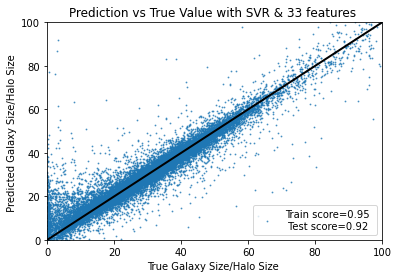

In [70]:
label = 'Train score={} \n Test score={}'.format(round(best_SVR_trainscore, 2),round(scores_SVR.mean(), 2) )
# label='Cross_val mean test score={}'.format(round(scores_RF.mean(),2))

plt.scatter(y, y_pred_SVR, s=3, marker='.', alpha=0.7, label=label)
plt.axis([0.0,100, 0.0,100])
plt.plot([0.0, 170], [0.0, 170], color = 'black', linewidth = 2)
plt.title('Prediction vs True Value with SVR & 33 features ')
plt.xlabel('True Galaxy Size/Halo Size ')
plt.ylabel(' Predicted Galaxy Size/Halo Size  ')
plt.legend(loc='lower right')
# plt.savefig('Prediction_vs_True_SVR_33feat.jpeg', dpi=500)
# xpoints = ypoints = plt.xlim()
# plt.plot(xpoints, ypoints, linestyle='--', color='k', lw=3, scalex=False, scaley=False)
plt.show()

## <font color='blue'> 3.b. Support Vector Machine (SVM) - Halo features only

In [71]:
X_el = df_normalized.loc[:, ['HalopropC_nfw', 'HalopropSpin']]

y_el = df_normalized.loc[:,'GalpropNormHalfRadius']

In [73]:
start_time = time.time()

piped_model_el = make_pipeline(StandardScaler(), SVR()) #non linear so I can change the kernel

piped_model_el.get_params() #this shows how we can access parameters both for the scaler and the classifier

#optimizing SVR

# parameters_el = {'svr__kernel':['poly', 'rbf'], \
#               'svr__gamma':['scale', 0.01, 0.1], 'svr__C':[10, 100, 1000], \
#               'svr__degree': [2]}

parameters_el = {'svr__kernel':['rbf'], \
              'svr__gamma':['scale'], 'svr__C':[100], \
              }

model_el = GridSearchCV(piped_model_el, parameters_el, cv = KFold(n_splits=3, shuffle=True), \
                     verbose = 1, n_jobs = -1, return_train_score=True)

model_el.fit(X_el, y_el)

print('Best params, best score:', "{:.4f}".format(model_el.best_score_), \
      model_el.best_params_)

elapsed_time = time.time() - start_time
print(f"Elapsed time to compute the GridSearchCV for SVR-Halo feat: {elapsed_time:.3f} seconds")

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best params, best score: 0.3524 {'svr__C': 100, 'svr__gamma': 'scale', 'svr__kernel': 'rbf'}
Elapsed time to compute the GridSearchCV for SVR-Halo feat: 70.835 seconds


In [74]:
scores_lim_el = pd.DataFrame(model_el.cv_results_)

scores_lim_el[['params','mean_test_score','std_test_score','mean_train_score', \
            'mean_fit_time']].sort_values(by = 'mean_test_score', ascending = False)

,params,mean_test_score,std_test_score,mean_train_score,mean_fit_time
0,"{'svr__C': 100, 'svr__gamma': 'scale', 'svr__k...",0.352402,0.019749,0.367468,12.029836


In [75]:
best_SVR_el=model_el.best_estimator_

In [76]:
best_SVR_trainscore_el=model_el.cv_results_['mean_train_score'][model_el.best_index_]

In [77]:
scores_SVR_el = cross_val_score(best_SVR_el, X_el, y_el, cv = KFold(n_splits=5, shuffle=True, random_state=10)) # cv score in all data?

In [78]:
y_pred_SVR_el = cross_val_predict(best_SVR_el, X_el, y_el, cv = KFold(n_splits=5, shuffle=True, random_state=10))

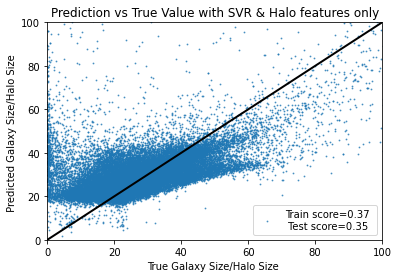

In [79]:
label = 'Train score={} \n Test score={}'.format(round(best_SVR_trainscore_el, 2),round(scores_SVR_el.mean(), 2) )
# label='Cross_val mean test score={}'.format(round(scores_RF.mean(),2))

plt.scatter(y_el, y_pred_SVR_el, s=3, marker='.', alpha=0.7, label=label)
plt.axis([0.0,100, 0.0,100])
plt.plot([0.0, 170], [0.0, 170], color = 'black', linewidth = 2)
plt.title('Prediction vs True Value with SVR & Halo features only')
plt.xlabel('True Galaxy Size/Halo Size ')
plt.ylabel(' Predicted Galaxy Size/Halo Size  ')
plt.legend(loc='lower right')
# plt.savefig('Prediction_vs_True.jpeg', dpi=500)
# xpoints = ypoints = plt.xlim()
# plt.plot(xpoints, ypoints, linestyle='--', color='k', lw=3, scalex=False, scaley=False)
plt.show()

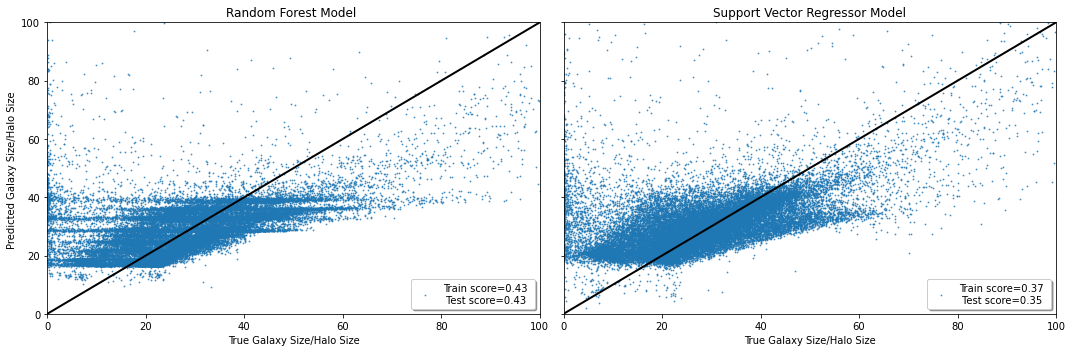

In [82]:
fig,[ax1, ax5 ]=plt.subplots(nrows=1,ncols=2,sharey=True, figsize=(15,5))
# fig.suptitle('TNG-SAM Central Galaxies Size Prediction', fontsize=16, fontweight='bold')
plt.subplots_adjust(hspace=0.0,wspace=0.0)

label = 'Train score={} \n Test score={}'.format(round(rfr_grid_el.best_estimator_.score(X_el, y_el), 2),round(rfr_grid_el.score(X_el, y_el), 2) )
# print(label)
im1 = ax1.scatter(y_el, y_pred_RF_el, s=3, marker='.', alpha=0.7, label=label)
# ax1.set_xlim([9.0, 11.5])
# ax1.set_xticks([9.0, 9.5, 10.0, 10.5, 11.0])
# ax1.set_ylim([0.2,1.2])
ax1.axis([0.0,100, 0.0,100])
ax1.plot([0.0, 170], [0.0, 170], color = 'black', linewidth = 2)
ax1.set_title('Random Forest Model ')
ax1.set_xlabel('True Galaxy Size/Halo Size')
ax1.set_ylabel('Predicted Galaxy Size/Halo Size ')
ax1.legend(loc='lower right', shadow=True)

label = 'Train score={} \n Test score={}'.format(round(best_SVR_trainscore_el, 2),round(scores_SVR_el.mean(), 2) )
im5 = ax5.scatter(y_el, y_pred_SVR_el, s=3, marker='.', alpha=0.7, label=label)
# ax5.set_xlim([9.0, 11.5])
# ax5.set_xticks([9.0, 9.5, 10.0, 10.5, 11.0])
# ax5.set_ylim([0.2,1.2])
ax5.axis([0.0,100, 0.0,100])
ax5.plot([0.0, 170], [0.0, 170], color = 'black', linewidth = 2)
ax5.set_title('Support Vector Regressor Model')
ax5.set_xlabel('True Galaxy Size/Halo Size')
# ax5.set_ylabel('Predicted $ log_{10} $ Galaxy Size  [kpc] ')
ax5.legend(loc='lower right', shadow=True)

# fig.subplots_adjust(hspace=0.0, wspace=0.0)
fig.tight_layout()
# plt.savefig("TNG-SAM_RF_SVR_size_prediction_halo_only.jpeg", dpi=500)
plt.show()

## <font color='darkred'> The figure containing all the models

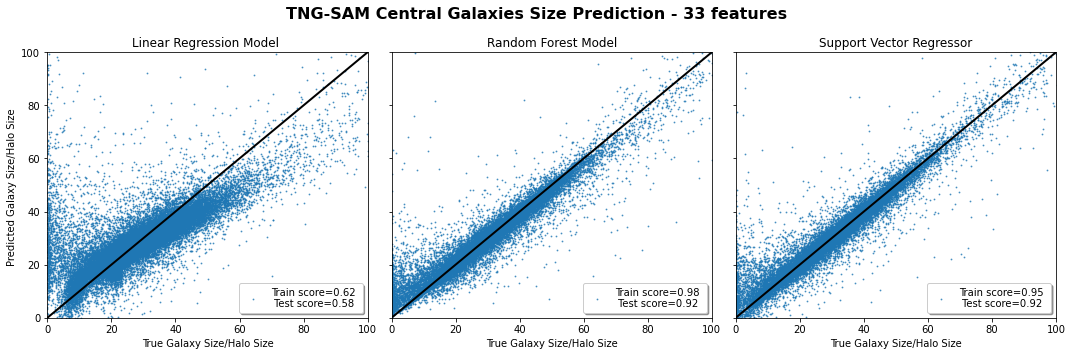

In [83]:
fig,[ax1, ax5, ax6 ]=plt.subplots(nrows=1,ncols=3,sharey=True, figsize=(15,5))
fig.suptitle('TNG-SAM Central Galaxies Size Prediction - 33 features', fontsize=16, fontweight='bold')
plt.subplots_adjust(hspace=0.0,wspace=0.0)

label = 'Train score={} \n Test score={}'.format(round(reg.score(X_train, y_train), 2),round(reg.score(X_test, y_test), 2) )
# print(label)
im1 = ax1.scatter(y, y_pred_LR, s=3, marker='.', alpha=0.7, label=label)
# ax1.set_xlim([9.0, 11.5])
# ax1.set_xticks([9.0, 9.5, 10.0, 10.5, 11.0])
# ax1.set_ylim([0.2,1.2])
ax1.axis([0.0,100, 0.0,100])
ax1.plot([0.0, 170], [0.0, 170], color = 'black', linewidth = 2)
ax1.set_title('Linear Regression Model ')
ax1.set_xlabel('True Galaxy Size/Halo Size')
ax1.set_ylabel('Predicted Galaxy Size/Halo Size ')
ax1.legend(loc='lower right', shadow=True)

label = 'Train score={} \n Test score={}'.format(round(best_RF_trainscore, 2),round(scores_RF.mean(), 2) )
im5 = ax5.scatter(y, y_pred_RF, s=3, marker='.', alpha=0.7, label=label)
# ax5.set_xlim([9.0, 11.5])
# ax5.set_xticks([9.0, 9.5, 10.0, 10.5, 11.0])
# ax5.set_ylim([0.2,1.2])
ax5.axis([0.0,100, 0.0,100])
ax5.plot([0.0, 170], [0.0, 170], color = 'black', linewidth = 2)
ax5.set_title('Random Forest Model')
ax5.set_xlabel('True Galaxy Size/Halo Size')
# ax5.set_ylabel('Predicted $ log_{10} $ Galaxy Size  [kpc] ')
ax5.legend(loc='lower right', shadow=True)

label = 'Train score={} \n Test score={}'.format(round(best_SVR_trainscore, 2),round(scores_SVR.mean(), 2) )
im6 = ax6.scatter(y, y_pred_SVR, s=3, marker='.', alpha=0.7, label=label)
# ax6.set_xlim([9.0, 11.5])
# ax6.set_xticks([9.0, 9.5, 10.0, 10.5, 11.0])
# ax6.set_ylim([0.2,1.2])
ax6.axis([0.0,100, 0.0,100])
ax6.plot([0.0, 170], [0.0, 170], color = 'black', linewidth = 2)
ax6.set_title('Support Vector Regressor')
ax6.set_xlabel('True Galaxy Size/Halo Size')
# ax6.set_ylabel('Predicted $ log_{10} $ Galaxy Size  [kpc] ')
ax6.legend(loc='lower right', shadow=True)
    
# grid = plt.GridSpec(3, 2)
# create_subtitle(fig, grid[0, ::], 'Linear Regression with only Stellar Mass as a feature')
# create_subtitle(fig, grid[1, ::], 'Linear Regression with only Halo Mass as a feature')
# create_subtitle(fig, grid[2, ::], 'Linear Regression vs Random Forest Regressor with all features')

# fig.subplots_adjust(hspace=0.0, wspace=0.0)
fig.tight_layout()
# plt.savefig("TNG-SAM_LR_RF_SVR_size_prediction_33feat.jpeg", dpi=500)
plt.show()

## <font color='orange'> 4. 10-feature Dataset

### <font color='orange'> 4.a. Define the dataset for the 10-feature analysis

In [84]:
df_normalized_10=df_normalized.loc[:, ['HalopropSpin', 'HalopropC_nfw', 'HalopropNormMhot',
                                      'GalpropSfr',   'GalpropZcold',
                                      'GalpropZstar','GalpropNormMstar', 'GalpropNormMbulge', 'GalpropNormMH2',
                                      'GalpropNormMHI', 'GalpropNormHalfRadius']]

In [85]:
X_10 = df_normalized_10.loc[:, ['HalopropSpin', 'HalopropC_nfw', 'HalopropNormMhot',
                                      'GalpropSfr',   'GalpropZcold',
                                      'GalpropZstar','GalpropNormMstar', 'GalpropNormMbulge', 'GalpropNormMH2',
                                      'GalpropNormMHI']]

y_10 = df_normalized_10.loc[:, 'GalpropNormHalfRadius']

### <font color='orange'> 4.b. SVR of 10-feature analysis


In [87]:
piped_model_10 = make_pipeline(StandardScaler(), SVR())

In [88]:
#optimizing SVR

# parameters_10_rbf = {'svr__kernel':['rbf'], \
#               'svr__gamma':['scale', 0.01, 0.1, 1.0, 10], 'svr__C':[0.1, 1.0, 10, 100], \
#               }
parameters_10_rbf = {'svr__kernel':['rbf'], \
              'svr__gamma':['scale'], 'svr__C':[0.1, 1.0, 10, 100], \
              }
model_10_rbf = GridSearchCV(piped_model_10, parameters_10_rbf, cv = KFold(n_splits=3, shuffle=True), \
                     verbose = 2, n_jobs = -1, return_train_score=True)

model_10_rbf.fit(X_10, y_10)

print('Best params, best score:', "{:.4f}".format(model_10_rbf.best_score_), \
      model_10_rbf.best_params_)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


/Users/festabu/miniforge3/envs/native/lib/python3.9/site-packages/sklearn/model_selection/_search.py:292: UserWarning: The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best params, best score: 0.7510 {'svr__kernel': 'rbf', 'svr__gamma': 'scale', 'svr__C': 1000}
[CV] END .....svr__C=1000, svr__gamma=scale, svr__kernel=rbf; total time= 1.5min
[CV] END .....svr__C=1000, svr__gamma=scale, svr__kernel=rbf; total time= 1.6min
[CV] END .....svr__C=1000, svr__gamma=scale, svr__kernel=rbf; total time= 1.9min


In [90]:
scores_lim_10 = pd.DataFrame(model_10_rbf.cv_results_)

scores_lim_10[['params','mean_test_score','std_test_score','mean_train_score', \
            'mean_fit_time']].sort_values(by = 'mean_test_score', ascending = False)

,params,mean_test_score,std_test_score,mean_train_score,mean_fit_time
0,"{'svr__kernel': 'rbf', 'svr__gamma': 'scale', ...",0.750954,0.043814,0.811162,87.915396


In [92]:
best_SVR_10=model_10_rbf.best_estimator_

In [95]:
best_SVR_trainscore_10=model_10_rbf.cv_results_['mean_train_score'][model_10_rbf.best_index_]

In [96]:
scores_SVR_10 = cross_val_score(best_SVR_10, X_10, y_10, cv = KFold(n_splits=5, shuffle=True, random_state=10)) # cv score in all data?

In [97]:
print("Accuracy: %0.2f (+/- %0.2f)" % (scores_SVR_10.mean(), scores_SVR_10.std() * 2))

Accuracy: 0.76 (+/- 0.10)


In [98]:
y_pred_SVR_10 = cross_val_predict(best_SVR_10, X_10, y_10, cv = KFold(n_splits=5, shuffle=True, random_state=10))

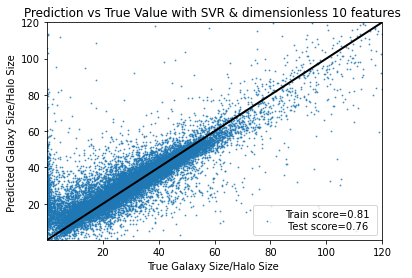

In [99]:
label = 'Train score={} \n Test score={}'.format(round(best_SVR_trainscore_10, 2),round(scores_SVR_10.mean(), 2) )
# label='Cross_val mean test score={}'.format(round(scores_RF.mean(),2))

plt.scatter(y_10, y_pred_SVR_10, s=3, marker='.', alpha=0.7, label=label)
plt.axis([0.1,120, 0.1,120])
plt.plot([0.0, 120], [0.0, 120], color = 'black', linewidth = 2)
plt.title('Prediction vs True Value with SVR & dimensionless 10 features ')
plt.xlabel('True Galaxy Size/Halo Size ')
plt.ylabel(' Predicted Galaxy Size/Halo Size  ')
plt.legend(loc='lower right')
# plt.savefig('Prediction_vs_True_SVR_updated10feat.jpeg', dpi=500)
# xpoints = ypoints = plt.xlim()
# plt.plot(xpoints, ypoints, linestyle='--', color='k', lw=3, scalex=False, scaley=False)
plt.show()

### <font color='orange'> 4.c. RF of 10-feature analysis

In [100]:
regr_RF = RandomForestRegressor(random_state=0)

In [101]:
# number of trees in random forest
n_estimators_10 = [int(x) for x in np.linspace(start = 10, stop = 100, num = 3)]
# number of features at every split
# max_features = ['auto', 'sqrt']


# create random grid
grid_10 = {'bootstrap': [True],
               'max_depth': [5, 10, None],
#                'max_features': ['auto', 'sqrt'],
               'min_samples_leaf': [1, 2, 4],
#                'min_samples_split': [2, 5, 10],
               'n_estimators': n_estimators_10}
# Random search of parameters
# rfr_grid = GridSearchCV(estimator = regr_RF, param_grid = grid, cv = 3, verbose=1, n_jobs = -1)
rfr_grid_10 = GridSearchCV(estimator = regr_RF, param_grid = grid_10, cv = KFold(n_splits=5, shuffle=True), \
                     verbose = 1, n_jobs = -1, return_train_score=True)

rfr_grid_10.fit(X_10, y_10)

print('Best params, best score:', "{:.4f}".format(rfr_grid_10.best_score_), \
    rfr_grid_10.best_params_)




Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best params, best score: 0.9201 {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 2, 'n_estimators': 100}


In [102]:
best_RF_10=rfr_grid_10.best_estimator_ # The index (of the cv_results_ arrays) which corresponds to the best candidate parameter setting.

In [103]:
best_RF_trainscore_10=rfr_grid_10.cv_results_['mean_train_score'][rfr_grid_10.best_index_]

In [104]:
#  y_pred = rfr_grid.best_estimator_.predict(X_test)
y_pred_RF_10 = cross_val_predict(best_RF_10, X_10, y_10, cv = KFold(n_splits=5, shuffle=True, random_state=10))

In [105]:
scores_RF_10 = cross_val_score(best_RF_10, X_10, y_10, cv = KFold(n_splits=5, shuffle=True, random_state=10))

In [106]:
print("Accuracy: %0.2f (+/- %0.2f)" % (scores_RF_10.mean(), scores_RF_10.std() * 2))

Accuracy: 0.92 (+/- 0.02)


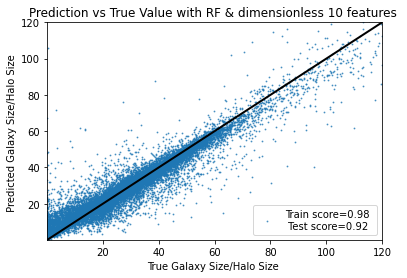

In [107]:
label = 'Train score={} \n Test score={}'.format(round(best_RF_trainscore_10, 2),round(scores_RF_10.mean(), 2) )
# label='Cross_val mean test score={}'.format(round(scores_RF.mean(),2))

plt.scatter(y_10, y_pred_RF_10, s=3, marker='.', alpha=0.7, label=label)
plt.axis([0.1,120, 0.1,120])
plt.plot([0.0, 120], [0.0, 120], color = 'black', linewidth = 2)
plt.title('Prediction vs True Value with RF & dimensionless 10 features ')
plt.xlabel('True Galaxy Size/Halo Size ')
plt.ylabel(' Predicted Galaxy Size/Halo Size  ')
plt.legend(loc='lower right')
# plt.savefig('Prediction_vs_True_updated10feat.jpeg', dpi=500)
# xpoints = ypoints = plt.xlim()
# plt.plot(xpoints, ypoints, linestyle='--', color='k', lw=3, scalex=False, scaley=False)
plt.show()

### <font color='orange'> 4.d. LR of 10-feature analysis


In [108]:
X_train_10, X_test_10, y_train_10, y_test_10 = train_test_split(X_10, y_10, test_size=0.33, random_state=42)

In [109]:
reg = LinearRegression()
reg.fit(X_train_10, y_train_10)

reg.score(X_train_10, y_train_10)

0.4728362747635678

In [110]:
y_pred_LR_10 = cross_val_predict(reg, X_10, y_10, cv = KFold(n_splits=5, shuffle=True, random_state=10))

In [111]:
scores_reg_10 = cross_val_score(reg, X_10, y_10, cv = KFold(n_splits=5, shuffle=True, random_state=10))

In [112]:
print("Accuracy: %0.2f (+/- %0.2f)" % (scores_reg_10.mean(), scores_reg_10.std() * 2))

Accuracy: 0.43 (+/- 0.12)


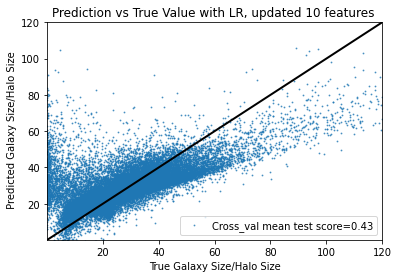

In [113]:
# label = 'Train score={} \n Test score={}'.format(round(reg.score(X_train, y_train), 2),round(reg.score(X_test, y_test), 2) )
label='Cross_val mean test score={}'.format(round(scores_reg_10.mean(),2))

plt.scatter(y_10, y_pred_LR_10, s=3, marker='.', alpha=0.7, label=label)
plt.axis([0.1,120, 0.1,120])
plt.plot([0.0, 120], [0.0, 120], color = 'black', linewidth = 2)
# xpoints = ypoints = plt.xlim()
# plt.plot(xpoints, ypoints, linestyle='-', color='k', lw=3, scalex=False, scaley=False)
plt.title('Prediction vs True Value with LR, updated 10 features ')
plt.xlabel('True Galaxy Size/Halo Size')
plt.ylabel(' Predicted Galaxy Size/Halo Size')
plt.legend(loc='lower right')

plt.show()

## <font color='darkred'> The figure containing all the models - 10 features

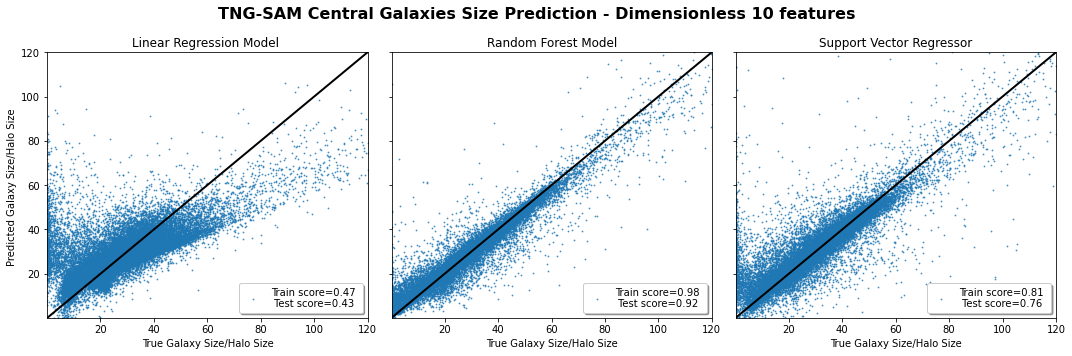

In [114]:
fig,[ax1, ax5, ax6 ]=plt.subplots(nrows=1,ncols=3,sharey=True, figsize=(15,5))
fig.suptitle('TNG-SAM Central Galaxies Size Prediction - Dimensionless 10 features', fontsize=16, fontweight='bold')
plt.subplots_adjust(hspace=0.0,wspace=0.0)

label = 'Train score={} \n Test score={}'.format(round(reg.score(X_train_10, y_train_10), 2),round(scores_reg_10.mean(), 2) )
# print(label)
im1 = ax1.scatter(y_10, y_pred_LR_10, s=3, marker='.', alpha=0.7, label=label)
# ax1.set_xlim([9.0, 11.5])
# ax1.set_xticks([9.0, 9.5, 10.0, 10.5, 11.0])
# ax1.set_ylim([0.2,1.2])
ax1.axis([0.1,120, 0.1,120])
ax1.plot([0.0, 120], [0.0, 120], color = 'black', linewidth = 2)
ax1.set_title('Linear Regression Model ')
ax1.set_xlabel('True Galaxy Size/Halo Size')
ax1.set_ylabel('Predicted Galaxy Size/Halo Size ')
ax1.legend(loc='lower right', shadow=True)

label = 'Train score={} \n Test score={}'.format(round(best_RF_trainscore_10, 2),round(scores_RF_10.mean(), 2) )
im5 = ax5.scatter(y_10, y_pred_RF_10, s=3, marker='.', alpha=0.7, label=label)
# ax5.set_xlim([9.0, 11.5])
# ax5.set_xticks([9.0, 9.5, 10.0, 10.5, 11.0])
# ax5.set_ylim([0.2,1.2])
ax5.axis([0.1,120, 0.1,120])
ax5.plot([0.0, 120], [0.0, 120], color = 'black', linewidth = 2)
ax5.set_title('Random Forest Model')
ax5.set_xlabel('True Galaxy Size/Halo Size')
# ax5.set_ylabel('Predicted $ log_{10} $ Galaxy Size  [kpc] ')
ax5.legend(loc='lower right', shadow=True)

label = 'Train score={} \n Test score={}'.format(round(best_SVR_trainscore_10, 2),round(scores_SVR_10.mean(), 2) )
im6 = ax6.scatter(y_10, y_pred_SVR_10, s=3, marker='.', alpha=0.7, label=label)
# ax6.set_xlim([9.0, 11.5])
# ax6.set_xticks([9.0, 9.5, 10.0, 10.5, 11.0])
# ax6.set_ylim([0.2,1.2])
ax6.axis([0.1,120, 0.1,120])
ax6.plot([0.0, 120], [0.0, 120], color = 'black', linewidth = 2)
ax6.set_title('Support Vector Regressor')
ax6.set_xlabel('True Galaxy Size/Halo Size')
# ax6.set_ylabel('Predicted $ log_{10} $ Galaxy Size  [kpc] ')
ax6.legend(loc='lower right', shadow=True)
    

# fig.subplots_adjust(hspace=0.0, wspace=0.0)
fig.tight_layout()
# plt.savefig("TNG-SAM_LR_RF_SVR_size_prediction_dimensionless_10feat.jpeg", dpi=500)
plt.show()

## <font color='green'> 5. Symbolic Regression w/most important features from the 33-feature dataset

In [18]:
from pysr import PySRRegressor

In [19]:
# take the 7 most important features from add-feature ranking analysis above and use them for Symbolic Regression analysis here

X_addfeat_imp=X.loc[:, ['HalopropSpin', 'GalpropNormMstar_merge', 'GalpropNormMstar','GalpropNormVdisk', 
                        'GalpropNormMbulge',  'GalpropNormSigmaBulge','HalopropNormMstar_diffuse' ]]
y_addfeat_imp=y

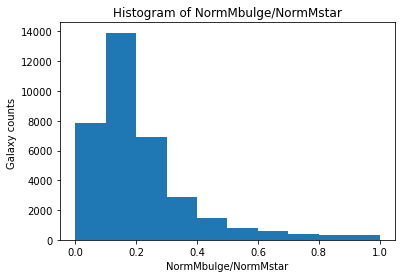

In [20]:
plt.hist((X_addfeat_imp['GalpropNormMbulge']/X_addfeat_imp['GalpropNormMstar']))
plt.title('Histogram of NormMbulge/NormMstar')
plt.xlabel('NormMbulge/NormMstar')
plt.ylabel('Galaxy counts ')
# plt.savefig('Histogram of GalpropNormMbulgebyNormMstar.jpg', dpi=500)

plt.show()

### By morphology: Ellipticals 

In [22]:
df_normalized.loc[:, 'BulgeMstar_ratio'] = df_normalized.loc[:,'GalpropNormMbulge']/df_normalized.loc[:, 'GalpropNormMstar']


In [22]:
df_ellipticals = df_normalized[df_normalized['BulgeMstar_ratio']>=0.8]

In [23]:
df_ellipticals.columns

Index(['GalpropMaccdot', 'GalpropMaccdot_radio', 'GalpropMu_merger',
       'GalpropOutflowRate_Mass', 'GalpropOutflowRate_Metal', 'GalpropSfr',
       'GalpropSfrave100myr', 'GalpropSfrave1gyr', 'GalpropSfrave20myr',
       'GalpropTmerger', 'GalpropTmerger_major', 'GalpropZcold',
       'GalpropZstar', 'HalopropC_nfw', 'HalopropMaccdot_radio',
       'HalopropMaccdot_reaccreate', 'HalopropMetal_ejected', 'HalopropSpin',
       'HalopropZhot', 'GalpropNormHalfRadius', 'GalpropNormMstar',
       'HalopropNormMhot', 'GalpropNormMbulge', 'GalpropNormMBH',
       'GalpropNormMH2', 'GalpropNormMHI', 'GalpropNormMHII',
       'GalpropNormMcold', 'GalpropNormMstar_merge',
       'HalopropNormMass_ejected', 'HalopropNormMstar_diffuse',
       'GalpropNormSigmaBulge', 'GalpropNormVdisk', 'BulgeMstar_ratio'],
      dtype='object')

In [24]:
X_ellipticals_imp=df_ellipticals.loc[:, ['HalopropSpin', 'GalpropNormMstar_merge', 'GalpropNormMstar','GalpropNormVdisk', 
                        'GalpropNormMbulge',  'GalpropNormSigmaBulge','HalopropNormMstar_diffuse' ]]
y_ellipticals_imp=df_ellipticals.loc[:, 'GalpropNormHalfRadius']

In [27]:
# choose the Symbolic Regression model; choose the mathematical operations allowed
model_ellipticals_imp = PySRRegressor(
    procs=-1,
#     niterations=40,
    binary_operators=["+", "*", "pow", ],
    unary_operators=["exp", "square", "cube"
#         "inv(x) = 1/x",  # Custom operator (julia syntax)
    ],
    model_selection="best",
    loss="loss(x, y) = (x - y)^2",  # Custom loss function (julia syntax)
)

In [28]:
start_time = time.time()

model_ellipticals_imp.fit(X_ellipticals_imp, np.array(y_ellipticals_imp))

elapsed_time = time.time() - start_time

print(f"Elapsed time to compute the SymbolicRegression fitting: {elapsed_time:.3f} seconds")

  Activating project at `~/.julia/environments/pysr-0.7.9`
   Resolving package versions...
  No Changes to `~/.julia/environments/pysr-0.7.9/Project.toml`
  No Changes to `~/.julia/environments/pysr-0.7.9/Manifest.toml`
  No Changes to `~/.julia/environments/pysr-0.7.9/Project.toml`
  No Changes to `~/.julia/environments/pysr-0.7.9/Manifest.toml`


Elapsed time to compute the SymbolicRegression fitting: 229.060 seconds


In [29]:
print(model_ellipticals_imp)

PySRRegressor.equations = [
	    pick     score                                           equation  \
	0         0.000000                                           8.372043   
	1         0.000165                (GalpropNormMstar_merge + 8.364981)   
	2         0.040508        exp(pow(GalpropNormSigmaBulge, -1.7928098))   
	3         0.386392  pow(-0.09138625, GalpropNormSigmaBulge + -1.70...   
	4         0.000452  square(pow(0.28992787, GalpropNormSigmaBulge +...   
	5         0.024034  exp(pow(-2.9861574, pow(GalpropNormMstar_merge...   
	6         0.024050  square(exp(pow(GalpropNormMstar_merge, square(...   
	7   >>>>  0.664132  square(pow(pow(-5.0896664, pow(GalpropNormMsta...   
	8         0.017790  (square(exp(pow(-45.99865, pow(pow(GalpropNorm...   
	9         0.001750  (square(pow(pow(-5.3376207, pow(GalpropNormMst...   
	10        0.000270  ((square(exp(pow(24.888004, pow(pow(GalpropNor...   
	11        0.004112  (square(pow(pow(5.8869724, pow(GalpropNormMsta...   
	12       

In [30]:
model_ellipticals_imp.equations

,complexity,loss,score,equation,sympy_format,lambda_format
0,1,47.051445,0.000000,8.372043,8.37204300000000,PySRFunction(X=>8.37204300000000)
1,3,47.035908,0.000165,(GalpropNormMstar_merge + 8.364981),GalpropNormMstar_merge + 8.364981,PySRFunction(X=>GalpropNormMstar_merge + 8.364...
2,4,45.168640,0.040508,"exp(pow(GalpropNormSigmaBulge, -1.7928098))",exp(Abs(GalpropNormSigmaBulge)**(-1.7928098)),PySRFunction(X=>exp(Abs(GalpropNormSigmaBulge)...
3,5,30.692287,0.386392,"pow(-0.09138625, GalpropNormSigmaBulge + -1.70...",0.09138625**(GalpropNormSigmaBulge - 1.7027333),PySRFunction(X=>0.09138625**(GalpropNormSigmaB...
4,6,30.678413,0.000452,"square(pow(0.28992787, GalpropNormSigmaBulge +...",0.28992787**(2*GalpropNormSigmaBulge - 3.3431084),PySRFunction(X=>0.28992787**(2*GalpropNormSigm...
5,8,29.238630,0.024034,"exp(pow(-2.9861574, pow(GalpropNormMstar_merge...",exp(2.9861574**(Abs(GalpropNormMstar_merge)**(...,PySRFunction(X=>exp(2.9861574**(Abs(GalpropNor...
6,9,28.543830,0.024050,"square(exp(pow(GalpropNormMstar_merge, square(...",6.40794226567919*exp(2*Abs(GalpropNormMstar_me...,PySRFunction(X=>6.40794226567919*exp(2*Abs(Gal...
7,10,14.692087,0.664132,"square(pow(pow(-5.0896664, pow(GalpropNormMsta...",5.0896664**(6.905882*re(Abs(GalpropNormMstar_m...,PySRFunction(X=>5.0896664**(6.905882*re(Abs(Ga...
8,11,14.433021,0.017790,"(square(exp(pow(-45.99865, pow(pow(GalpropNorm...",exp(2*45.99865**(Abs(GalpropNormMstar_merge)**...,PySRFunction(X=>exp(2*45.99865**(Abs(GalpropNo...
9,12,14.407787,0.001750,"(square(pow(pow(-5.3376207, pow(GalpropNormMst...",5.3376207**(8.0493594*re(Abs(GalpropNormMstar_...,PySRFunction(X=>5.3376207**(8.0493594*re(Abs(G...


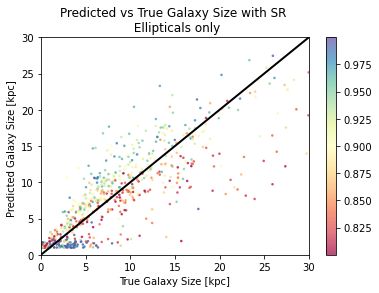

In [46]:
# color_dict = {(bulge_mstar_ratio)<=0.1 : 'red',
#                (bulge_mstar_ratio>0.1) & (bulge_mstar_ratio<0.6) : 'yellow',
#                (bulge_mstar_ratio)>=0.6 : 'blue'}
plt.scatter(y_ellipticals_imp, model_ellipticals_imp.predict(X_ellipticals_imp),
            c = df_ellipticals['BulgeMstar_ratio'],  cmap='Spectral',
            s=10, marker='.', alpha=0.7) #,label= label, vmin=-2, vmax=1.0)
plt.plot([0.0, 150], [0.0, 150], color = 'black', linewidth = 2)
plt.axis([0.0,30, 0.0,30])
plt.title('Predicted vs True Galaxy Size with SR \n Ellipticals only')
plt.xlabel('True Galaxy Size [kpc]')
plt.ylabel('Predicted Galaxy Size [kpc] ')
plt.colorbar()
# plt.savefig('SR_ellipticals_predicted vs true gal size.jpeg', dpi=500)
plt.show()

### By morphology: Disks 

In [23]:
df_disks = df_normalized[df_normalized['BulgeMstar_ratio']<=0.1]

In [24]:
df_disks.shape

(7865, 34)

In [25]:
X_disks_imp=df_disks.loc[:, ['HalopropSpin', 'GalpropNormMstar_merge', 'GalpropNormMstar','GalpropNormVdisk', 
                        'GalpropNormMbulge',  'GalpropNormSigmaBulge','HalopropNormMstar_diffuse' ]]
y_disks_imp=df_disks.loc[:, 'GalpropNormHalfRadius']

In [40]:
# choose the Symbolic Regression model; choose the mathematical operations allowed
model_disks_imp = PySRRegressor(
    procs=-1,
#     niterations=1,
    binary_operators=["+", "*", "pow", ],
    unary_operators=["exp", "square", "cube"
#         "inv(x) = 1/x",  # Custom operator (julia syntax)
    ],
    model_selection="best",
    loss="loss(x, y) = (x - y)^2",  # Custom loss function (julia syntax)
)

In [ ]:
start_time = time.time()

model_disks_imp.fit(X_disks_imp, np.array(y_disks_imp))

elapsed_time = time.time() - start_time


print(f"Elapsed time to compute the SymbolicRegression fitting: {elapsed_time:.3f} seconds")

In [27]:
# resutls when niteration=1
start_time = time.time()

model_disks_imp.fit(X_disks_imp, np.array(y_disks_imp))

elapsed_time = time.time() - start_time

print(f"Elapsed time to compute the SymbolicRegression fitting: {elapsed_time:.3f} seconds")

/Users/festabu/miniforge3/envs/native/lib/python3.9/site-packages/pysr/sr.py:318: UserWarning: 
Your Python version is statically linked to libpython. For example, this could be the python included with conda, or maybe your system's built-in python.
This will still work, but the precompilation cache for Julia will be turned off, which may result in slower startup times on the initial pysr() call.

To install a Python version that is dynamically linked to libpython, pyenv is recommended (https://github.com/pyenv/pyenv). With pyenv, you can run: `PYTHON_CONFIGURE_OPTS="--enable-shared" pyenv install 3.9.10` to install Python 3.9.10 with dynamic linking.

To silence this warning, you can run pysr.silence_julia_warning() after importing pysr.
  warnings.warn(
/Users/festabu/miniforge3/envs/native/lib/python3.9/site-packages/pysr/sr.py:942: UserWarning: Resetting variable_names from X.columns
  warnings.warn("Resetting variable_names from X.columns")
  Activating project at `~/.julia/enviro

Started!

Cycles per second: 3.270e+02
Head worker occupation: 2.3%
Progress: 3 / 100 total iterations (3.000%)
Hall of Fame:
-----------------------------------------
Complexity  Loss       Score     Equation
1           2.648e+02  2.217e-07  30.17199
5           2.638e+02  9.928e-04  (pow(GalpropNormVdisk, HalopropSpin) * 30.03908)
6           2.629e+02  3.412e-03  square(pow(-4.3533805e-7, GalpropNormMbulge) + 4.499939)
7           2.547e+02  3.169e-02  cube(exp(pow(-0.61684376 + GalpropNormVdisk, -0.138086)))
8           2.331e+02  8.841e-02  cube(((HalopropSpin + HalopropNormMstar_diffuse) + HalopropSpin) + 3.0540338)
10          1.002e+02  4.221e-01  cube(exp(pow(5.5430336, square(pow(HalopropSpin * 1.6219919, 0.44594783)))))
12          8.177e+01  1.017e-01  (square(exp(pow(4.2641573, square(pow(HalopropSpin * 1.6796918, 0.17859934))))) + -0.031074971)

Press 'q' and then <enter> to stop execution early.

Cycles per second: 4.330e+02
Head worker occupation: 1.4%
Progress: 6 / 10

In [28]:
print(model_disks_imp)

PySRRegressor.equations = [
	   pick     score                                           equation  \
	0        0.000000                                           30.17199   
	1        0.001046                         (HalopropSpin + 30.137098)   
	2        0.063261                       exp(HalopropSpin + 3.380597)   
	3  >>>>  0.938322         ((HalopropSpin + 811.0611) * HalopropSpin)   
	4        0.024946  square(exp((HalopropSpin * 6.787958) + 1.44915...   
	5        0.116997  exp(exp(cube(pow(HalopropSpin, GalpropNormVdis...   
	6        0.314625  exp(square(square(HalopropSpin + 1.4563712)) +...   
	
	         loss  complexity  
	0  264.836940           1  
	1  264.283360           3  
	2  248.082340           4  
	3   97.070595           5  
	4   92.346405           7  
	5   82.150215           8  
	6   43.785347          10  
]


In [29]:
model_disks_imp.equations

,complexity,loss,score,equation,sympy_format,lambda_format
0,1,264.836940,0.000000,30.17199,30.1719900000000,PySRFunction(X=>30.1719900000000)
1,3,264.283360,0.001046,(HalopropSpin + 30.137098),HalopropSpin + 30.137098,PySRFunction(X=>HalopropSpin + 30.137098)
2,4,248.082340,0.063261,exp(HalopropSpin + 3.380597),29.3883106986894*exp(HalopropSpin),PySRFunction(X=>29.3883106986894*exp(HalopropS...
3,5,97.070595,0.938322,((HalopropSpin + 811.0611) * HalopropSpin),HalopropSpin*(HalopropSpin + 811.0611),PySRFunction(X=>HalopropSpin*(HalopropSpin + 8...
4,7,92.346405,0.024946,square(exp((HalopropSpin * 6.787958) + 1.44915...,18.1434860322971*exp(13.575916*HalopropSpin),PySRFunction(X=>18.1434860322971*exp(13.575916...
5,8,82.150215,0.116997,"exp(exp(cube(pow(HalopropSpin, GalpropNormVdis...",exp(exp(1.15330219742608*(0.953569372267189*Ab...,PySRFunction(X=>exp(exp(1.15330219742608*(0.95...
6,10,43.785347,0.314625,exp(square(square(HalopropSpin + 1.4563712)) +...,exp(-1.3942808*GalpropNormVdisk + 4.4987134205...,PySRFunction(X=>exp(-1.3942808*GalpropNormVdis...


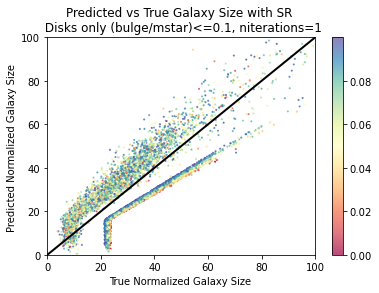

In [39]:
# color_dict = {(bulge_mstar_ratio)<=0.1 : 'red',
#                (bulge_mstar_ratio>0.1) & (bulge_mstar_ratio<0.6) : 'yellow',
#                (bulge_mstar_ratio)>=0.6 : 'blue'}
plt.scatter(y_disks_imp, model_disks_imp.predict(X_disks_imp),
            c = df_disks['BulgeMstar_ratio'],  cmap='Spectral',
            s=5, marker='.', alpha=0.7) #,label= label, vmin=-2, vmax=1.0)
plt.plot([0.0, 150], [0.0, 150], color = 'black', linewidth = 2)
plt.axis([0.0,100, 0.0,100])
plt.title('Predicted vs True Galaxy Size with SR \n Disks only (bulge/mstar)<=0.1, niterations=1')
plt.xlabel('True Normalized Galaxy Size ')
plt.ylabel('Predicted Normalized Galaxy Size ')
plt.colorbar()
# plt.savefig('SR_disks_predicted vs true gal size.jpeg', dpi=500)
plt.show()

In [24]:
print(model_addfeat_imp)

PySRRegressor.equations = [
	   pick     score                                           equation  \
	0        0.000000                                          28.344563   
	1  >>>>  0.122821                         (HalopropSpin * 636.00275)   
	2        0.113789            ((HalopropSpin * 407.46478) + 12.17407)   
	3        0.001879  ((square(exp(HalopropSpin)) * 181.87268) + -16...   
	4        0.003474  cube(exp(exp(HalopropSpin) + pow(HalopropSpin,...   
	5        0.040515  cube(square(square(HalopropSpin + 1.2502977) +...   
	6        0.003746  exp(exp(pow(HalopropSpin + HalopropSpin, cube(...   
	7        0.015933  (cube((cube(exp(HalopropSpin)) + 0.1221531) + ...   
	
	        loss  complexity  
	0  237.40400           1  
	1  185.69797           3  
	2  147.90105           5  
	3  147.34625           7  
	4  146.83527           8  
	5  135.40646          10  
	6  134.39570          12  
	7  128.12271          15  
]


In [25]:
model_addfeat_imp.equations

,complexity,loss,score,equation,sympy_format,lambda_format
0,1,237.40400,0.000000,28.344563,28.3445630000000,PySRFunction(X=>28.3445630000000)
1,3,185.69797,0.122821,(HalopropSpin * 636.00275),636.00275*HalopropSpin,PySRFunction(X=>636.00275*HalopropSpin)
2,5,147.90105,0.113789,((HalopropSpin * 407.46478) + 12.17407),407.46478*HalopropSpin + 12.17407,PySRFunction(X=>407.46478*HalopropSpin + 12.17...
3,7,147.34625,0.001879,((square(exp(HalopropSpin)) * 181.87268) + -16...,181.87268*exp(2*HalopropSpin) - 168.76978,PySRFunction(X=>181.87268*exp(2*HalopropSpin) ...
4,8,146.83527,0.003474,"cube(exp(exp(HalopropSpin) + pow(HalopropSpin,...",exp(3*exp(HalopropSpin) + 3*Abs(HalopropSpin)*...,PySRFunction(X=>exp(3*exp(HalopropSpin) + 3*Ab...
5,10,135.40646,0.040515,cube(square(square(HalopropSpin + 1.2502977) +...,14.5935579567698*(0.639695264068185*0.05258768...,PySRFunction(X=>14.5935579567698*(0.6396952640...
6,12,134.39570,0.003746,"exp(exp(pow(HalopropSpin + HalopropSpin, cube(...",5.73383046268401*exp(exp((2*Abs(HalopropSpin))...,PySRFunction(X=>5.73383046268401*exp(exp((2*Ab...
7,15,128.12271,0.015933,(cube((cube(exp(HalopropSpin)) + 0.1221531) + ...,11.5733713516783*(0.442092727269592*HalopropSp...,PySRFunction(X=>11.5733713516783*(0.4420927272...


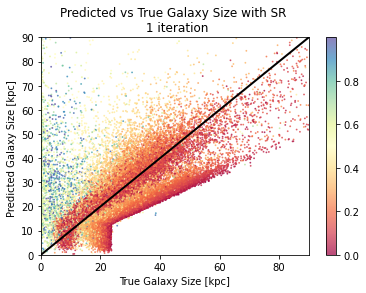

In [130]:
# color_dict = {(bulge_mstar_ratio)<=0.1 : 'red',
#                (bulge_mstar_ratio>0.1) & (bulge_mstar_ratio<0.6) : 'yellow',
#                (bulge_mstar_ratio)>=0.6 : 'blue'}
plt.scatter(y_addfeat_imp, model_addfeat_imp.predict(X_addfeat_imp),
            c = bulge_mstar_ratio,  cmap='Spectral',
            s=3, marker='.', alpha=0.7) #,label= label, vmin=-2, vmax=1.0)
plt.plot([0.0, 150], [0.0, 150], color = 'black', linewidth = 2)
plt.axis([0.0,90, 0.0,90])
plt.title('Predicted vs True Galaxy Size with SR \n 1 iteration')
plt.xlabel('True Galaxy Size [kpc]')
plt.ylabel('Predicted Galaxy Size [kpc] ')
plt.colorbar()
# plt.savefig('SR_predicted vs true gal size.jpeg', dpi=500)
plt.show()

In [38]:
bulge_mstar_ratio=X_addfeat_imp['GalpropNormMbulge']/X_addfeat_imp['GalpropNormMstar']

In [44]:
bulge_mstar_ratio=np.array(bulge_mstar_ratio)

In [50]:
bulge_mstar_ratio

array([0.69095346, 0.10822235, 0.15193713, ..., 0.16653929, 0.11830662,
       0.16649476])

In [63]:
bulge_mstar_ratio.any()

True

In [90]:
color_func(bulge_mstar_ratio[2])

blue


In [94]:
bulge_mstar_ratio[0:4]>=0.6

array([ True, False, False, False])

In [103]:
color_func(bulge_mstar_ratio[0:4])

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [102]:
def color_func(bulge_mstar_ratio):
    
        
    if bulge_mstar_ratio.any()<=0.1:
        
        color = 'red'
        
    elif bulge_mstar_ratio>=0.6: 
        color='blue'
    
    return print(color)

In [104]:
df_ratio=pd.DataFrame(X_addfeat_imp['GalpropNormMbulge']/X_addfeat_imp['GalpropNormMstar'])

In [119]:
df_ratio({df_ratio<=0.1 : [True]}).bool()

TypeError: 'DataFrame' objects are mutable, thus they cannot be hashed

In [ ]:
pd.DataFrame({'col': [True]}).bool()

In [126]:
def color_func(bulge_mstar_ratio):
    lst=[]
    i=0
    
    for i in len(df_ratio):
        
        if df_ratio[i, :]<=0.1:
        
            color = 'red'
        
        elif df_ratio[i, :]>=0.6: 
            color='blue'
    
        else:
            color='yellow'
    lst.append(color)
    return print(color, lst)

In [127]:
color_func(df_ratio)

TypeError: 'int' object is not iterable

In [125]:
len(df_ratio)

35390

In [41]:
(bulge_mstar_ratio>0.1) & (bulge_mstar_ratio<0.6)

0        False
1         True
2         True
3         True
4         True
         ...  
35385    False
35386    False
35387     True
35388     True
35389     True
Length: 35390, dtype: bool

In [ ]:
# Do it separately: 0-0.2 and 0.8-1 for MBulge/Mstar

In [21]:
np.where(bulge_mstar_ratio >0.8)

NameError: name 'bulge_mstar_ratio' is not defined